In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import pearsonr

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_energy_levels_correlation_with_likelihood(data, start_date, end_date, column, shift_days=0):
    # Convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Adjust start and end dates based on the shift
    if shift_days > 0:
        start_date += pd.Timedelta(days=shift_days)  # Start later if shifting backwards
    elif shift_days < 0:
        end_date += pd.Timedelta(days=shift_days)  # End sooner if shifting forwards

    # Filter data based on adjusted dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=-shift_days)

    # Drop rows where 'avg_energy' or the shifted column is NaN
    filtered_data = filtered_data.dropna(subset=[column, 'avg_energy'])

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])
    n = len(filtered_data)

    print(f"Pearson correlation between {column} shifted by {shift_days} days forward and average energy levels: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")
    print(f"Sample size: {n}")

    # Compute the Fisher z-transformation of the sample correlation
    z = np.arctanh(correlation)
    # Standard error of z
    se = 1 / np.sqrt(n - 3)

    # Generate a range of rho values from -0.99 to 0.99
    rho_values = np.linspace(-0.99, 0.99, 200)
    # Corresponding z-values for rho
    z_rho = np.arctanh(rho_values)
    # Compute the likelihood function (unnormalized)
    likelihood = np.exp(-0.5 * ((z - z_rho) / se) ** 2)
    # Normalize the likelihood function
    likelihood /= np.trapz(likelihood, rho_values)

    # Plot the likelihood function
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, likelihood)
    plt.title('Likelihood Function for Correlation Coefficient')
    plt.xlabel('Correlation Coefficient (rho)')
    plt.ylabel('Likelihood')
    plt.show()

    # Optionally, return the likelihood function
    return rho_values, likelihood

# Example usage:
# rho_values, likelihood = analyze_energy_levels_correlation_with_likelihood(data, '2024-05-28', '2024-06-13', 'sleep_duration', shift_days=-1)


In [11]:
def analyze_energy_levels_correlation(data, start_date, end_date, column, shift_days=0):
    # Convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Adjust start and end dates based on the shift
    if shift_days > 0:
        start_date += pd.Timedelta(days=shift_days)  # Start later if shifting backwards
    elif shift_days < 0:
        end_date += pd.Timedelta(days=shift_days)  # End sooner if shifting forwards

    # Filter data based on adjusted dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=-shift_days)

    # Drop rows where 'avg_energy' or the shifted column is NaN
    filtered_data = filtered_data.dropna(subset=[column, 'avg_energy'])

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])

    print(f"Pearson correlation between shifted {column} and average energy levels: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")

    # Plot the average energy levels with different values of the specified column
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x=filtered_data[column], y=filtered_data['avg_energy'])
    plt.title(f'Correlation between {column} (shifted {shift_days} days forward) and Average Energy Levels')
    plt.xlabel(column.capitalize())
    plt.ylabel('Average Energy')
    plt.tight_layout()
    plt.show()

    # Scatter plot of the energy levels indexed by date
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_data.index, filtered_data['avg_energy'], 'o', label='Average Energy')
    plt.title('Average Energy Levels Indexed by Date')
    plt.xlabel('Date')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_energy_levels_correlation(data, '2024-05-28', '2024-06-13', 'sleep_duration', shift_days=-1)

In [18]:
def analyze_sleep_data(data, start_date, end_date, column, sleep_score_column='sleep_duration', shift_days = 0):
    """ 
    params:
    data: pd.DataFrame
    start_date: str
    end_date: str
    column: str
    sleep_score_column: str 
        default='sleep_duration', possible options:
        - 'sleep_duration': sleep duration in minutes as measured by simon's zepp life band
        - 'time_to_fall_asleep': time in minutes to fall asleep
        - 'time_in_bed': time in bed in minutes as measured from simon's manual input
        - 'standup': time of standing up in the morning
        - 'woke_up': time of waking up according to simon's zepp life band
    """
    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Replace '-' with NaN and convert to datetime
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]
    filtered_data['went_to_bed'] = pd.to_datetime(filtered_data['went_to_bed'], format='%H:%M', errors='coerce')
    filtered_data['fell_asleep'] = pd.to_datetime(filtered_data['fell_asleep'], format='%H:%M', errors='coerce')

    # Exclude rows with missing values in 'went_to_bed' or 'fell_asleep'
    filtered_data = filtered_data.dropna(subset=['went_to_bed', 'fell_asleep', column])

    # Ensure positive duration to fall asleep
    filtered_data['fell_asleep'] = filtered_data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

    # Calculate the duration to fall asleep in minutes
    filtered_data['time_to_fall_asleep'] = (filtered_data['fell_asleep'] - filtered_data['went_to_bed']).dt.total_seconds() / 60.0

    # Calculate the total sleep duration
    # TODO: use simon's data for time in bed:
    filtered_data['time_in_bed'] = ((filtered_data['standup'] + pd.Timedelta(days=1)) - filtered_data['went_to_bed']).dt.total_seconds() / 60.0
    # assert time_in bed always < 1 day
    assert (filtered_data['time_in_bed'] < 24*60).all()

    filtered_data['sleep_duration'] = filtered_data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=-shift_days)

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data[sleep_score_column])
    n = len(filtered_data)

    print(f"Pearson correlation between {column} shifted by {shift_days} days forward and average energy levels: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")
    print(f"Sample size: {n}")

    # Compute the Fisher z-transformation of the sample correlation
    z = np.arctanh(correlation)
    # Standard error of z
    se = 1 / np.sqrt(n - 3)

    # Generate a range of rho values from -0.99 to 0.99
    rho_values = np.linspace(-0.99, 0.99, 200)
    # Corresponding z-values for rho
    z_rho = np.arctanh(rho_values)
    # Compute the likelihood function (unnormalized)
    likelihood = np.exp(-0.5 * ((z - z_rho) / se) ** 2)
    # Normalize the likelihood function
    likelihood /= np.trapz(likelihood, rho_values)

    # Plot the likelihood function
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, likelihood)
    plt.title('Likelihood Function for Correlation Coefficient')
    plt.xlabel('Correlation Coefficient (rho)')
    plt.ylabel('Likelihood')
    plt.show()

    # Optionally, return the likelihood function
    return rho_values, likelihood

In [19]:

def analyse_breaks(sessions): #Unclear how this is different from the simpler model analyze_breaks_since_rest
    # Calculate days since the last rest day correctly
    sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
    sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
    sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

    # Identify energy columns
    energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

    # Calculate average energy for available sessions
    sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

    # Exclude the 0th day data
    sessions = sessions[sessions['days_since_rest'] > 0]
    sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)
    # Bayesian linear model
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal('alpha', mu=80, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=10)

        # Expected energy level (linear model)
        mu = alpha + beta * sessions['days_since_rest']

        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=sessions['avg_energy'])

        # Inference
        trace = pm.sample(2000, return_inferencedata=True)

    # Plotting
    plt.figure(figsize=(12, 10))

    # Plot 1: Energy Levels vs Days Since Rest
    plt.subplot(2, 1, 1)
    x_plot = np.linspace(0, sessions['days_since_rest'].max(), 100)
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.flatten()
    y_post = alpha_samples[:, None] + beta_samples[:, None] * x_plot

    plt.plot(x_plot, y_post.mean(axis=0), color='blue', label='Posterior mean')
    plt.fill_between(x_plot, 
                    np.percentile(y_post, 2.5, axis=0), 
                    np.percentile(y_post, 97.5, axis=0),
                    color='blue', alpha=0.3, label='95% CI')
    plt.scatter(sessions['days_since_rest'], sessions['avg_energy'], color='red', alpha=0.5, label='Observed data')
    plt.xlim(0, sessions['days_since_rest'].max())  # Set appropriate x-axis limits
    plt.xlabel('Days since last rest day')
    plt.ylabel('Average Energizedness')
    plt.title('Energy Levels vs Days Since Rest')
    plt.legend()

    # Plot 2: Posterior Distributions
    plt.subplot(2, 1, 2)
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
    plt.title('Posterior Distributions')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))

In [20]:

def analyze_breaks_days_since_rest(sessions):
    # Calculate days since the last rest day correctly
    sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
    sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
    sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

    # Identify energy columns
    energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

    # Calculate average energy for available sessions
    sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

    # Exclude the 0th day data
    sessions = sessions[sessions['days_since_rest'] > 0]
    # Plotting
    plt.figure(figsize=(12, 10))

    # Plot 1: Energy Levels vs Days Since Rest
    plt.subplot(2, 1, 1)
    x_plot = np.linspace(0, sessions['days_since_rest'].max(), 100)
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.flatten()
    y_post = alpha_samples[:, None] - beta_samples[:, None] * (1 - np.exp(-x_plot / 3))

    plt.plot(x_plot, y_post.mean(axis=0), color='blue', label='Posterior mean')
    plt.fill_between(x_plot, 
                    np.percentile(y_post, 2.5, axis=0), 
                    np.percentile(y_post, 97.5, axis=0),
                    color='blue', alpha=0.3, label='95% CI')
    plt.scatter(sessions['days_since_rest'], sessions['avg_energy'], color='red', alpha=0.5, label='Observed data')
    plt.xlim(0, sessions['days_since_rest'].max())  # Set appropriate x-axis limits
    plt.xlabel('Days since last rest day')
    plt.ylabel('Average Energizedness')
    plt.title('Energy Levels vs Days Since Rest')
    plt.legend()

    # Plot 2: Posterior Distributions
    plt.subplot(2, 1, 2)
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
    plt.title('Posterior Distributions')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))

In [21]:
# Constants:
start_date = pd.to_datetime('2024-05-28')
end_date = pd.to_datetime('2024-09-10')

# TODO: handle week of break (2024-07-22 to 2024-07-28)
# TODO: For randomized variables, only use the period where that random variable is randomized. Check what is the easiest way to do this.
# TODO: handle masturbation


In [22]:
# Load the dataset
file_path = './data/Simon Data - Tabellenblatt1.csv'
data = pd.read_csv(file_path, header=0)

# Display the first few rows of the dataset to understand its structure
data.head()


Date went to bed Fell asleep in bed for woke up standup  weekday  \
0  2024-05-24       22:05       22:38      05:31   04:09   07:33      5.0   
1  2024-05-25       21:37       22:20      09:44   08:17   08:19      6.0   
2  2024-05-26       21:42       22:42      09:02   07:44   07:44      7.0   
3  2024-05-27           -       23:45      09:07   08:52   08:59      1.0   
4  2024-05-28       21:40       21:57      09:15   07:14   07:27      2.0   

   Potassium (1) (10% prob)  Iodine (1) (50% prob)  Omega3 (1) (70% prob)  \
0                       NaN                    NaN                    NaN   
1                       0.0                    0.0                    1.0   
2                       0.0                    1.0                    1.0   
3                       1.0                    1.0                    0.0   
4                       1.0                    0.0                    0.0   

   ...  Session_2_3  Session_3_1  Session_3_2  Session_3_3  questions gluten  \
0  ...          NaN          NaN          NaN          NaN               NaN   
1  ...          NaN          NaN          NaN          NaN               NaN   
2  ...          NaN          NaN          NaN          NaN               NaN   
3  ...          NaN          NaN          NaN          NaN               NaN   
4  ...          NaN          NaN          NaN          NaN               NaN   

  Gluten mittag  Gluten (in slices of bread) nausea  blähungen Unnamed: 49  
0           NaN                          NaN    NaN        NaN         NaN  
1           NaN                          NaN    NaN        NaN         NaN  
2           NaN                          NaN    NaN        NaN         NaN  
3           NaN                          NaN    NaN        NaN         NaN  
4           NaN                          NaN    NaN        NaN         NaN  

[5 rows x 50 columns]

In [23]:
data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']

def shorten_column_names(df):
    column_mapping = {
        'Date': 'date',
        'went to bed': 'went_to_bed',
        'Fell asleep': 'fell_asleep',
        'in bed for': 'in_bed_for',
        'woke up': 'woke_up',
        'standup': 'standup',
        'Potassium (1)': 'potassium',
        'Iodine': 'iodine',
        'Omega3 (1)': 'omega3',
        'Vitamin D (1)': 'vitamin_d',
        'Notes': 'notes',
        'Creatine_not_randomized': 'creatine',
        'Masturbate': 'masturbate',
        'porn': 'porn',
        'Earplugs': 'earplugs',
        'Window': 'window',
        'melatonin': 'melatonin',
        'last food': 'last_food',
        'L-theanine': 'l_theanine',
        'Methylphenidate': 'methylphenidate',
        'Muntermacher': 'muntermacher',
        'caffeine': 'caffeine',
        'Vitamin B complex': "vitamin_b",
        'Magnesium': "magnesium",
        'Probiotic': "probiotic",
        'Session_1_cold_shower': 'session_1_cold_shower',
        'Session_2_cold_shower': 'session_2_cold_shower',
        'Session_3': 'session_3',
        'Rest day': 'rest_day',
        'Session_1_1': 'session_1_1',
        'Session_1_2': 'session_1_2',
        'Session_1_3': 'session_1_3',
        'Session_2_1': 'session_2_1',
        'Session_2_2': 'session_2_2',
        'Session_2_3': 'session_2_3',
        'Session_3_1': 'session_3_1',
        'Session_3_2': 'session_3_2',
        'Session_3_3': 'session_3_3',
        'Melatonin (50%) [taken through spray ~0.15mg]': 'melatonin_randomized',
        'Creatine (1) (60% prob)': 'creatine_randomized',
        'Masturbate (before sleep)': 'masturbate_before_sleep',
        'Masturbate (time)': 'masturbate_time',

    }
    real_mapping = {}
    for column in column_mapping.keys():
        for df_column in list(df.columns):
            if df_column.startswith(column):
                real_mapping[df_column] = column_mapping[column]
        
    
    columns_to_drop = [
        'questions gluten', 
        'Gluten mittag',
        'Gluten (in slices of bread)',
        'nausea',
        'blähungen',
        'Unnamed: 49',
    ]
    df = df.drop(columns=columns_to_drop)
    df = df.rename(columns=real_mapping)
    return df

data = shorten_column_names(data)

In [24]:
data.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'potassium', 'iodine', 'omega3', 'vitamin_d',
       'probiotic', 'melatonin_randomized', 'creatine_randomized', 'magnesium',
       'notes', 'vitamin_b', 'creatine', 'masturbate_before_sleep',
       'masturbate_time', 'porn', 'earplugs', 'window', 'melatonin',
       'Übelkeit', 'last_food', 'l_theanine', 'methylphenidate',
       'muntermacher', 'caffeine', 'Unnamed: 30', 'session_1_cold_shower',
       'session_2_cold_shower', 'session_3', 'rest_day', 'session_1_1',
       'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2',
       'session_2_3', 'session_3_1', 'session_3_2', 'session_3_3'],
      dtype='object')

### Define Session:

In [25]:
session_columns = ['session_1_1', 'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2', 'session_2_3', "rest_day"]
sessions = data[session_columns]
sessions = sessions[sessions.index > start_date]

# Fill NaN values with 0
sessions.rest_day = pd.to_numeric(sessions.rest_day)

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions = sessions[sessions['days_since_rest'] > 0]

# Calculate days until the next rest day
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions['days_since_rest'] = sessions['days_since_rest'].apply(lambda x: 3 if x >= 3 else x)

# Calculate days until the next rest day
sessions['days_until_rest'] = sessions[::-1]['rest_day'].eq(1).cumsum()
sessions['days_until_rest'] = sessions.groupby('days_until_rest').cumcount()
# sessions['days_until_rest'] = sessions['days_until_rest'].apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions_until_rest = sessions[sessions['days_until_rest'] > 0]

### Define filtered data

In [26]:

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

filtered_data = data
# Filter data based on dates
filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

# Exclude days with all missing energy data for the first two sessions
filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

# Calculate the average energy levels for the first two work sessions
filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

# Drop rows where 'avg_energy' is NaN (if both sessions are missing)
filtered_data = filtered_data.dropna(subset=['avg_energy'])

filtered_data

date went_to_bed fell_asleep in_bed_for woke_up standup  \
Date                                                                       
2024-05-29 2024-05-29       21:50       22:43      09:20   08:05   08:07   
2024-05-30 2024-05-30       22:30       23:02      08:00   07:12   07:30   
2024-06-01 2024-06-01       22:08       22:48      08:36   07:24   07:27   
2024-06-02 2024-06-02       21:56       22:45      08:48   07:39   07:41   
2024-06-03 2024-06-03           -       23:24      08:02   07:26       -   
...               ...         ...         ...        ...     ...     ...   
2024-09-05 2024-09-05       22:07         NaN        NaN     NaN   07:33   
2024-09-06 2024-09-06       21:42         NaN        NaN     NaN   07:53   
2024-09-08 2024-09-08       21:20         NaN        NaN     NaN   08:07   
2024-09-09 2024-09-09       21:23         NaN        NaN     NaN   07:26   
2024-09-10 2024-09-10       21:39         NaN        NaN     NaN   07:33   

            weekday  potassium  iodine  omega3  ...  session_1_3  session_2_1  \
Date                                            ...                             
2024-05-29      3.0        0.0     0.0     1.0  ...         76.0         84.0   
2024-05-30      4.0        0.0     0.0     0.0  ...         85.0         82.0   
2024-06-01      6.0        0.0     0.0     0.0  ...         80.0         79.0   
2024-06-02      7.0        1.0     1.0     1.0  ...         75.0         77.0   
2024-06-03      1.0        0.0     1.0     1.0  ...         83.0         80.0   
...             ...        ...     ...     ...  ...          ...          ...   
2024-09-05      4.0        0.0     0.0     0.0  ...         80.0         78.0   
2024-09-06      5.0        0.0     1.0     0.0  ...         82.0         80.0   
2024-09-08      7.0        0.0     0.0     0.0  ...         82.0         82.0   
2024-09-09      1.0        0.0     0.0     1.0  ...         82.0         83.0   
2024-09-10      2.0        0.0     1.0     0.0  ...         81.0         82.0   

            session_2_2  session_2_3  session_3_1 session_3_2  session_3_3  \
Date                                                                         
2024-05-29         85.0         76.0         79.0        75.0           68   
2024-05-30         84.0         89.0          NaN         NaN          NaN   
2024-06-01         77.0         82.0         82.0        82.0           81   
2024-06-02         75.0         76.0          NaN         NaN          NaN   
2024-06-03         82.0         81.0         74.0        75.0          NaN   
...                 ...          ...          ...         ...          ...   
2024-09-05          NaN          NaN         80.0        80.0          NaN   
2024-09-06         81.0         80.0         80.0        79.0          NaN   
2024-09-08         82.0         82.0         82.0         NaN          NaN   
2024-09-09         83.0         81.0         81.0        80.0          NaN   
2024-09-10         81.0         79.0          NaN         NaN          NaN   

           avg_energy_session_1  avg_energy_session_2 avg_energy  
Date                                                              
2024-05-29                 73.5                  84.5      79.00  
2024-05-30                 84.5                  83.0      83.75  
2024-06-01                 77.5                  78.0      77.75  
2024-06-02                 81.0                  76.0      78.50  
2024-06-03                 76.0                  81.0      78.50  
...                         ...                   ...        ...  
2024-09-05                 80.0                  78.0      79.00  
2024-09-06                 81.5                  80.5      81.00  
2024-09-08                 81.5                  82.0      81.75  
2024-09-09                 80.5                  83.0      81.75  
2024-09-10                 80.5                  81.5      81.00  

[81 rows x 47 columns]

## Analysing:

In [17]:
#analyse_breaks(sessions) # NOTE: Takes 2-3 minutes

In [18]:
#analyze_sleep_data(data, '2024-05-28', '2024-06-13', 'potassium') # NOTE: unclear where sleep score is 

In [20]:
# analyze_sleep_data(data, '2024-05-28', end_date, 'omega3') # NOTE: unclear where sleep score is

In [22]:
#analyze_sleep_data(data, '2024-05-28', end_date, 'iodine') # unclear where sleep score is

In [23]:
#analyze_sleep_data(data, '2024-05-28', end_date, 'vitamin_d') # unclear where sleep score is

In [24]:
# analyze_sleep_data(data, '2024-05-28', end_date, 'vitamin_d') # unclear where sleep score is

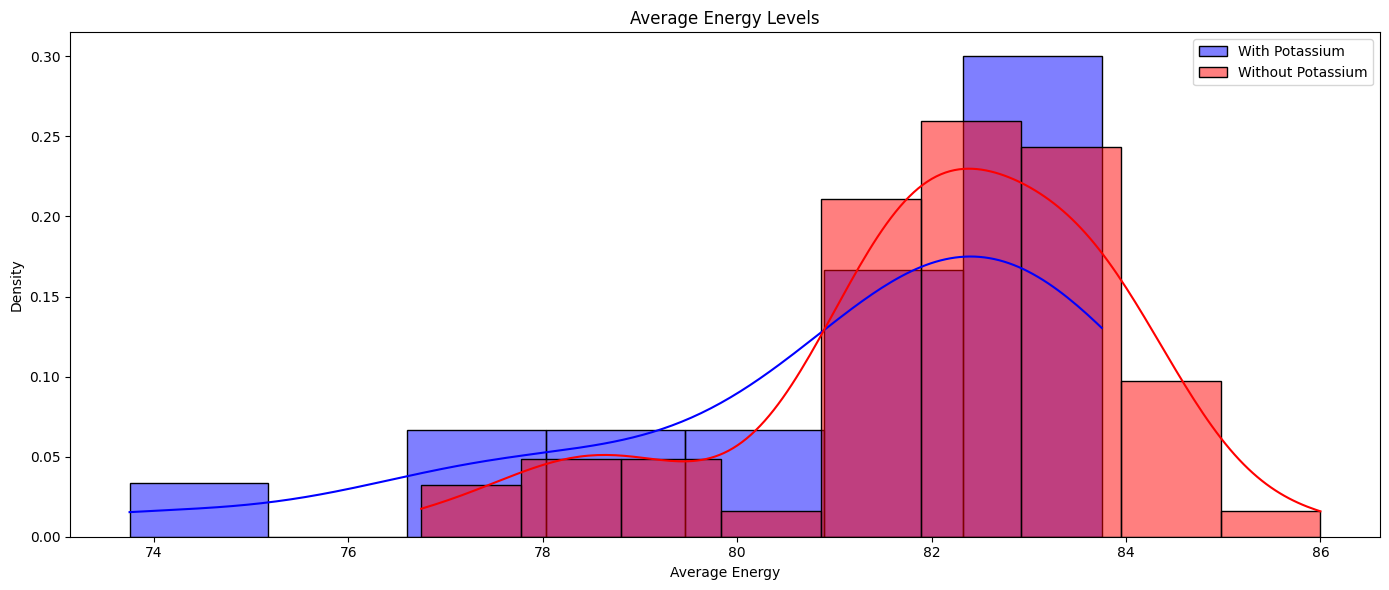

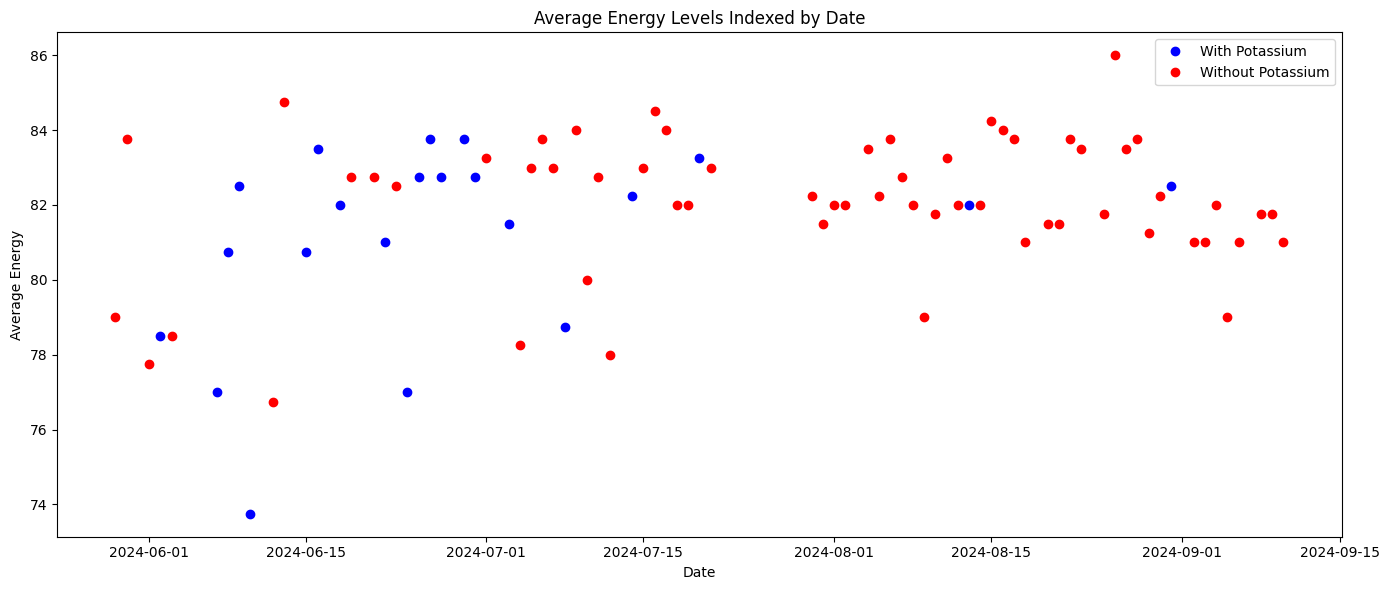

In [25]:

column = 'potassium'
# Plot the average energy levels with and without the given column (e.g., Potassium) intake
plt.figure(figsize=(14, 6))
sns.histplot(filtered_data[filtered_data[column] == 1]['avg_energy'], color='blue', label=f'With {column.capitalize()}', kde=True, stat="density")
sns.histplot(filtered_data[filtered_data[column] == 0]['avg_energy'], color='red', label=f'Without {column.capitalize()}', kde=True, stat="density")
plt.title('Average Energy Levels')
plt.xlabel('Average Energy')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot of the energy levels indexed by date
plt.figure(figsize=(14, 6))
plt.plot(filtered_data[filtered_data[column] == 1].index, filtered_data[filtered_data[column] == 1]['avg_energy'], 'o', color='blue', label=f'With {column.capitalize()}')
plt.plot(filtered_data[filtered_data[column] == 0].index, filtered_data[filtered_data[column] == 0]['avg_energy'], 'o', color='red', label=f'Without {column.capitalize()}')
plt.title('Average Energy Levels Indexed by Date')
plt.xlabel('Date')
plt.ylabel('Average Energy')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:

def analyze_energy_levels(data, start_date, end_date, column):
    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter data based on dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Drop rows where 'avg_energy' is NaN (if both sessions are missing)
    filtered_data = filtered_data.dropna(subset=['avg_energy'])

    # Plot the average energy levels with different values of the specified column
    plt.figure(figsize=(14, 6))
    unique_values = filtered_data[column].dropna().unique()
    for value in unique_values:
        sns.histplot(filtered_data[filtered_data[column] == value]['avg_energy'], kde=True, stat="density", label=f'{column.capitalize()} = {value}')
    plt.title('Average Energy Levels')
    plt.xlabel('Average Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter plot of the energy levels indexed by date
    plt.figure(figsize=(14, 6))
    for value in unique_values:
        plt.plot(filtered_data[filtered_data[column] == value].index, filtered_data[filtered_data[column] == value]['avg_energy'], 'o', label=f'{column.capitalize()} = {value}')
    plt.title('Average Energy Levels Indexed by Date')
    plt.xlabel('Date')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bayesian Model: Average Energy Levels
    with pm.Model() as model_energy_levels:
        # Priors for each unique value of the column
        priors = {}
        likelihoods = []
        for value in unique_values:
            priors[f'mu_{value}'] = pm.Normal(f'mu_{value}', mu=0, sigma=10)
            priors[f'sigma_{value}'] = pm.HalfNormal(f'sigma_{value}', sigma=10)
            likelihoods.append(pm.Normal(f'energy_{value}', mu=priors[f'mu_{value}'], sigma=priors[f'sigma_{value}'], observed=filtered_data['avg_energy'][filtered_data[column] == value]))

        # Difference in means
        differences = {}
        for i in range(len(unique_values) - 1):
            for j in range(i + 1, len(unique_values)):
                differences[f'diff_{unique_values[i]}_{unique_values[j]}'] = pm.Deterministic(f'diff_{unique_values[i]}_{unique_values[j]}', priors[f'mu_{unique_values[j]}'] - priors[f'mu_{unique_values[i]}'])

        # Inference
        trace_energy = pm.sample(2000, return_inferencedata=True)

    # Summary of the results
    var_names = [f'mu_{value}' for value in unique_values] + [f'sigma_{value}' for value in unique_values] + list(differences.keys())
    print("Summary for Average Energy Levels Model:")
    print(az.summary(trace_energy, var_names=var_names))

    # Plot the results
    az.plot_trace(trace_energy, var_names=var_names)
    plt.show()

    # Plot the posterior distributions of the differences
    az.plot_posterior(trace_energy, var_names=list(differences.keys()))
    plt.title('Posterior Distribution of Differences in Average Energy Levels')
    plt.show()

# Example usage:
# analyze_energy_levels(data, '2024-05-28', '2024-06-13', 'sleep_duration')


In [27]:
data['went_to_bed'] = pd.to_datetime(filtered_data['went_to_bed'], format='%H:%M', errors='coerce')
data['fell_asleep'] = pd.to_datetime(filtered_data['fell_asleep'], format='%H:%M', errors='coerce')

# Exclude rows with missing values in 'went_to_bed' or 'fell_asleep' or 'in_bed_for'
data= data.dropna(subset=['went_to_bed', 'fell_asleep', 'in_bed_for'])

# Ensure positive duration to fall asleep
data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

# Calculate the duration to fall asleep in minutes
data['time_to_fall_asleep'] = (data['fell_asleep'] - data['went_to_bed']).dt.total_seconds() / 60.0

# Calculate the total sleep duration
data['sleep_duration'] = data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
# TODO: use simon's numbers for sleep duration instead using went_to_bed and woke up


In [28]:
data.masturbate_time.astype(bool)

Date
2024-05-29    True
2024-05-30    True
2024-06-01    True
2024-06-02    True
2024-06-07    True
              ... 
2024-08-30    True
2024-08-31    True
2024-09-02    True
2024-09-03    True
2024-09-04    True
Name: masturbate_time, Length: 74, dtype: bool

In [31]:
data.creatine.fillna(0, inplace=True)
data.creatine = pd.to_numeric(data.melatonin)
data.masturbate_before_sleep.fillna(0, inplace=True)
data.masturbate_time.fillna(0, inplace=True)
data.porn.fillna(0, inplace=True)
data.porn = data.porn.astype('bool').astype('float')
data.melatonin.fillna(0.15, inplace=True)
data.melatonin = pd.to_numeric(data.melatonin)
data.caffeine.fillna(0, inplace=True)
data.caffeine = pd.to_numeric(data.caffeine)
data.window.fillna(1, inplace=True)
data.session_1_cold_shower.fillna(0, inplace=True)

In [32]:
data['masturbation'] = (data.masturbate_before_sleep.astype('bool') | data.masturbate_time.astype('bool') | data.porn.astype('bool')).astype(float)

Pearson correlation between shifted sleep_duration and average energy levels: -0.031
P-value: 0.794


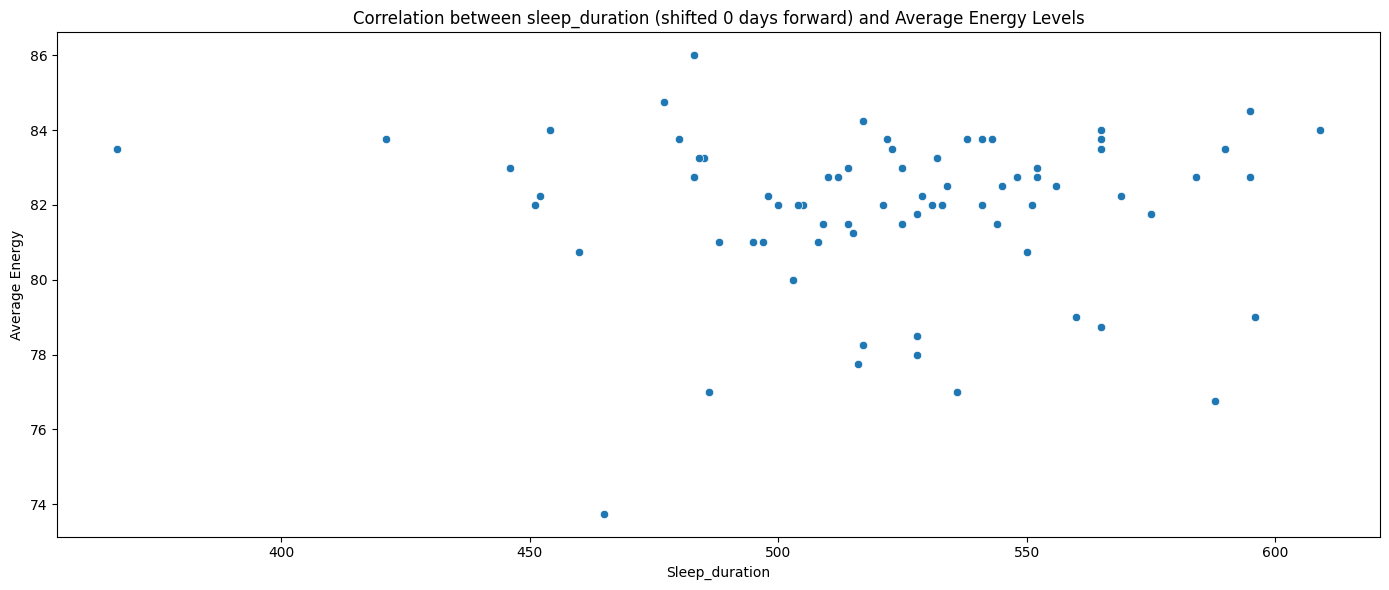

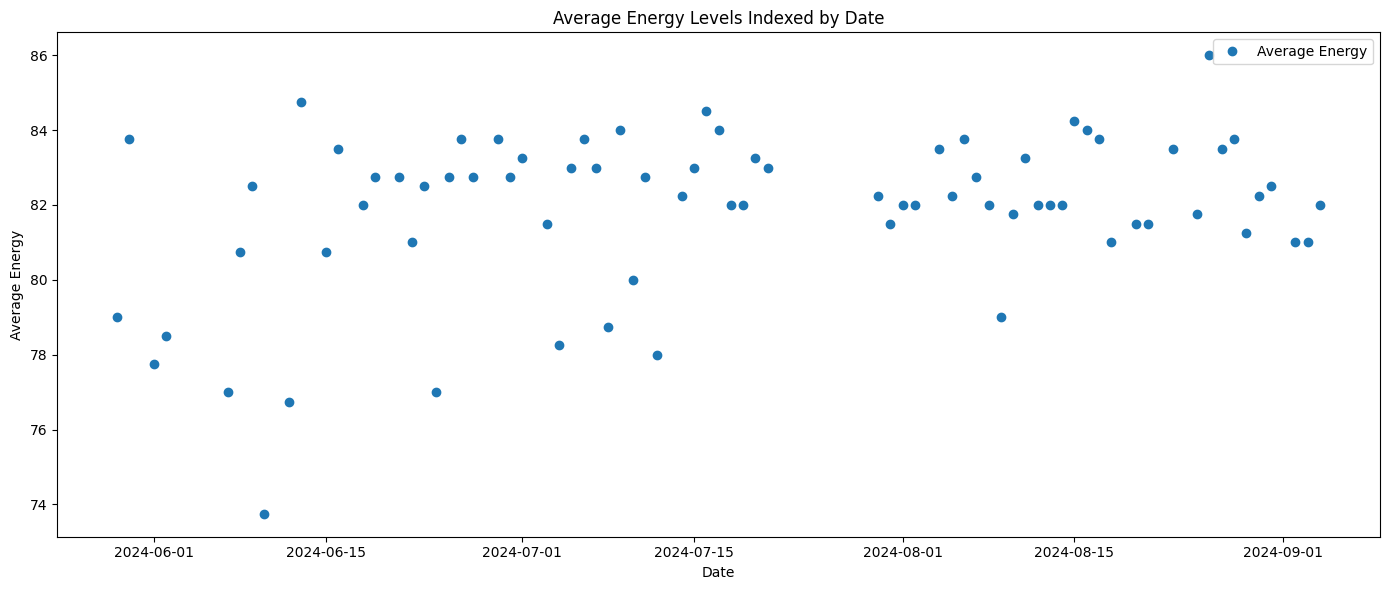

Pearson correlation between shifted potassium and average energy levels: -0.235
P-value: 0.043


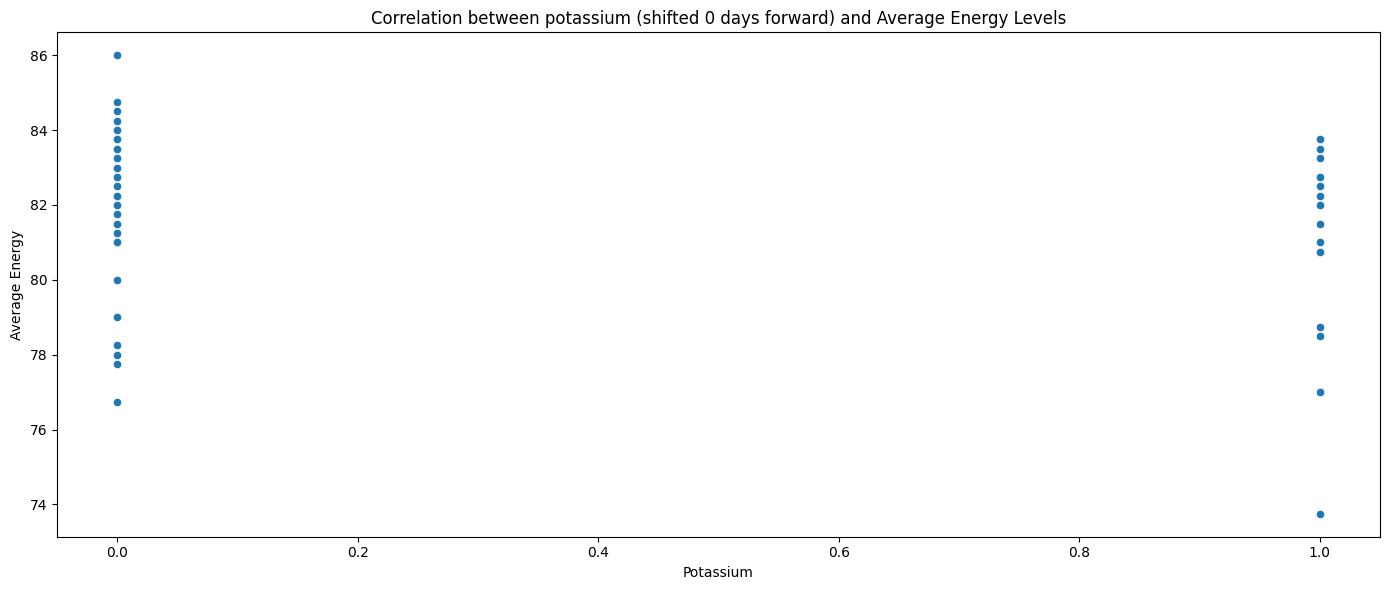

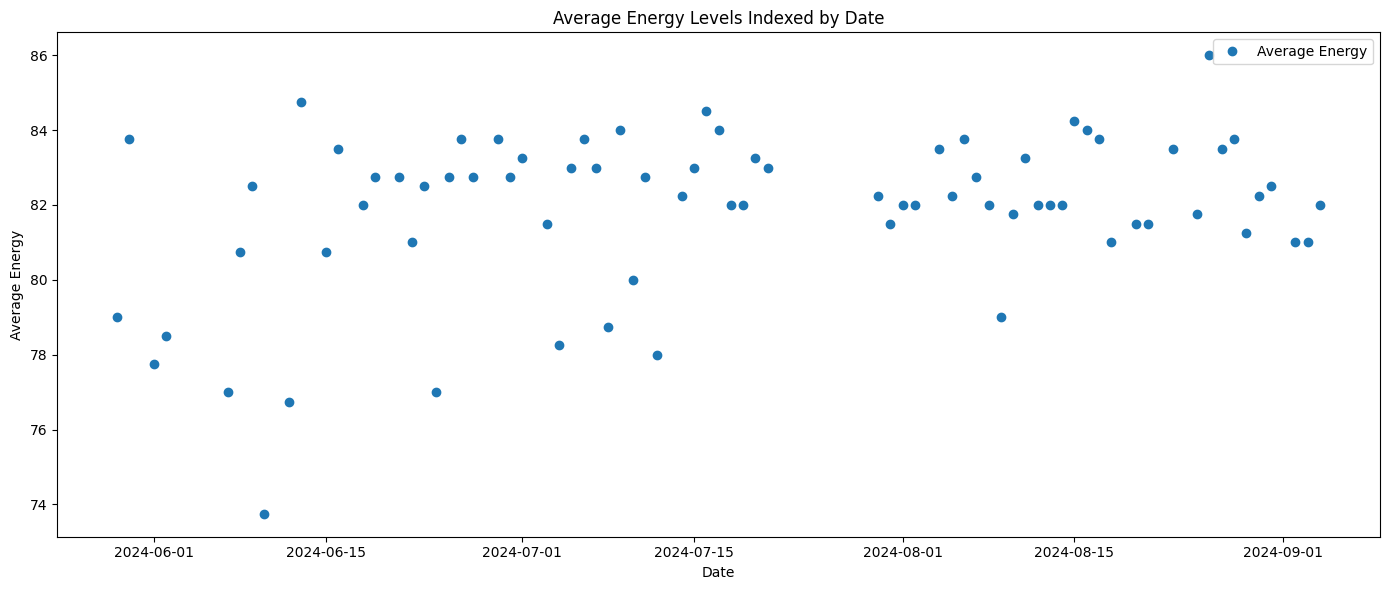

Pearson correlation between shifted iodine and average energy levels: 0.013
P-value: 0.913


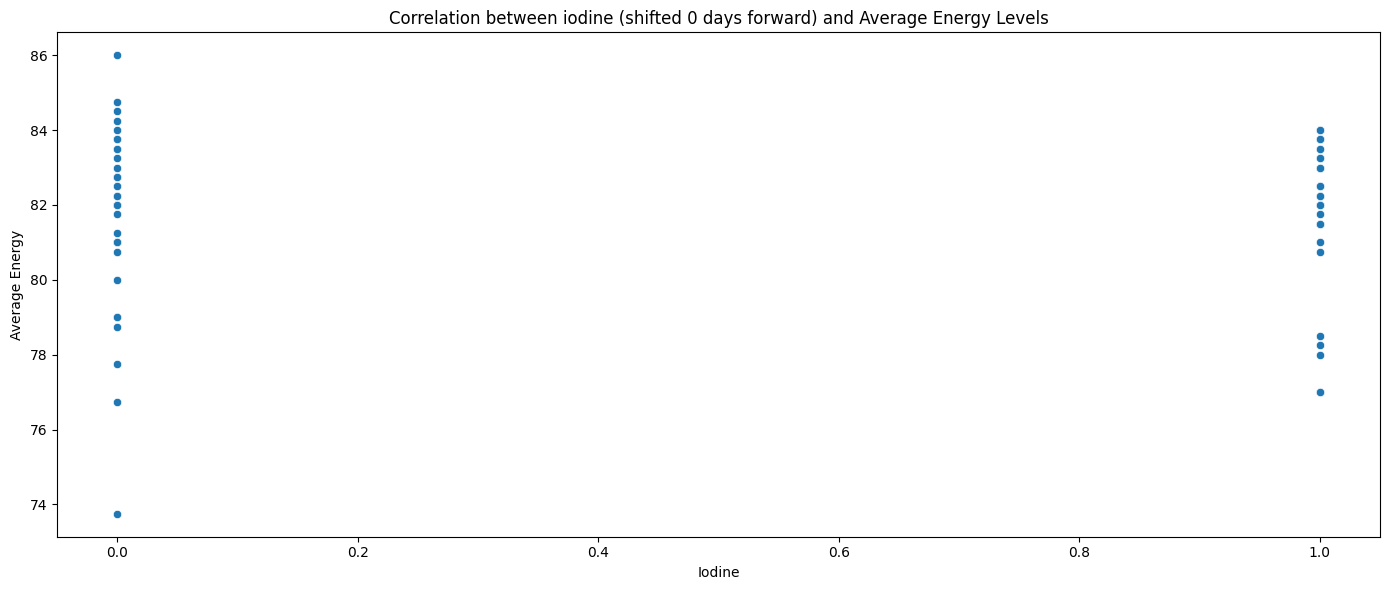

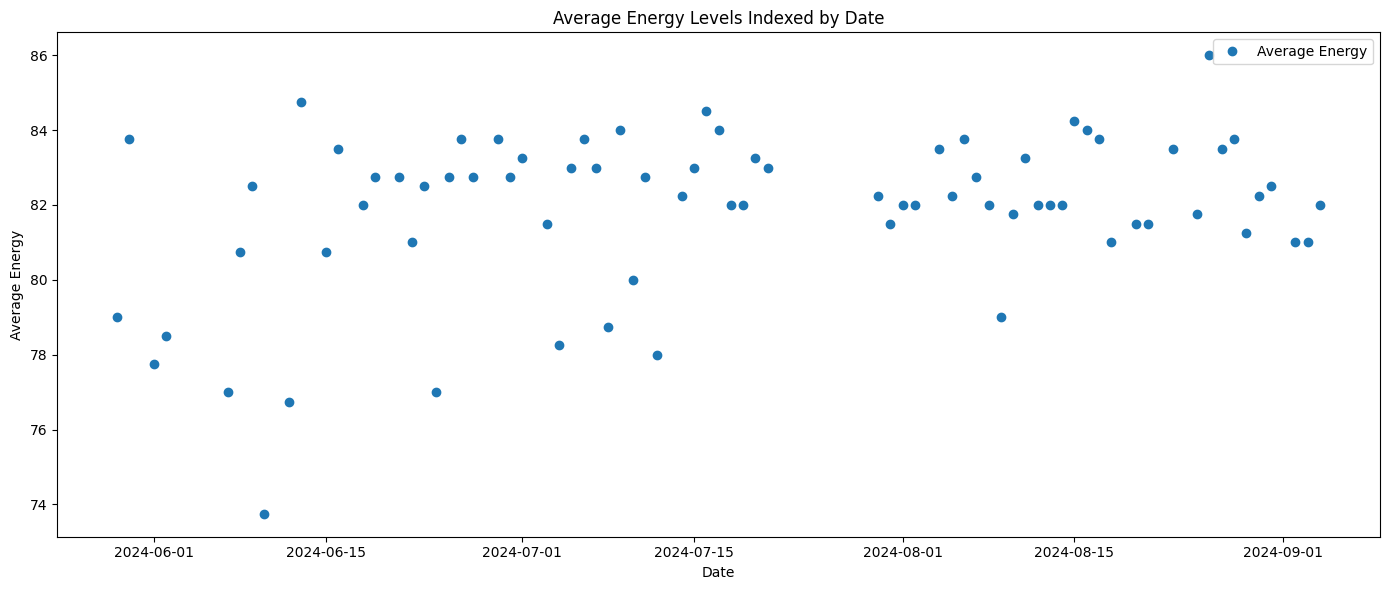

Pearson correlation between shifted omega3 and average energy levels: 0.016
P-value: 0.893


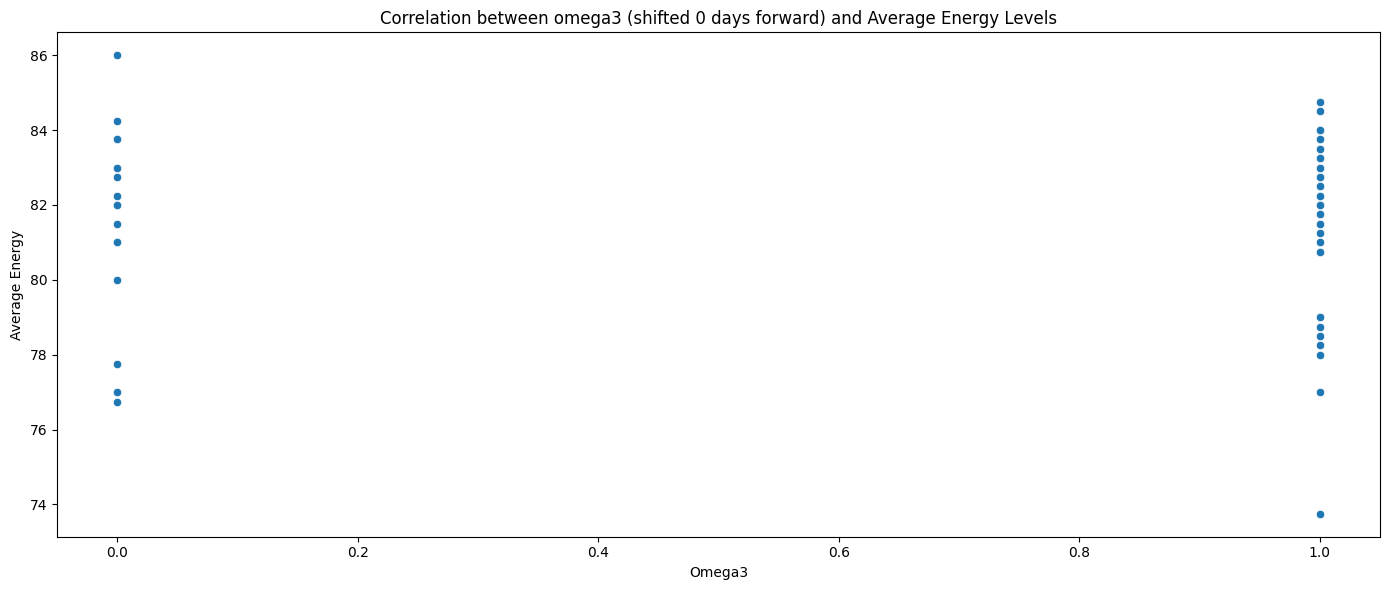

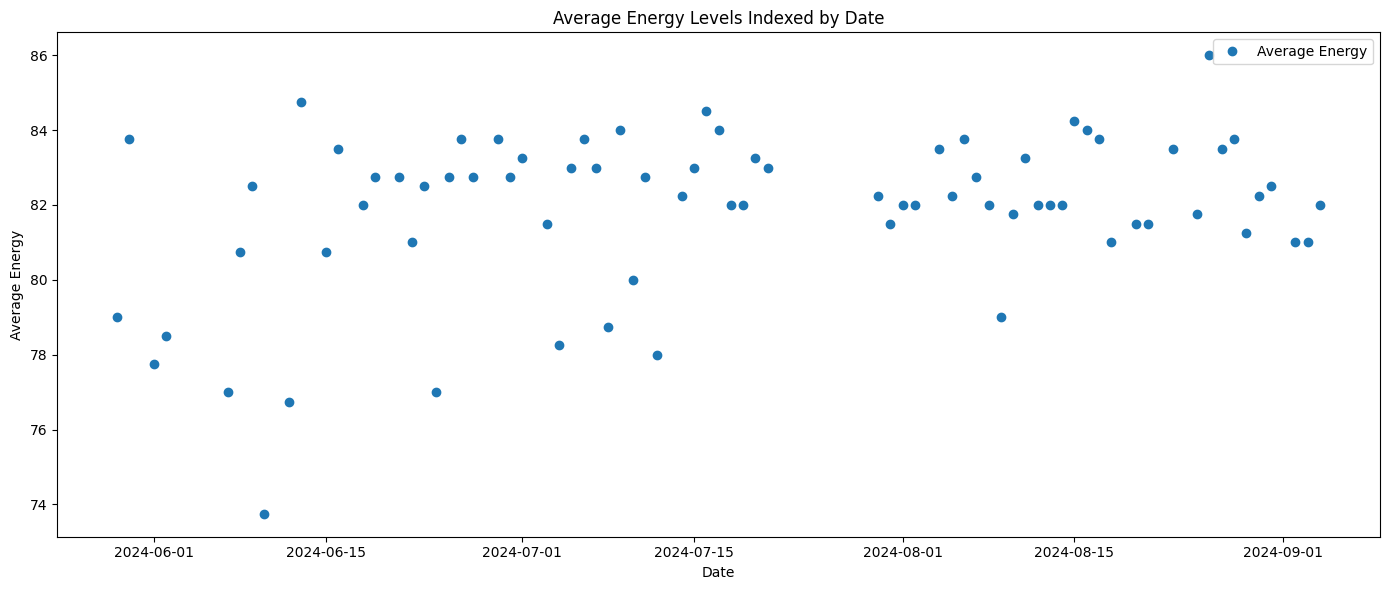

Pearson correlation between shifted vitamin_d and average energy levels: 0.055
P-value: 0.644


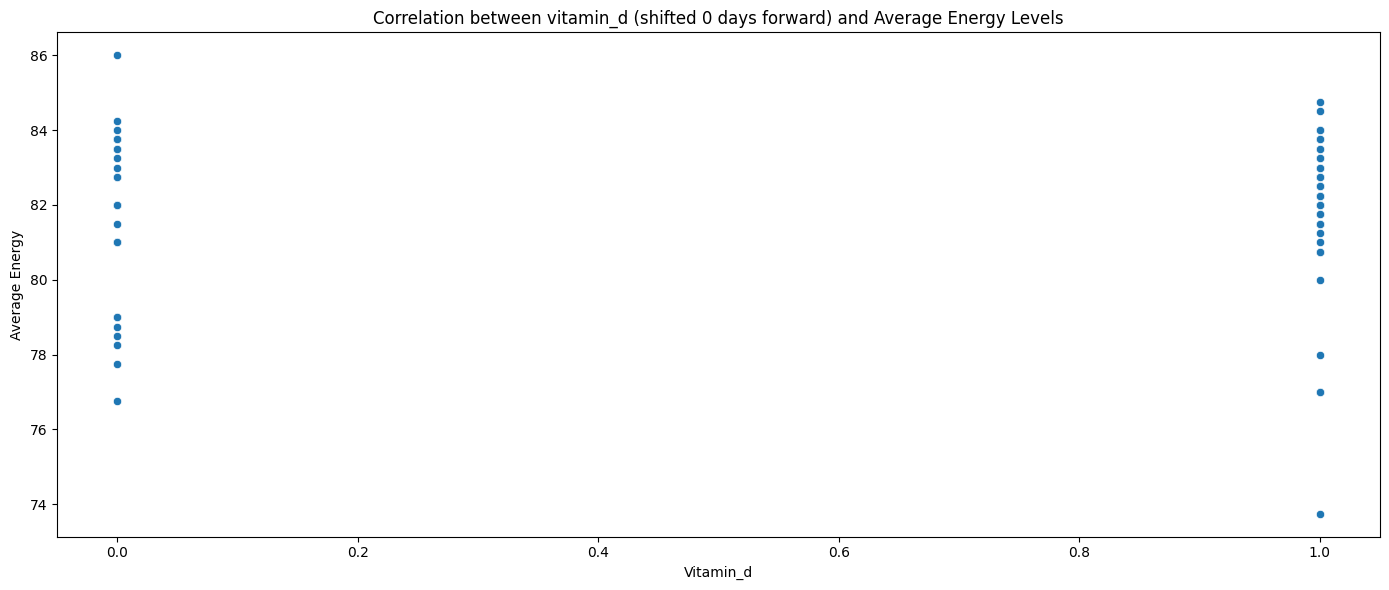

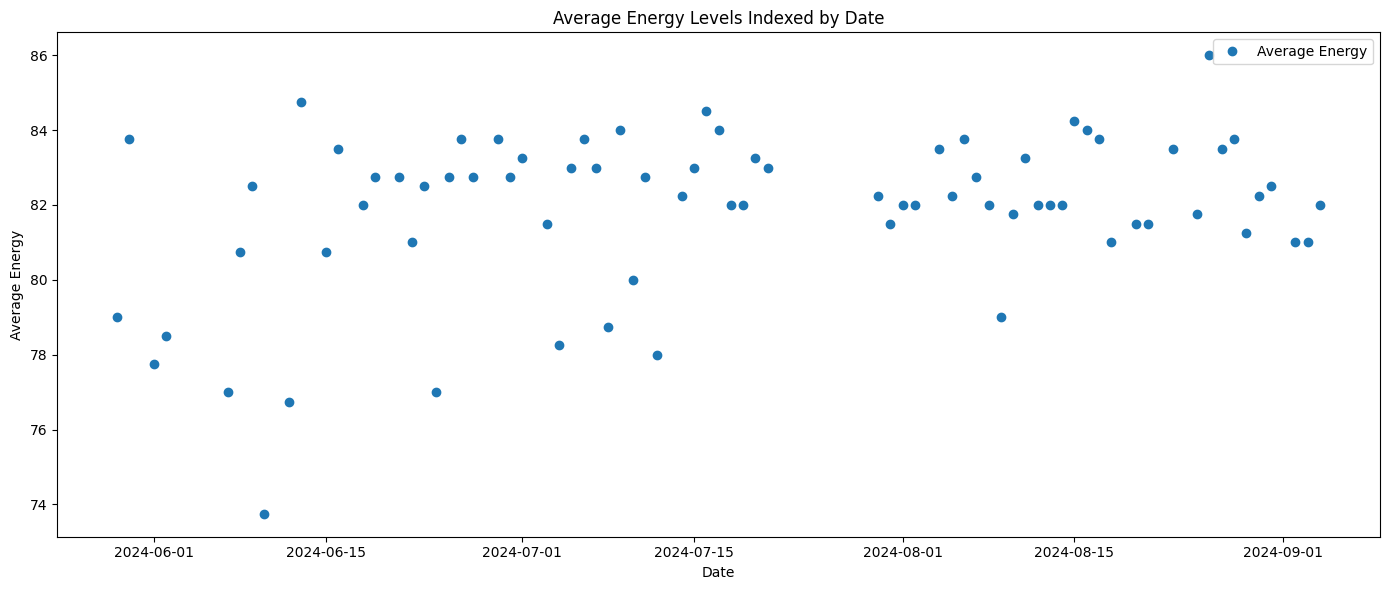

Pearson correlation between shifted creatine_randomized and average energy levels: -0.027
P-value: 0.902


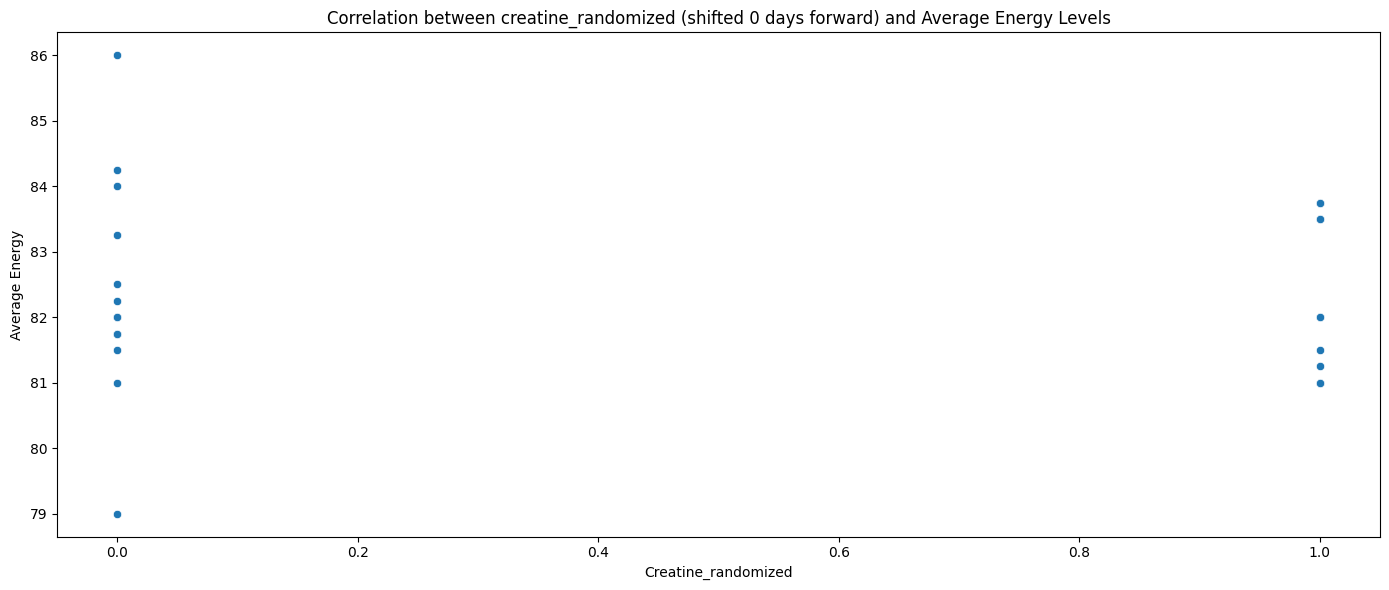

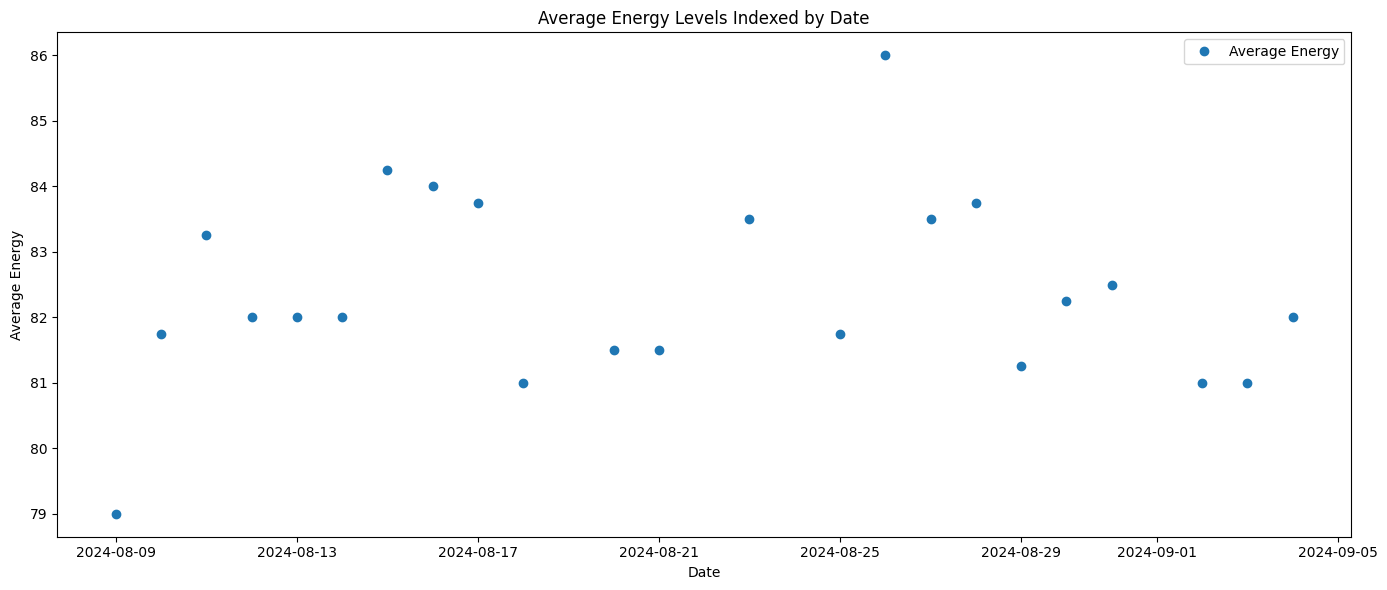

Pearson correlation between shifted masturbation and average energy levels: -0.171
P-value: 0.145


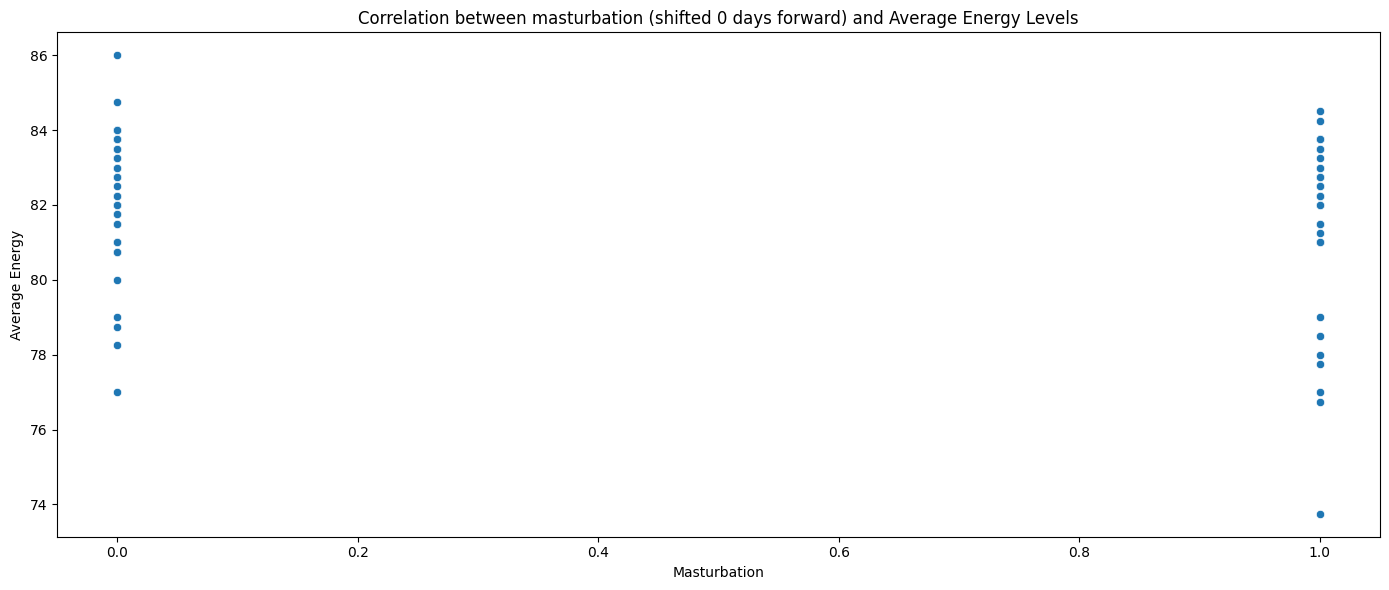

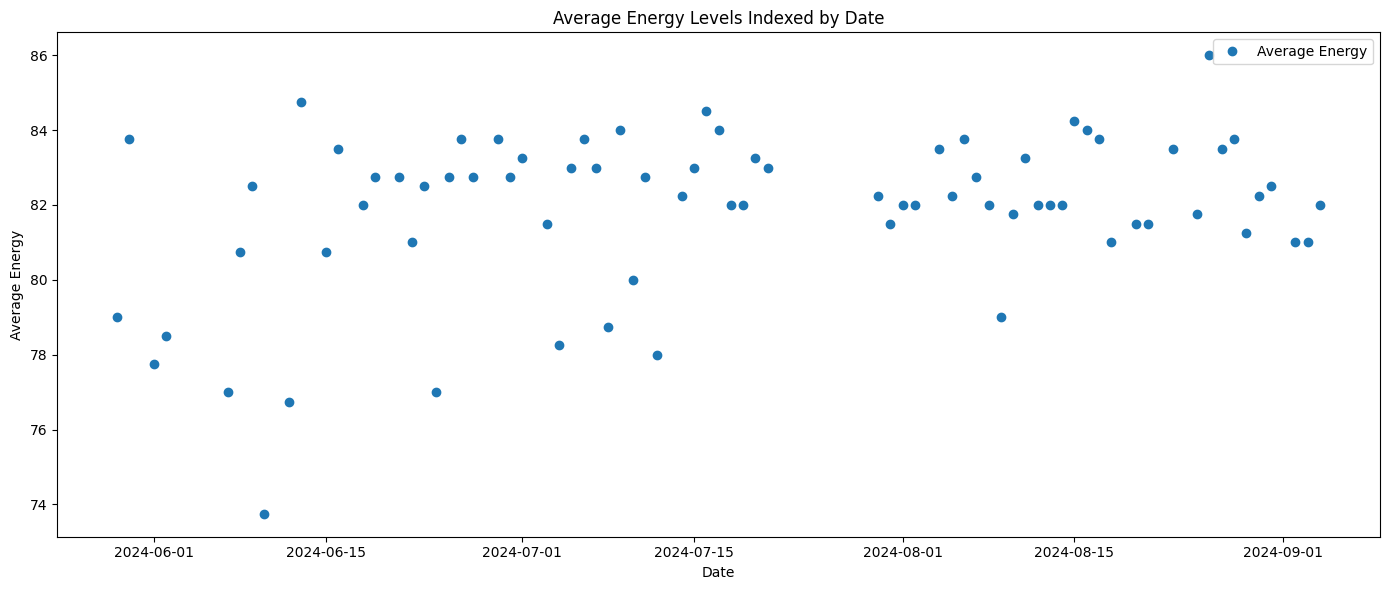

Pearson correlation between shifted masturbate_before_sleep and average energy levels: -0.315
P-value: 0.006


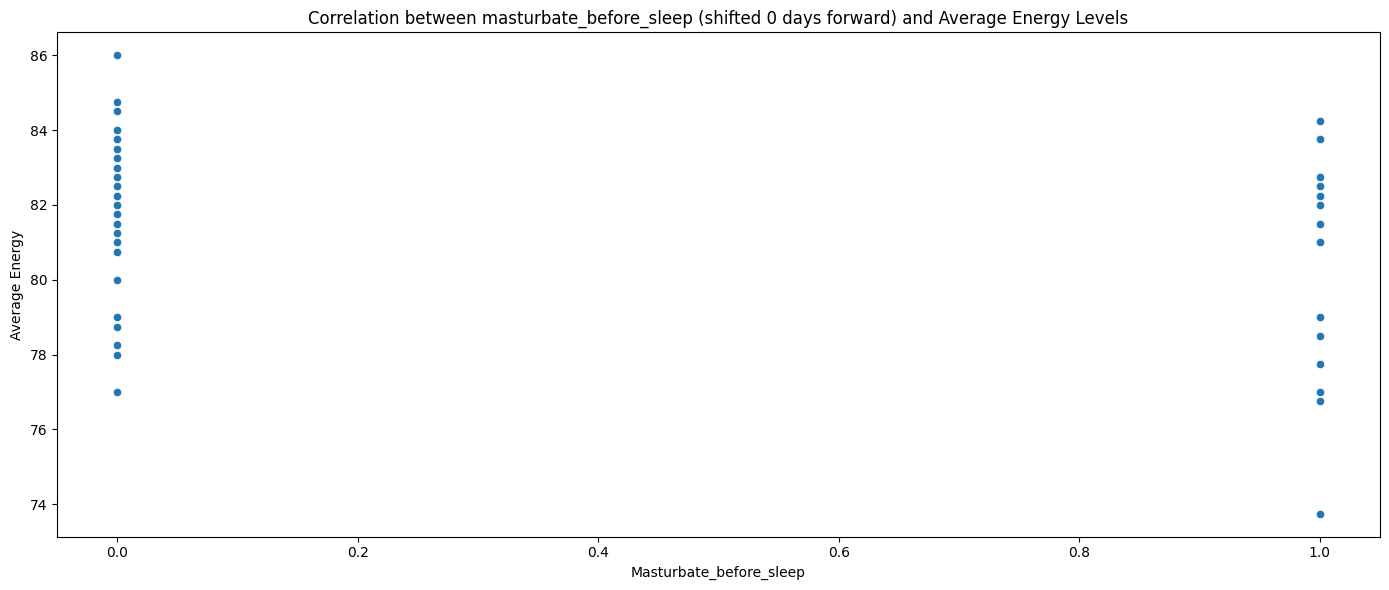

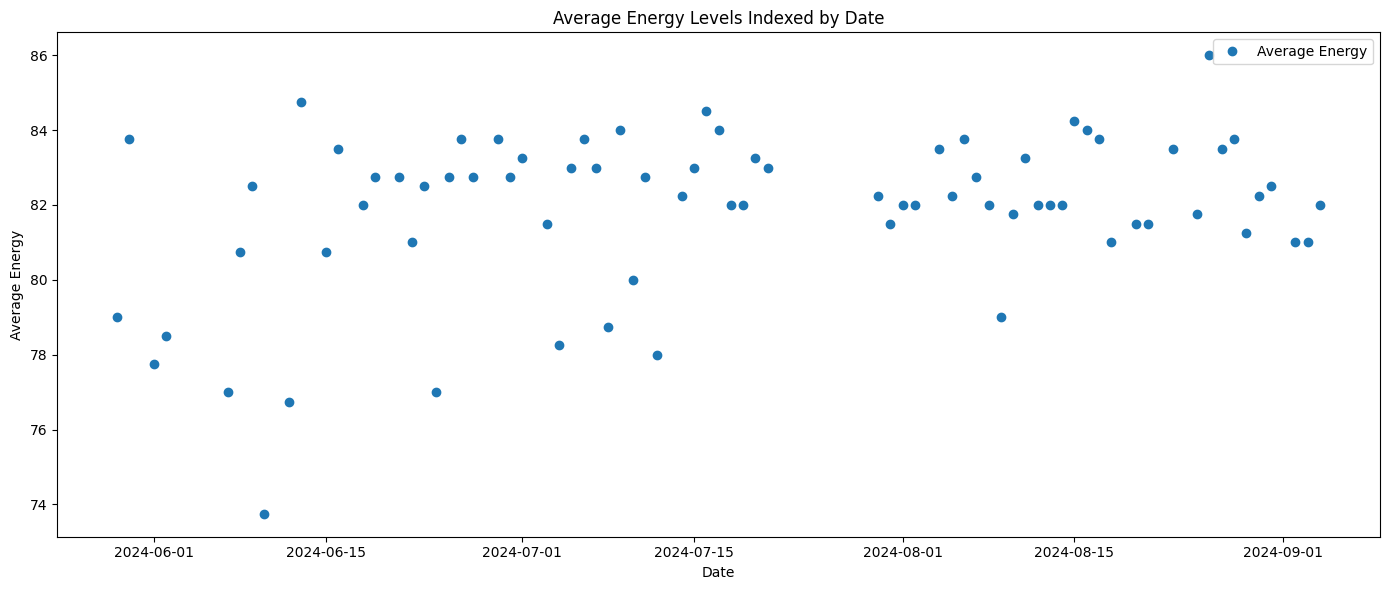

Pearson correlation between shifted melatonin and average energy levels: 0.133
P-value: 0.258


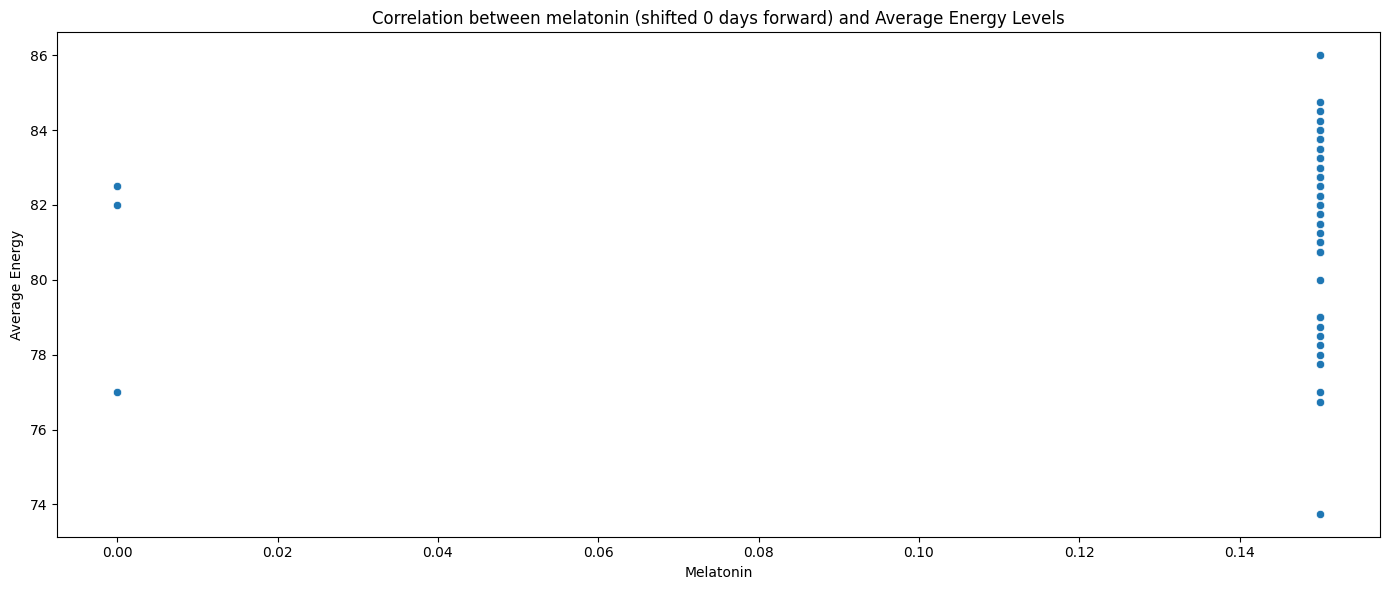

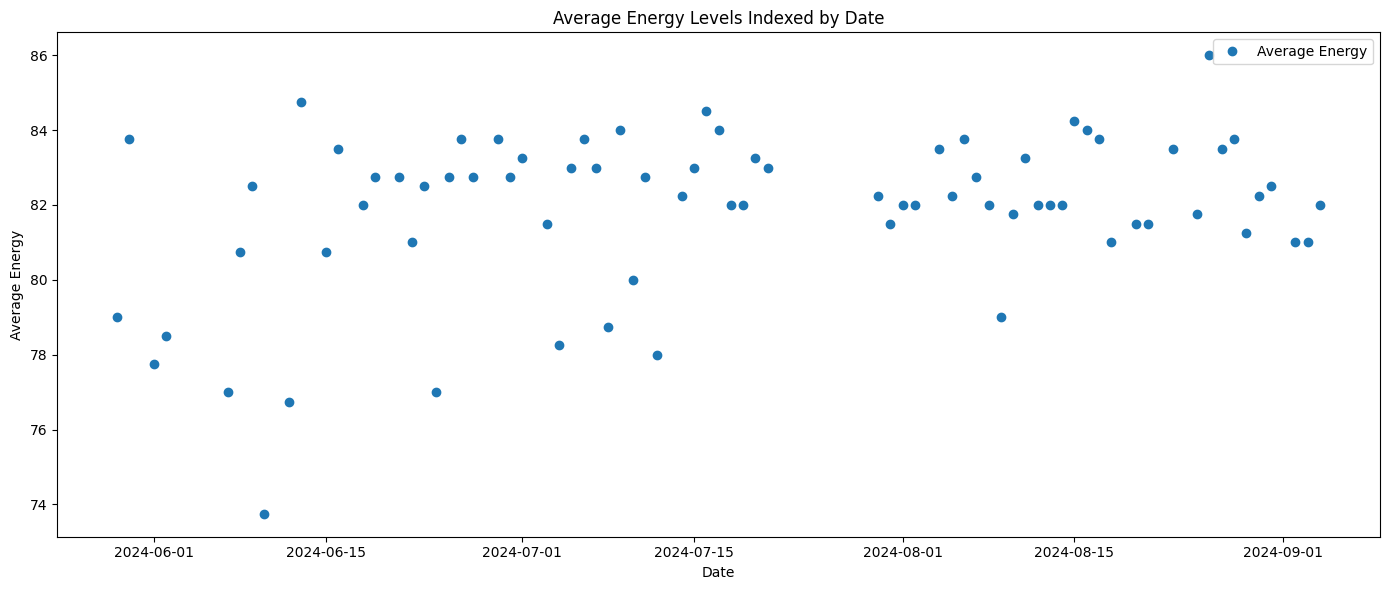

Pearson correlation between shifted melatonin_randomized and average energy levels: -0.249
P-value: 0.251


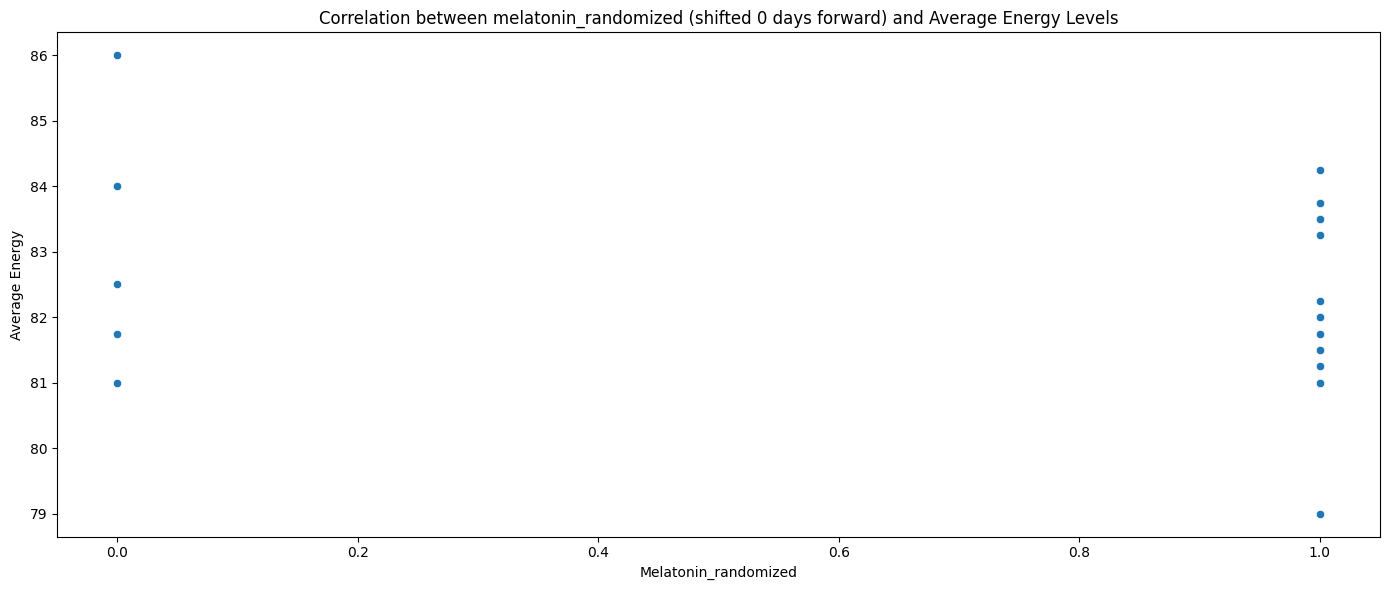

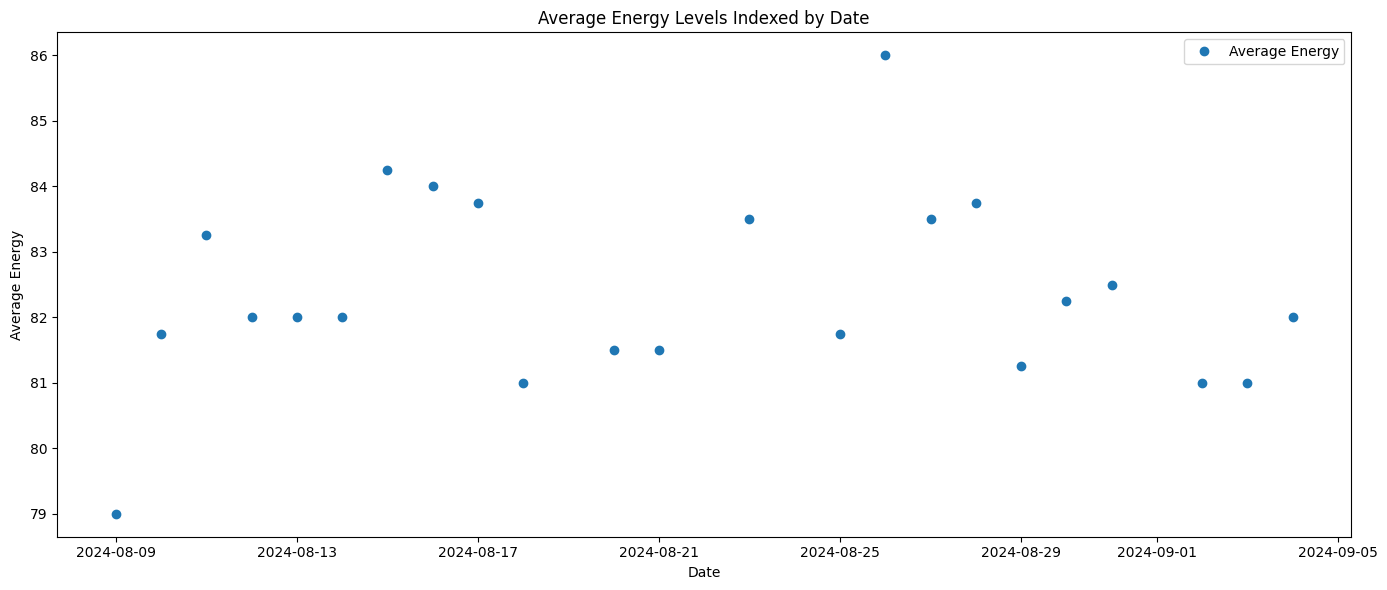

Pearson correlation between shifted caffeine and average energy levels: -0.081
P-value: 0.492


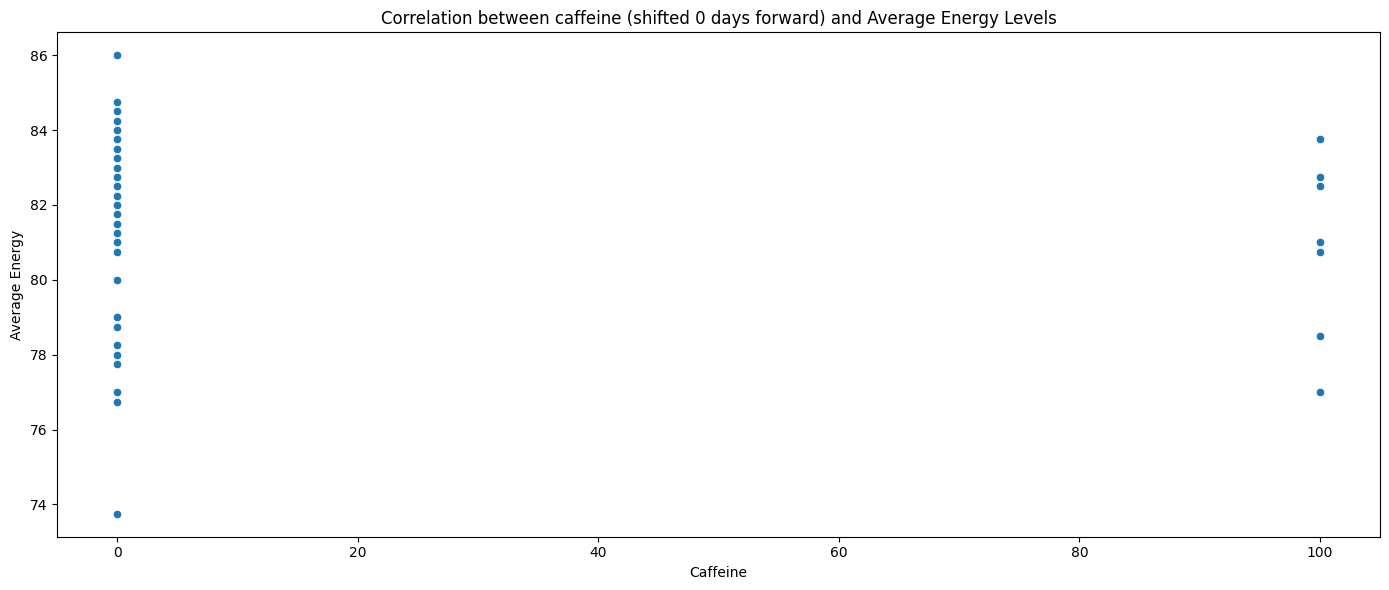

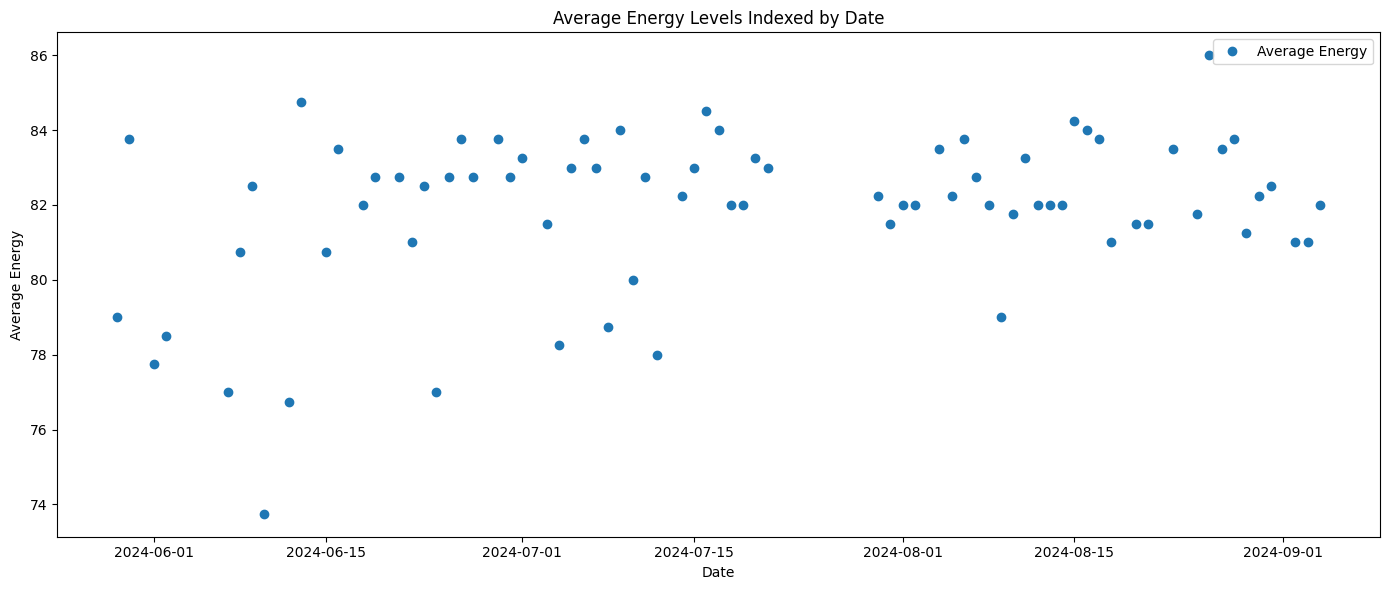

Pearson correlation between shifted porn and average energy levels: -0.105
P-value: 0.372


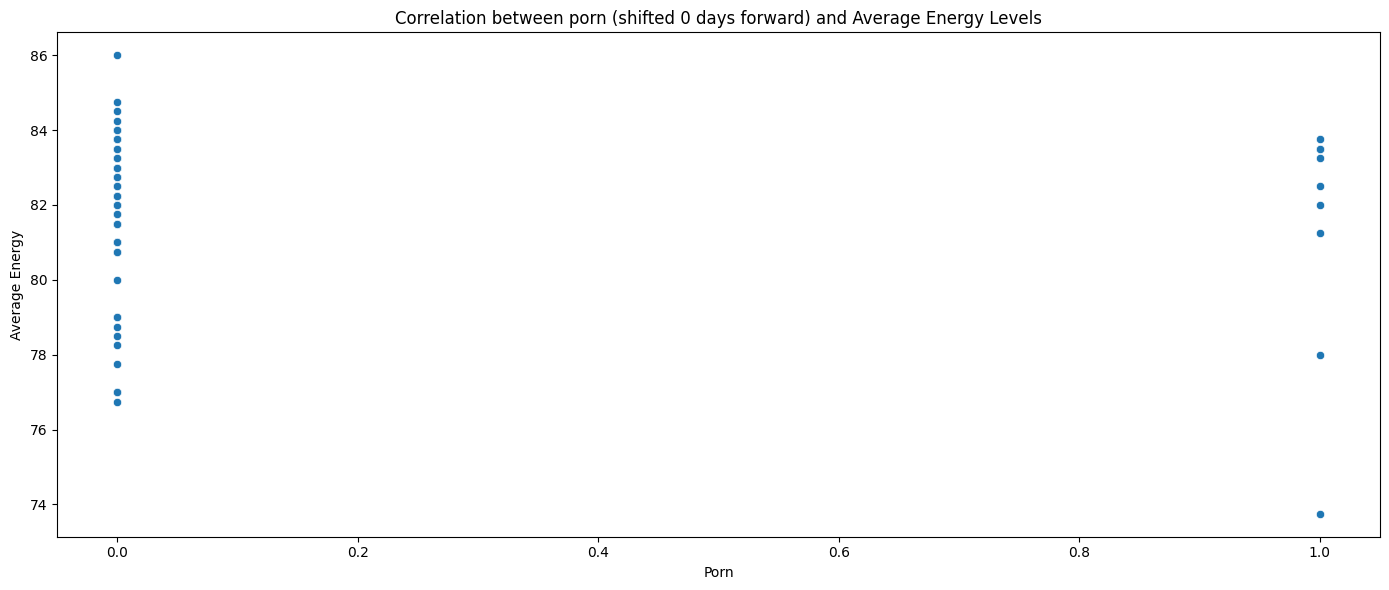

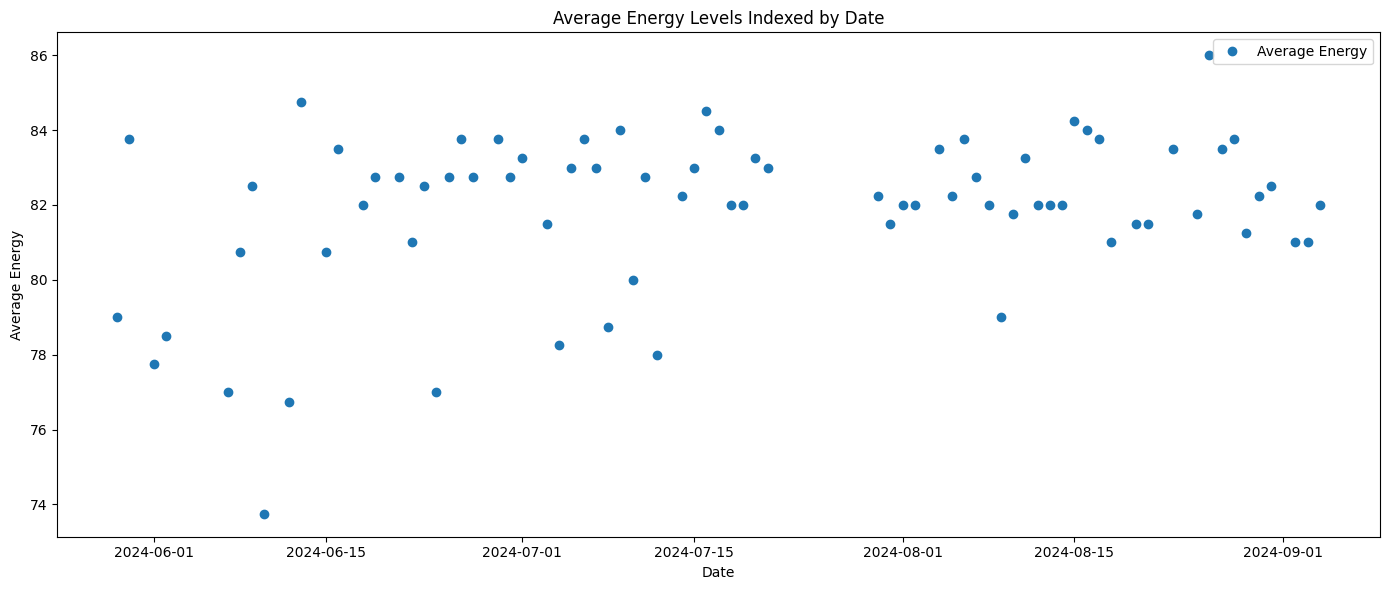

In [131]:
# Note add mthylphenidate from calendar
for column in ['sleep_duration', 'potassium', 'iodine', 'omega3', 'vitamin_d', 'creatine_randomized', 'masturbation', 'masturbate_before_sleep', 'melatonin', 'melatonin_randomized', 'caffeine', 'porn']: # NOTE: 'time in bed' was apparently a column, but it is gone now'
    if column == 'time_in_bed':
        analyze_energy_levels_correlation(filtered_data, '2024-05-29', '2024-06-28', column)
    else:
        # TODO: shift some vars, but not others?
        analyze_energy_levels_correlation(data, '2024-05-29', '2024-09-10', column)

Pearson correlation between sleep_duration shifted by -1 days forward and average energy levels: 0.082
P-value: 0.492
Sample size: 73


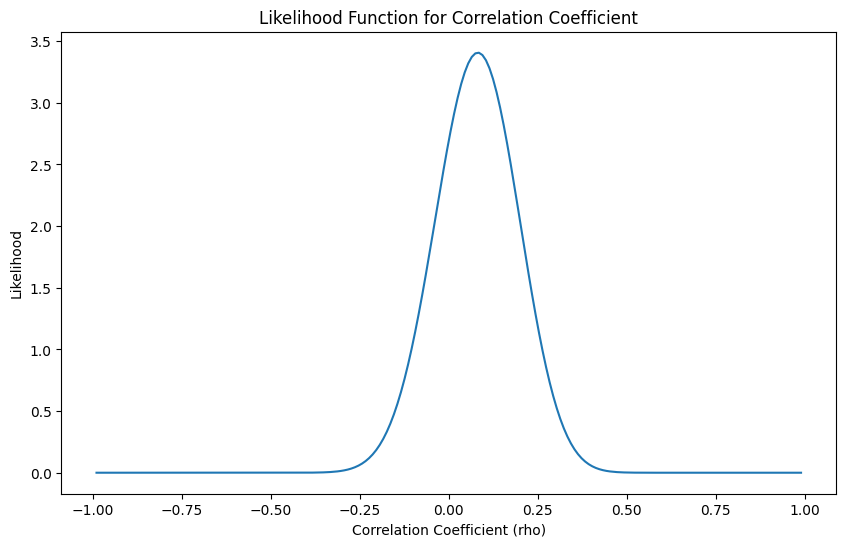

Pearson correlation between sleep_duration shifted by 0 days forward and average energy levels: -0.031
P-value: 0.794
Sample size: 74


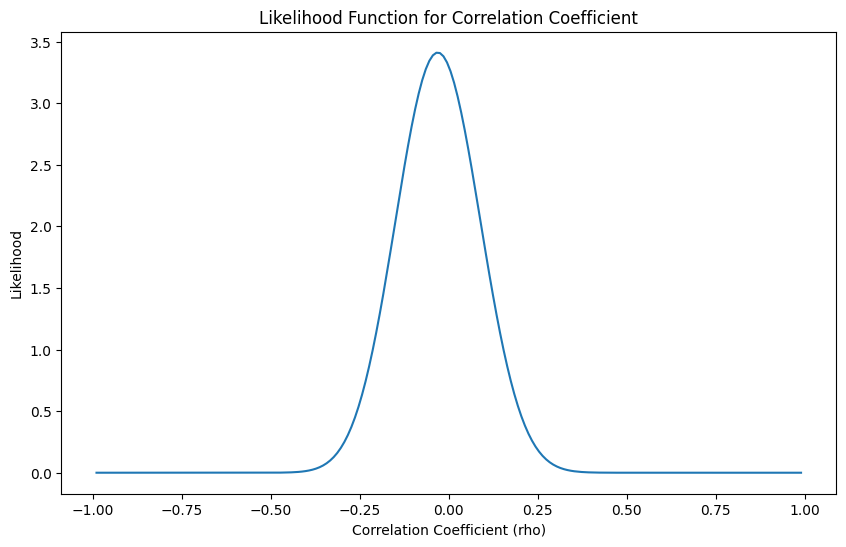

Pearson correlation between sleep_duration shifted by 1 days forward and average energy levels: 0.052
P-value: 0.667
Sample size: 72


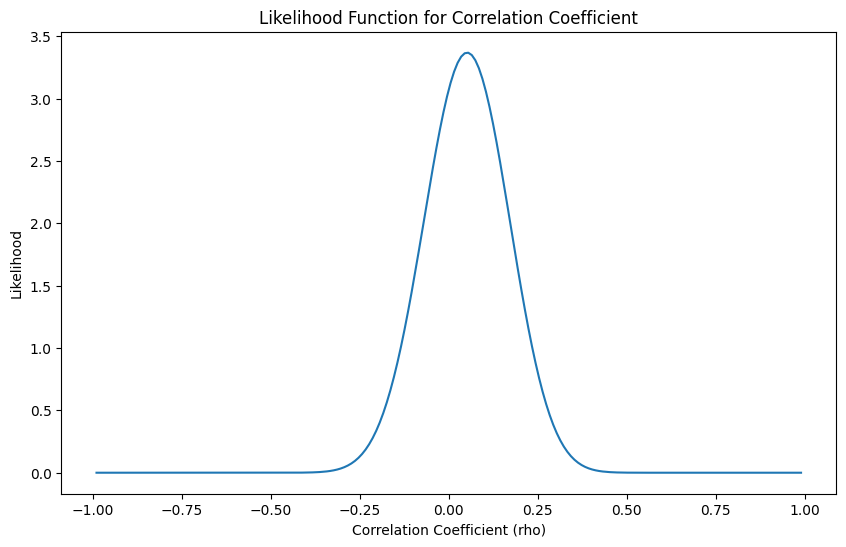

Pearson correlation between potassium shifted by -1 days forward and average energy levels: -0.181
P-value: 0.329
Sample size: 31


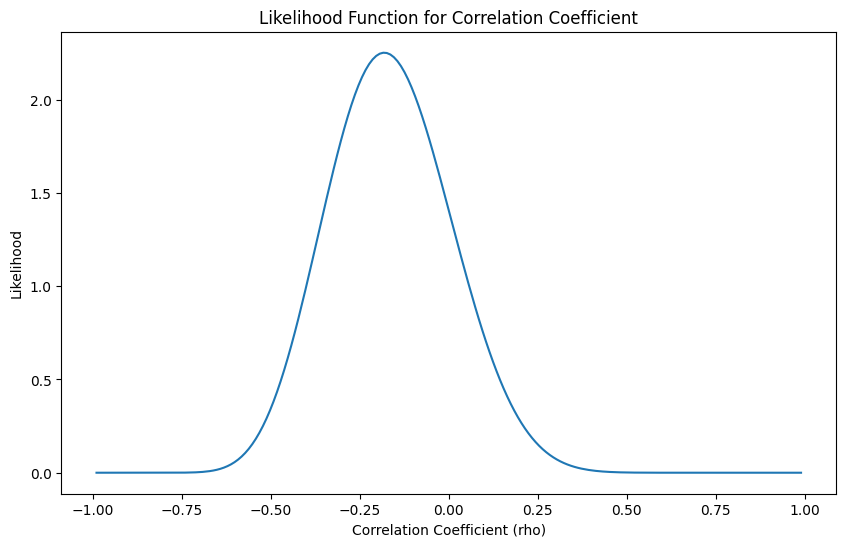

Pearson correlation between potassium shifted by 0 days forward and average energy levels: -0.028
P-value: 0.877
Sample size: 32


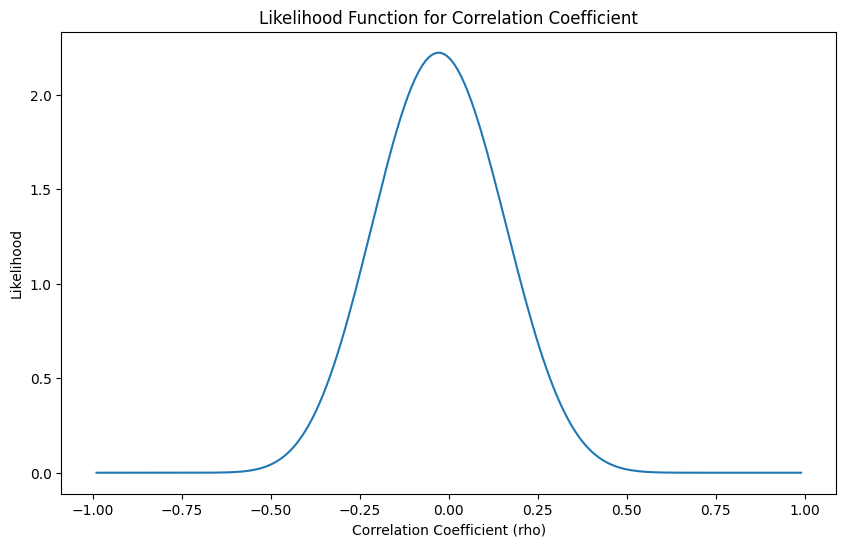

Pearson correlation between potassium shifted by 1 days forward and average energy levels: -0.056
P-value: 0.763
Sample size: 31


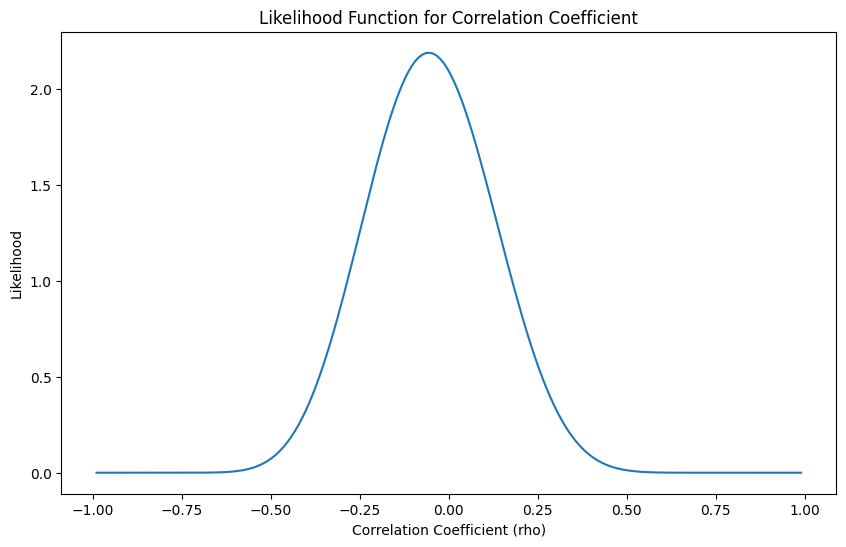

Pearson correlation between iodine shifted by -1 days forward and average energy levels: -0.089
P-value: 0.452
Sample size: 73


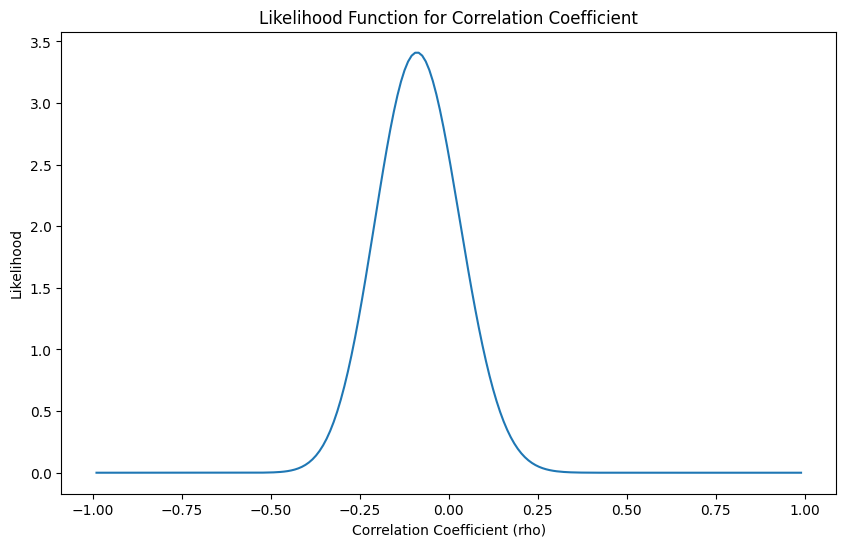

Pearson correlation between iodine shifted by 0 days forward and average energy levels: 0.013
P-value: 0.913
Sample size: 74


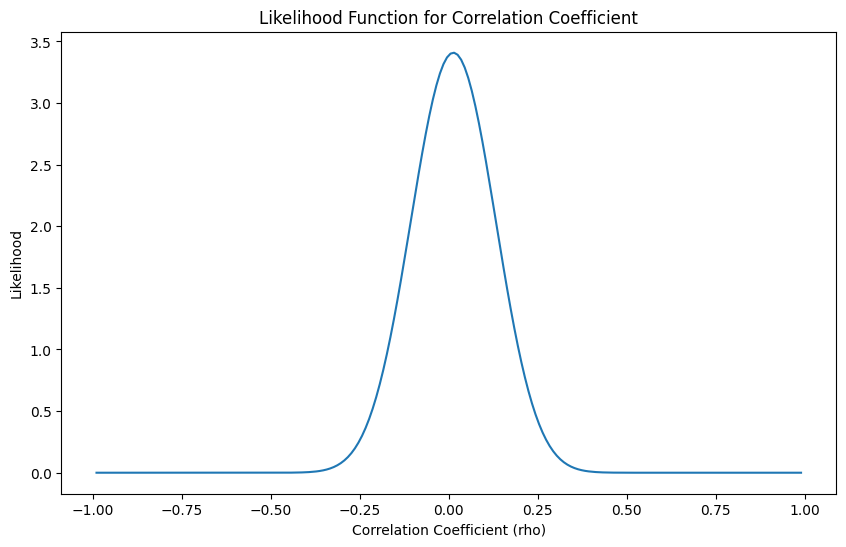

Pearson correlation between iodine shifted by 1 days forward and average energy levels: 0.006
P-value: 0.960
Sample size: 72


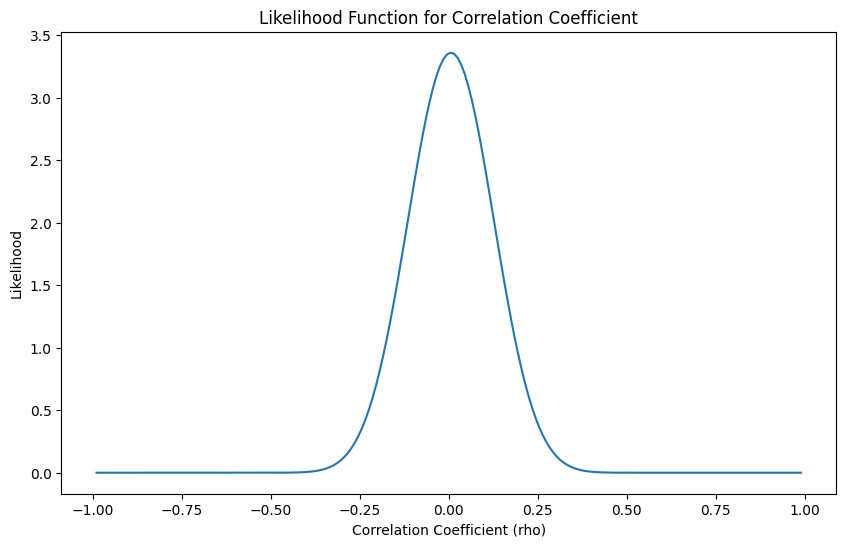

Pearson correlation between omega3 shifted by -1 days forward and average energy levels: -0.217
P-value: 0.078
Sample size: 67


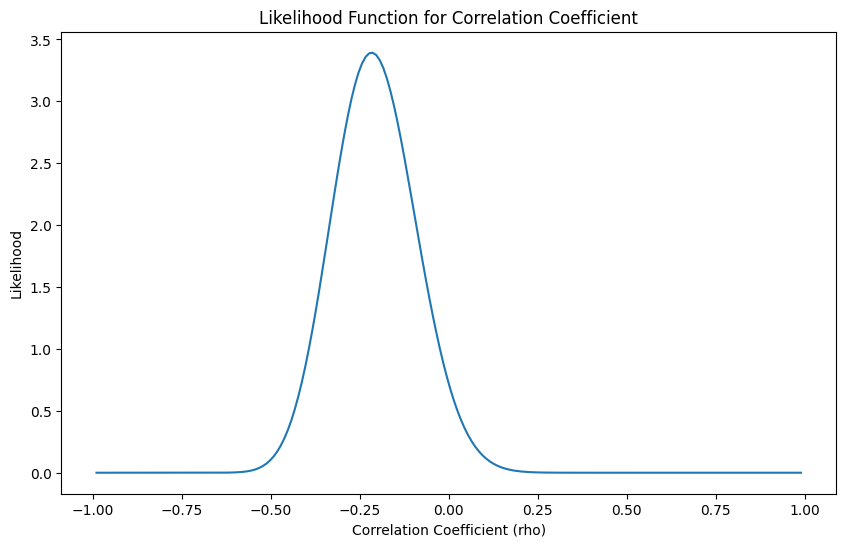

Pearson correlation between omega3 shifted by 0 days forward and average energy levels: -0.032
P-value: 0.796
Sample size: 68


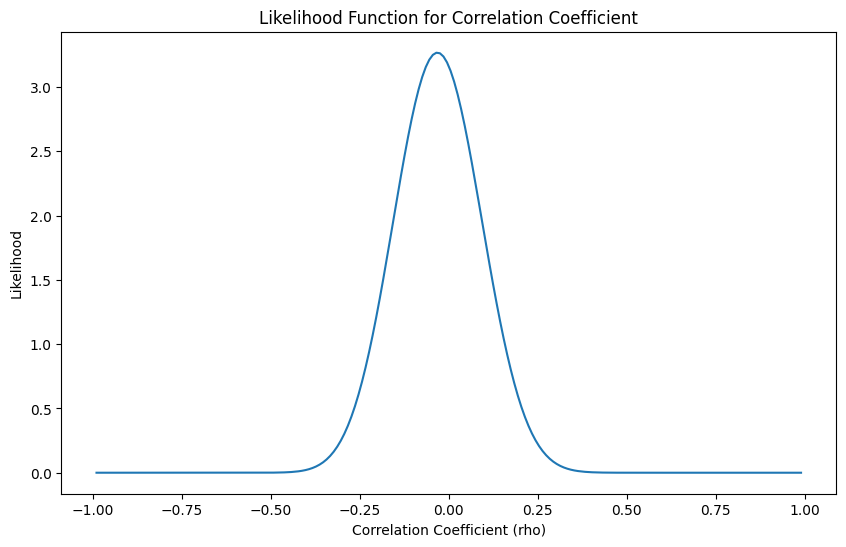

Pearson correlation between omega3 shifted by 1 days forward and average energy levels: 0.261
P-value: 0.034
Sample size: 66


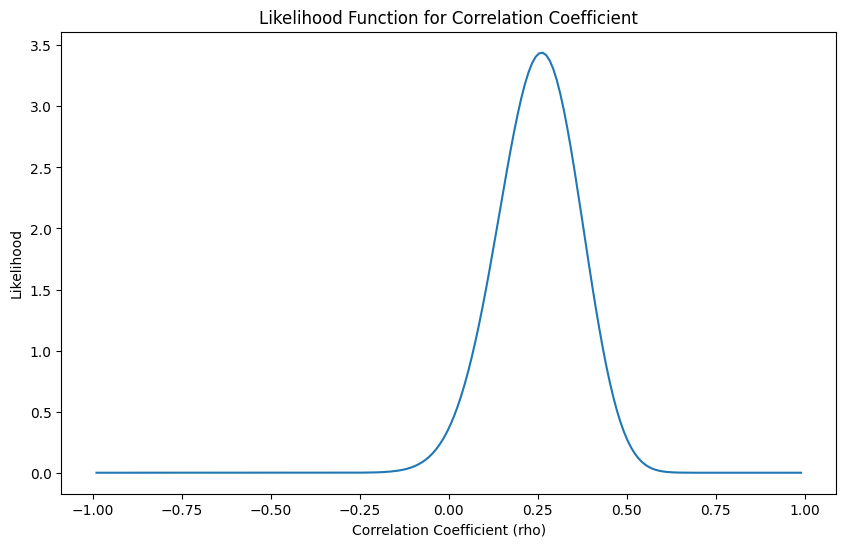

Pearson correlation between vitamin_d shifted by -1 days forward and average energy levels: -0.243
P-value: 0.048
Sample size: 67


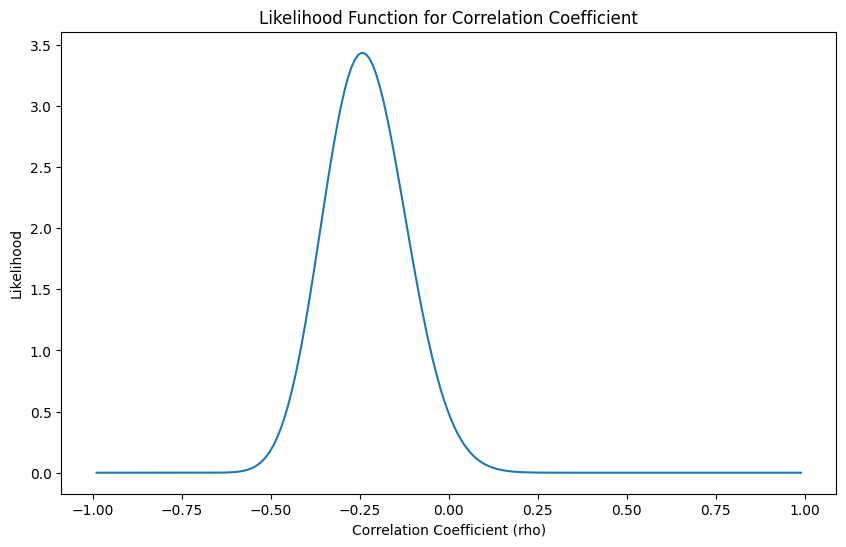

Pearson correlation between vitamin_d shifted by 0 days forward and average energy levels: 0.012
P-value: 0.921
Sample size: 68


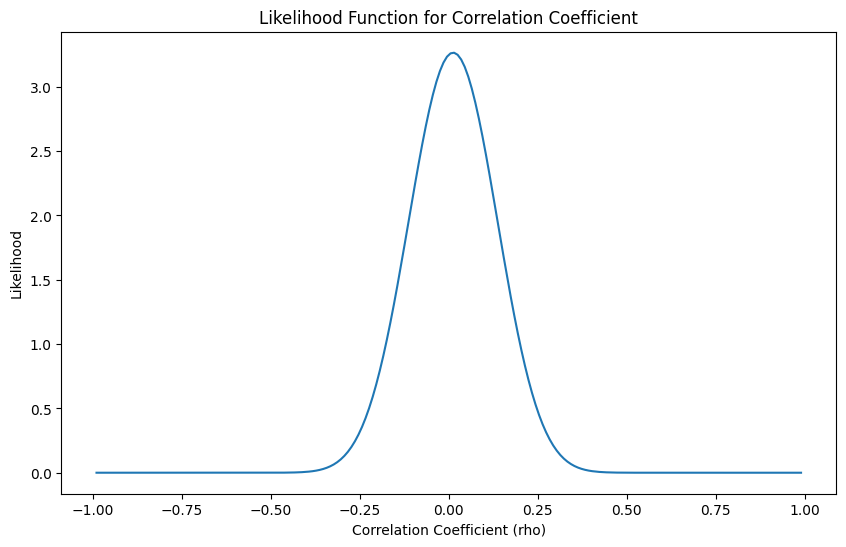

Pearson correlation between vitamin_d shifted by 1 days forward and average energy levels: 0.057
P-value: 0.647
Sample size: 66


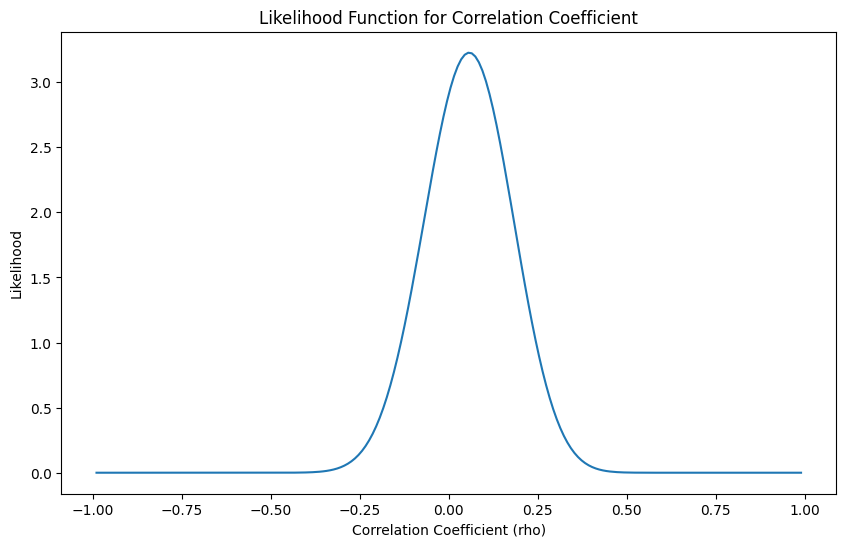

Pearson correlation between creatine_randomized shifted by -1 days forward and average energy levels: -0.177
P-value: 0.430
Sample size: 22


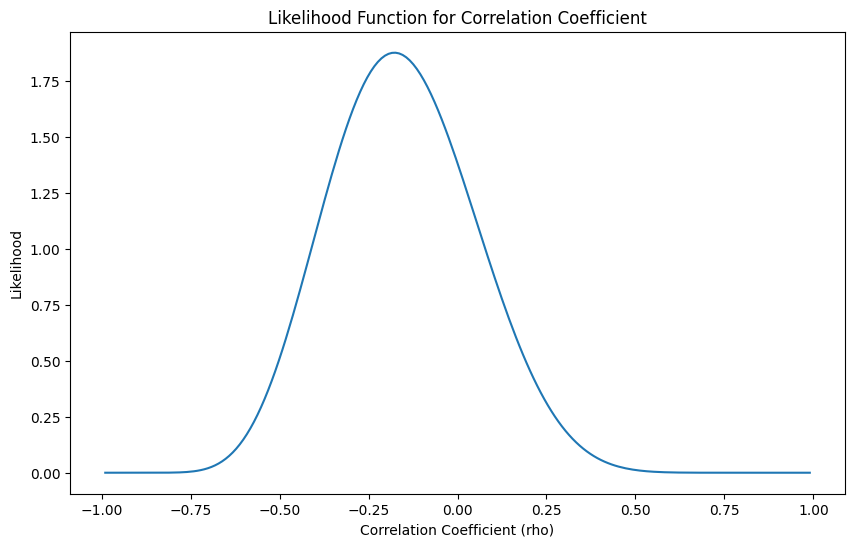

Pearson correlation between creatine_randomized shifted by 0 days forward and average energy levels: -0.027
P-value: 0.902
Sample size: 23


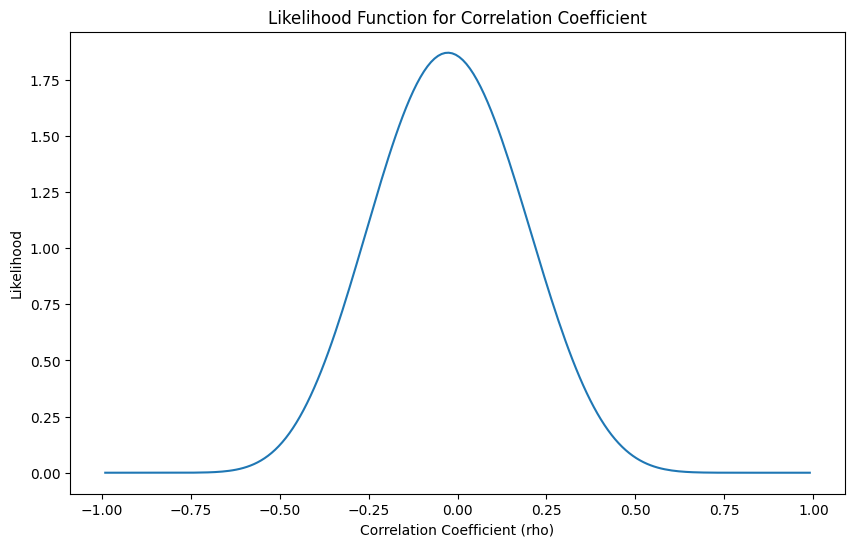

Pearson correlation between creatine_randomized shifted by 1 days forward and average energy levels: 0.259
P-value: 0.258
Sample size: 21


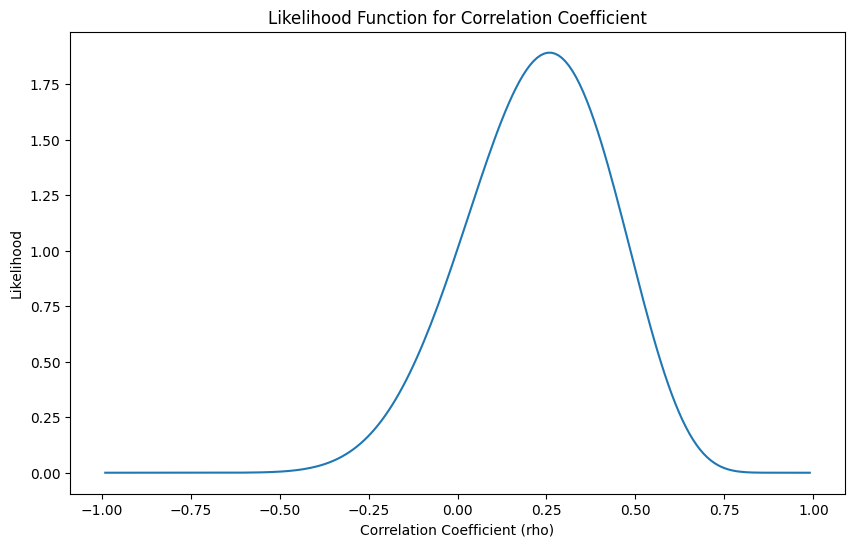

Pearson correlation between masturbation shifted by -1 days forward and average energy levels: -0.174
P-value: 0.141
Sample size: 73


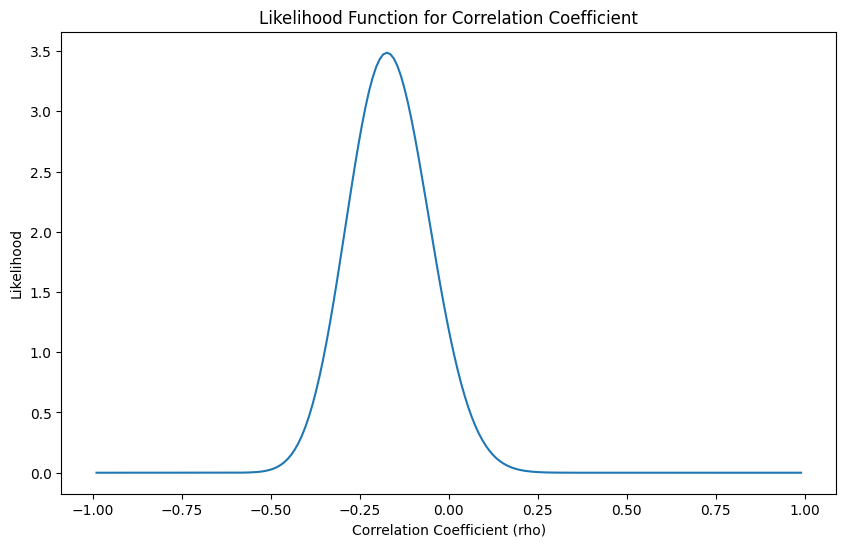

Pearson correlation between masturbation shifted by 0 days forward and average energy levels: -0.171
P-value: 0.145
Sample size: 74


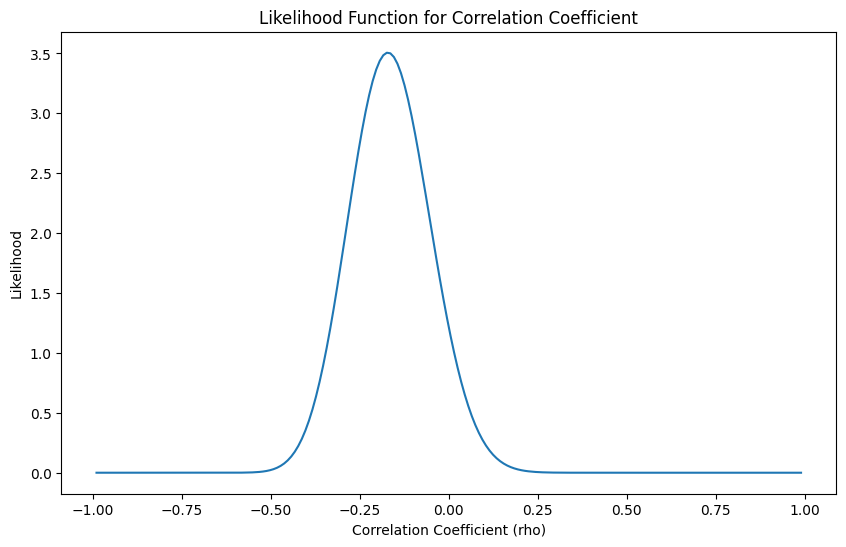

Pearson correlation between masturbation shifted by 1 days forward and average energy levels: -0.112
P-value: 0.350
Sample size: 72


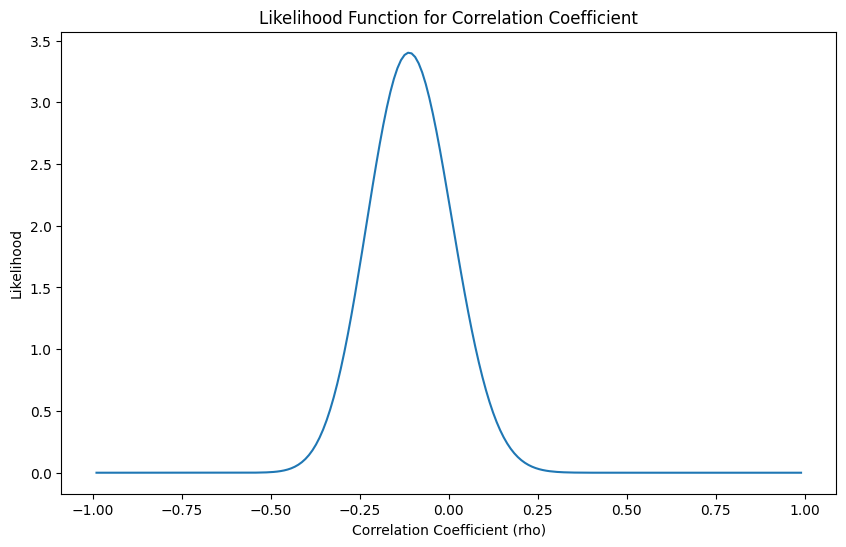

Pearson correlation between masturbate_before_sleep shifted by -1 days forward and average energy levels: -0.180
P-value: 0.127
Sample size: 73


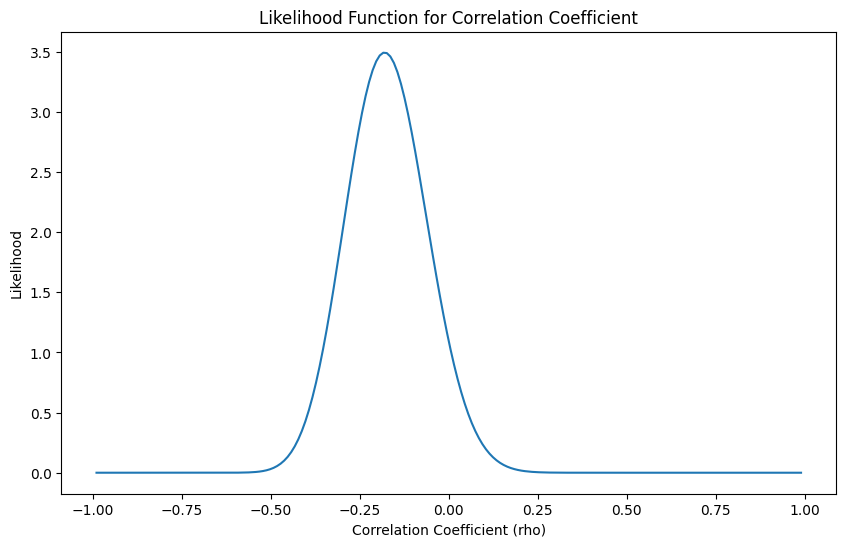

Pearson correlation between masturbate_before_sleep shifted by 0 days forward and average energy levels: -0.315
P-value: 0.006
Sample size: 74


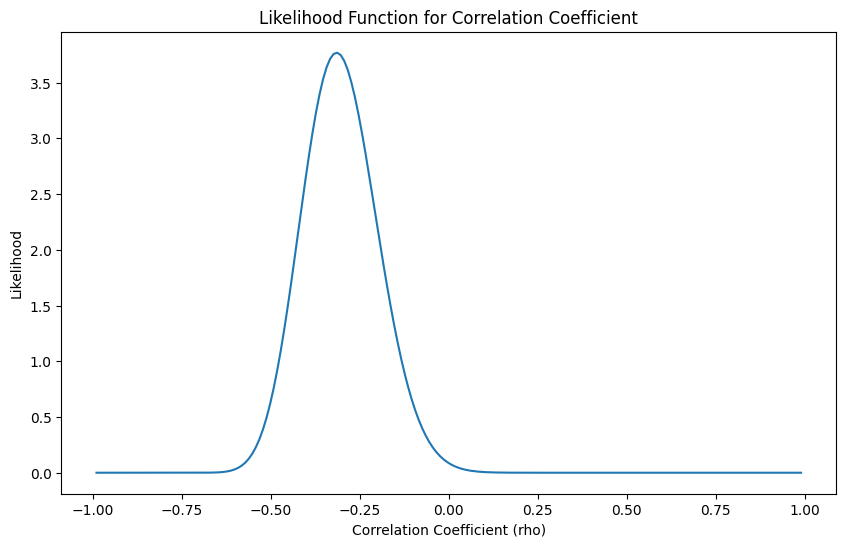

Pearson correlation between masturbate_before_sleep shifted by 1 days forward and average energy levels: -0.090
P-value: 0.451
Sample size: 72


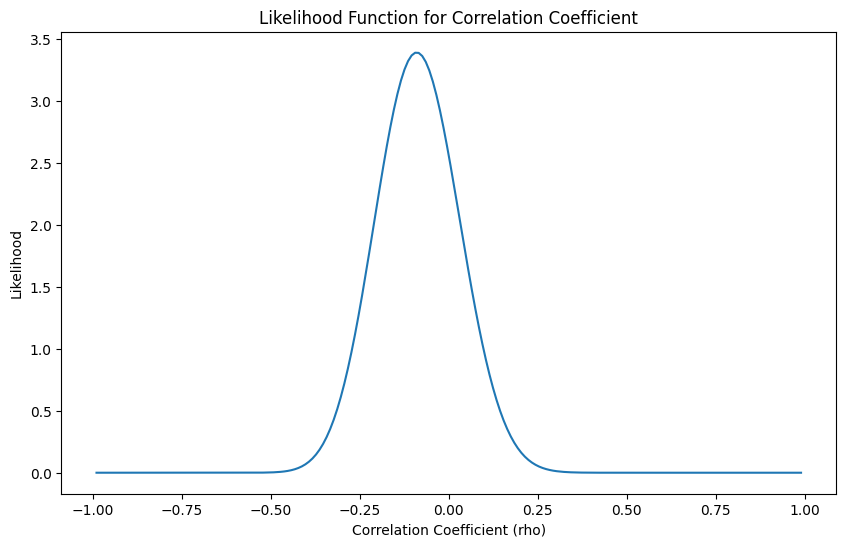

Pearson correlation between melatonin shifted by -1 days forward and average energy levels: 0.399
P-value: 0.000
Sample size: 73


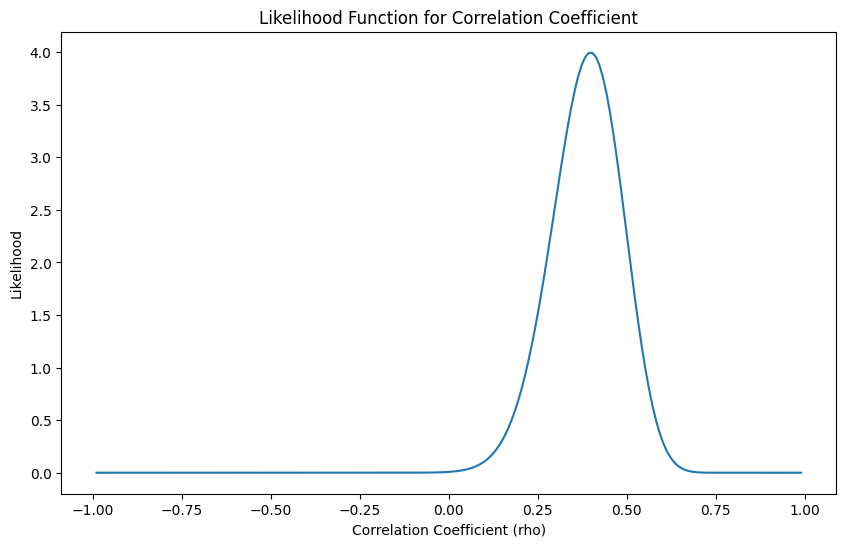

Pearson correlation between melatonin shifted by 0 days forward and average energy levels: 0.133
P-value: 0.258
Sample size: 74


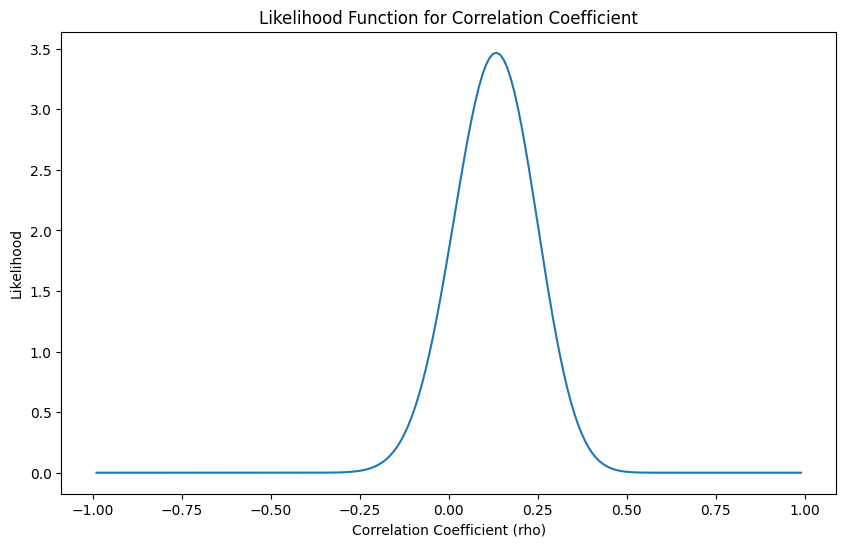

Pearson correlation between melatonin shifted by 1 days forward and average energy levels: 0.122
P-value: 0.306
Sample size: 72


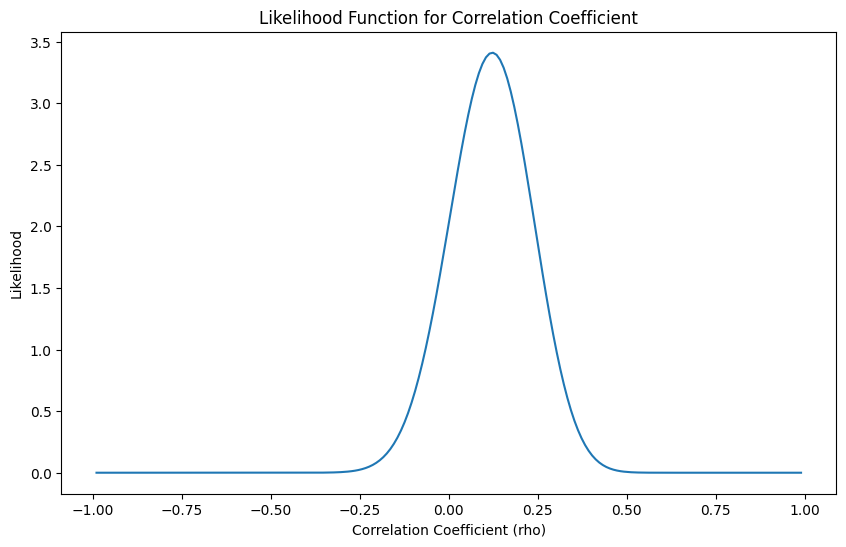

Pearson correlation between melatonin_randomized shifted by -1 days forward and average energy levels: -0.267
P-value: 0.230
Sample size: 22


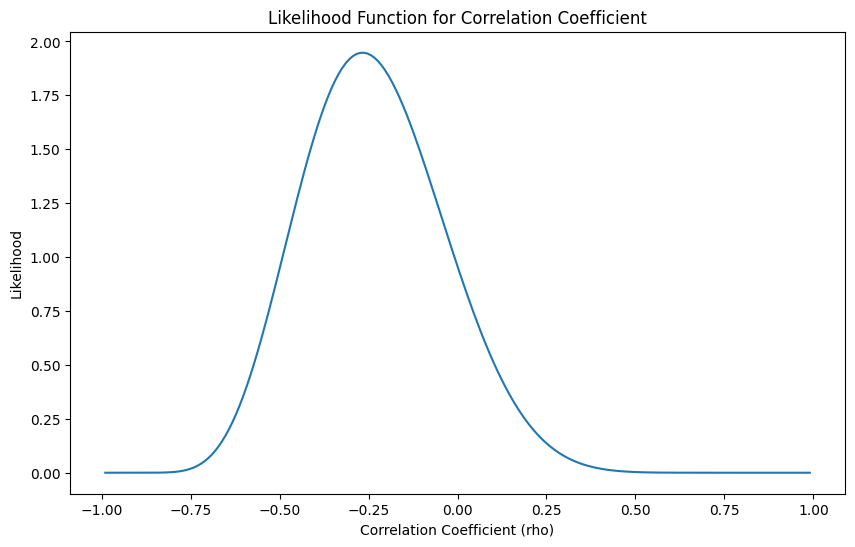

Pearson correlation between melatonin_randomized shifted by 0 days forward and average energy levels: -0.249
P-value: 0.251
Sample size: 23


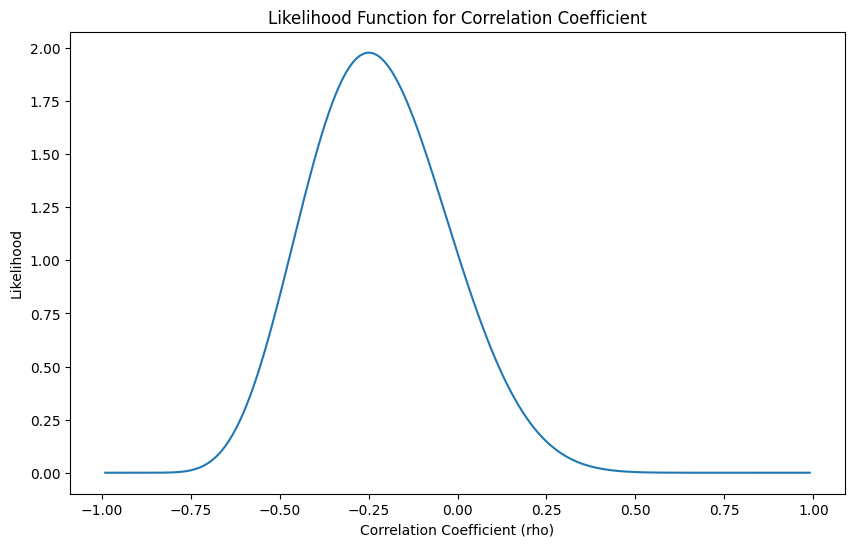

Pearson correlation between melatonin_randomized shifted by 1 days forward and average energy levels: -0.238
P-value: 0.300
Sample size: 21


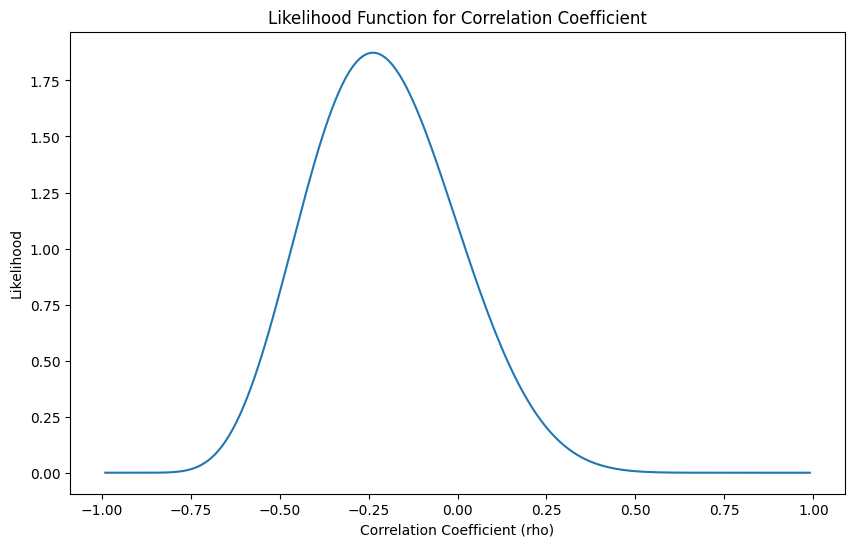

Pearson correlation between caffeine shifted by -1 days forward and average energy levels: -0.207
P-value: 0.079
Sample size: 73


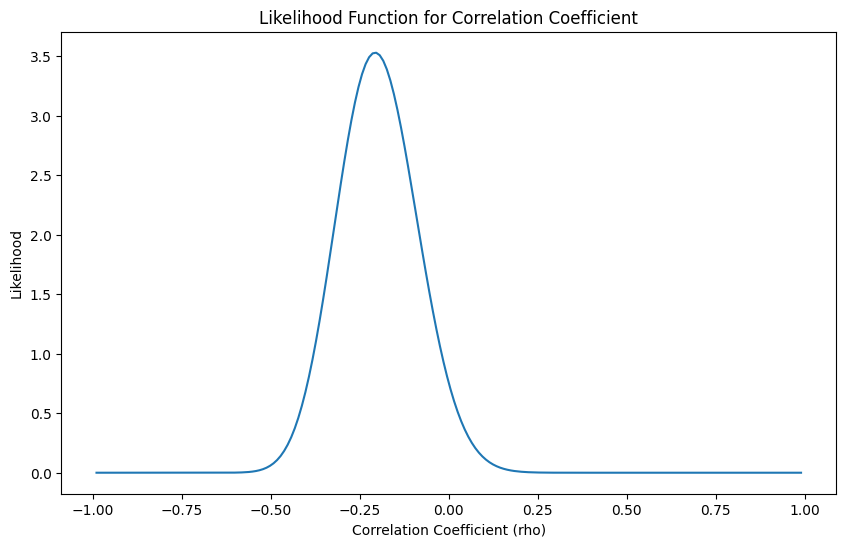

Pearson correlation between caffeine shifted by 0 days forward and average energy levels: -0.081
P-value: 0.492
Sample size: 74


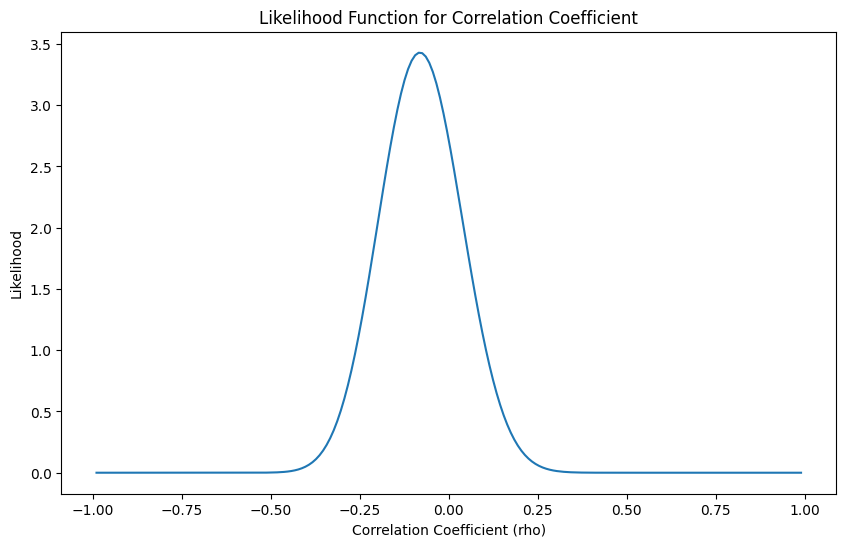

Pearson correlation between caffeine shifted by 1 days forward and average energy levels: -0.344
P-value: 0.003
Sample size: 72


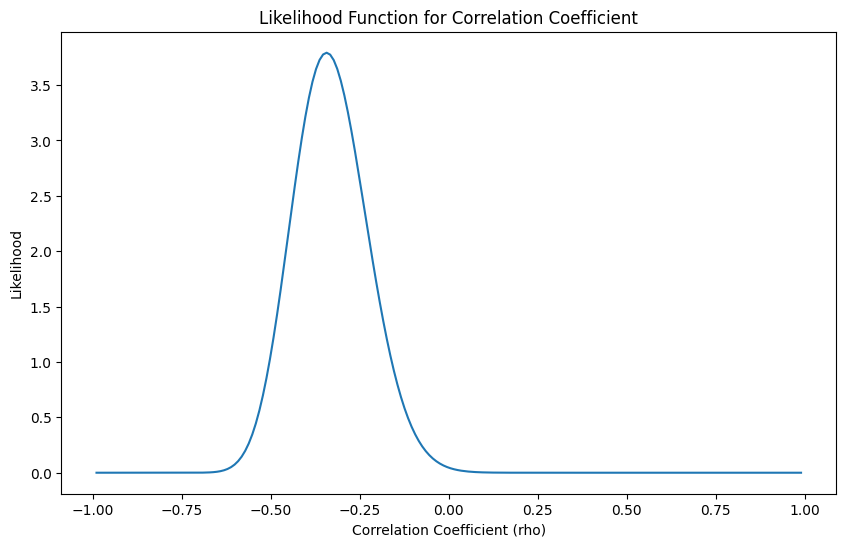

Pearson correlation between porn shifted by -1 days forward and average energy levels: -0.246
P-value: 0.036
Sample size: 73


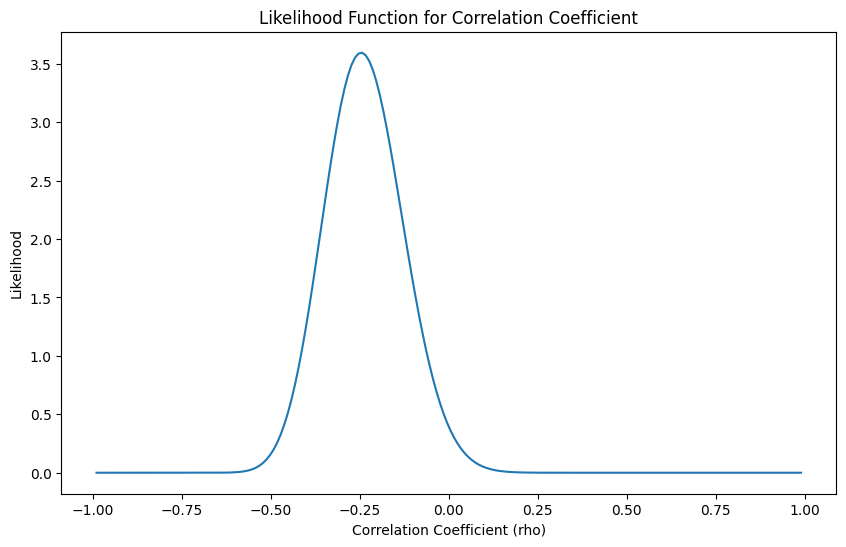

Pearson correlation between porn shifted by 0 days forward and average energy levels: -0.105
P-value: 0.372
Sample size: 74


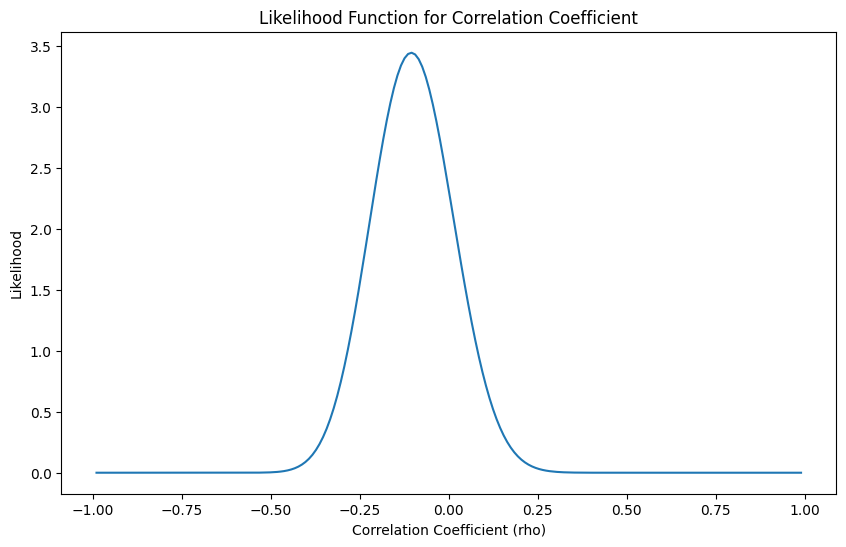

Pearson correlation between porn shifted by 1 days forward and average energy levels: 0.034
P-value: 0.777
Sample size: 72


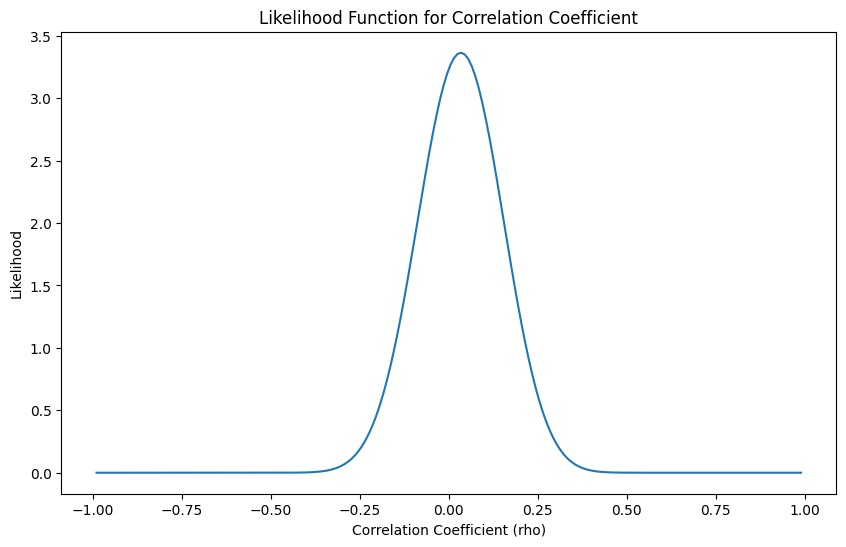

In [146]:
for column in ['sleep_duration', 'potassium', 'iodine', 'omega3', 'vitamin_d', 'creatine_randomized', 'masturbation', 'masturbate_before_sleep', 'melatonin', 'melatonin_randomized', 'caffeine', 'porn']: # NOTE: 'time in bed' was apparently a column, but it is gone now'
    start = '2024-05-29'
    end = '2024-09-10'
    if column == 'potassium':
        start = '2024-07-29' # changed randomization frequency here
    if column == 'omega3' or column == 'vitamin_d':
        start = '2024-06-9' # changed randomization here
    if column == 'creatine_randomized' or column == 'melatonin_randomized':
        start = '2024-08-09' # started to randomize these
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=-1)
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=0)
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=1)


Pearson correlation between shifted potassium and average energy levels: -0.083
P-value: 0.714


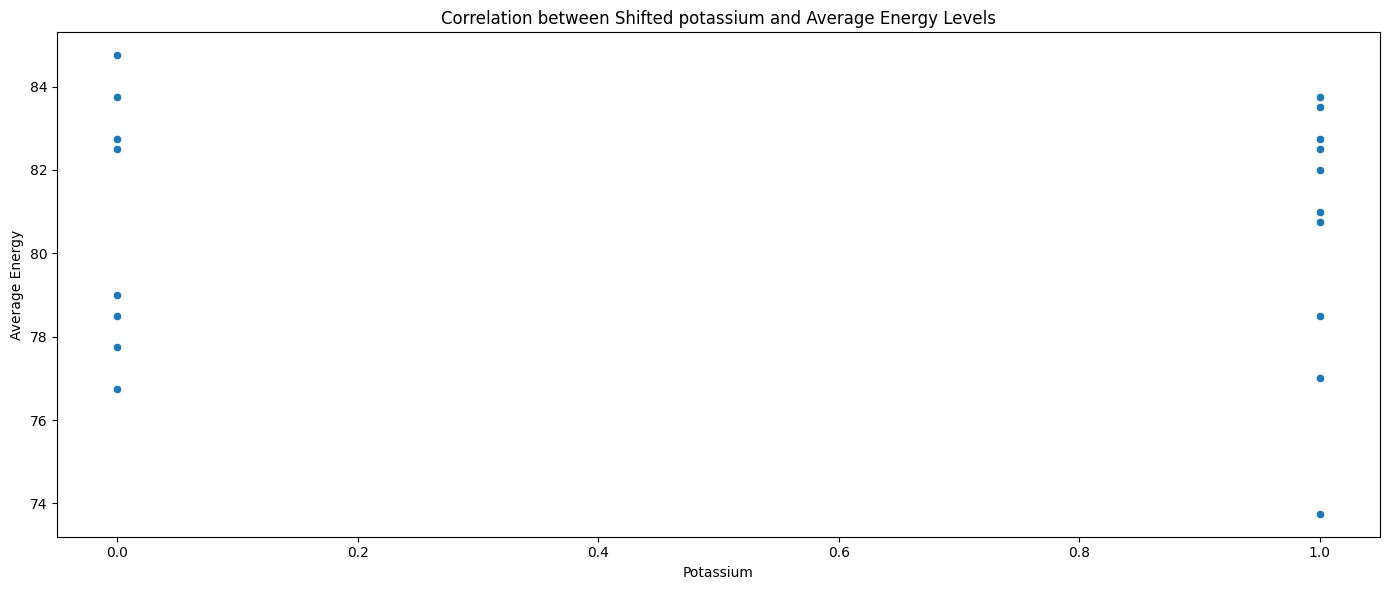

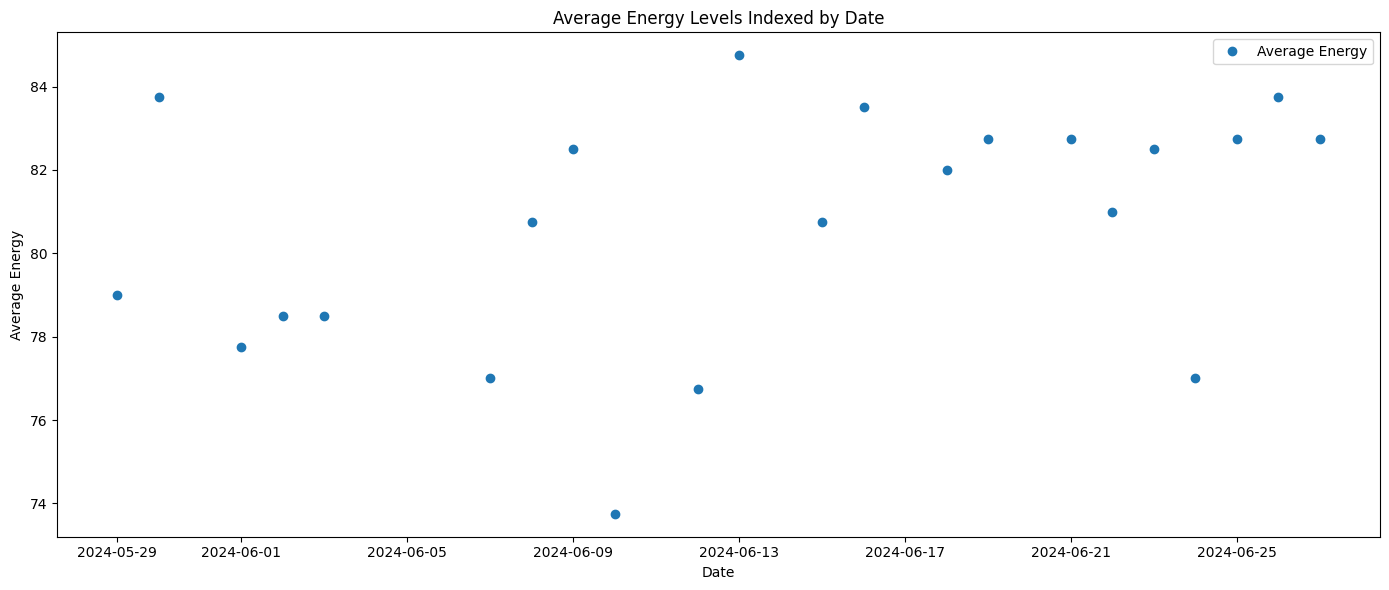

Pearson correlation between shifted omega3 and average energy levels: 0.177
P-value: 0.432


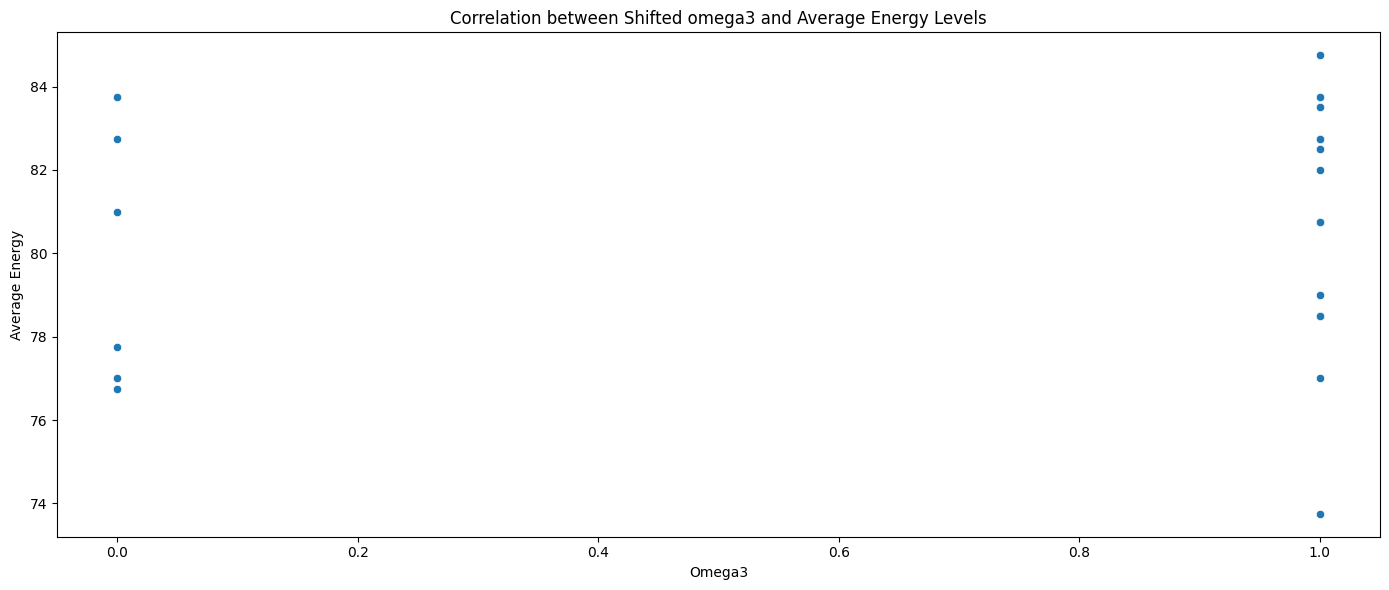

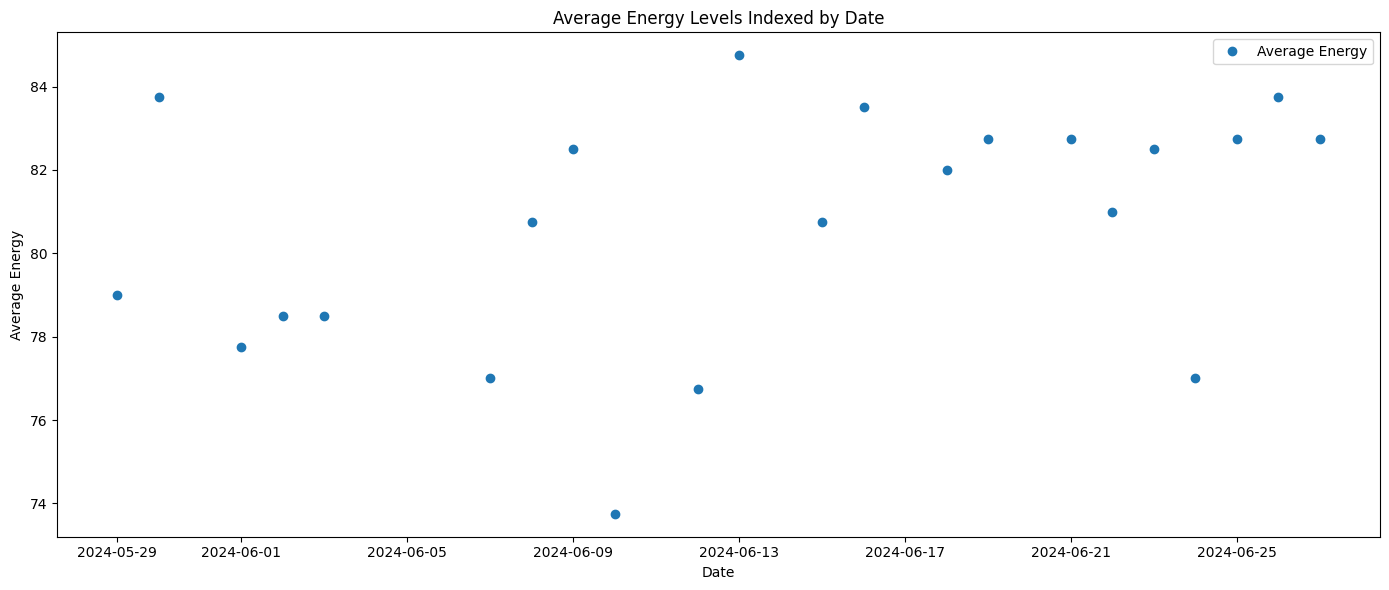

Pearson correlation between shifted grey and average energy levels: -0.225
P-value: 0.313


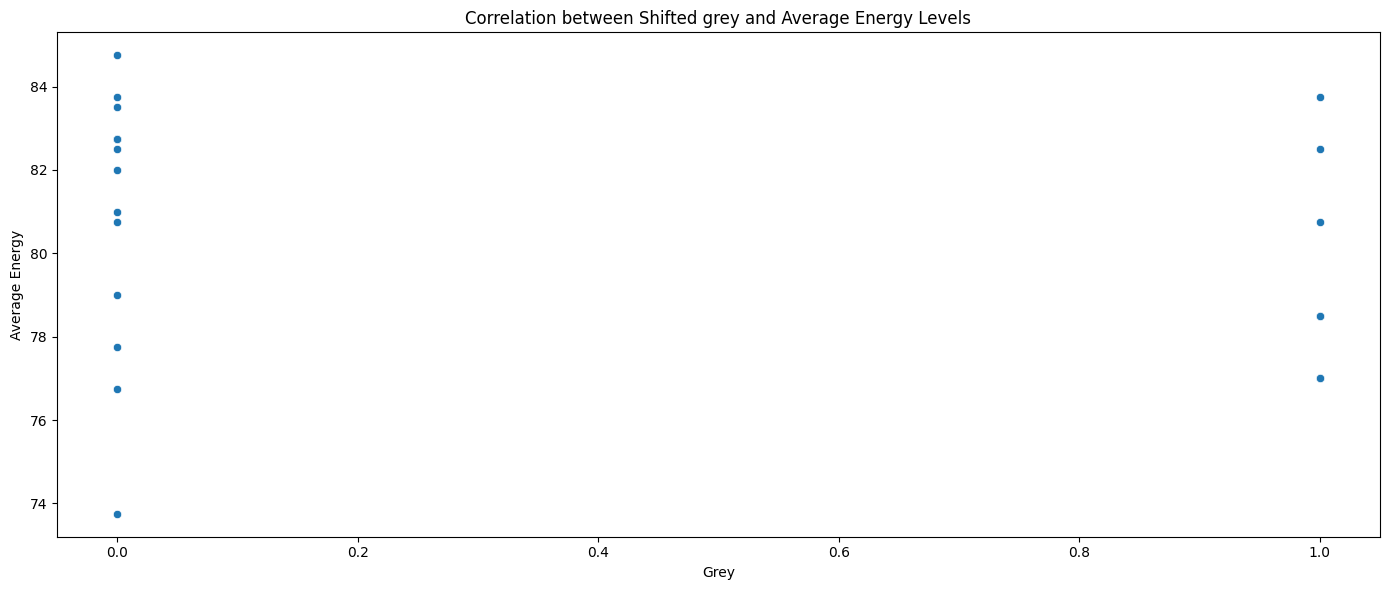

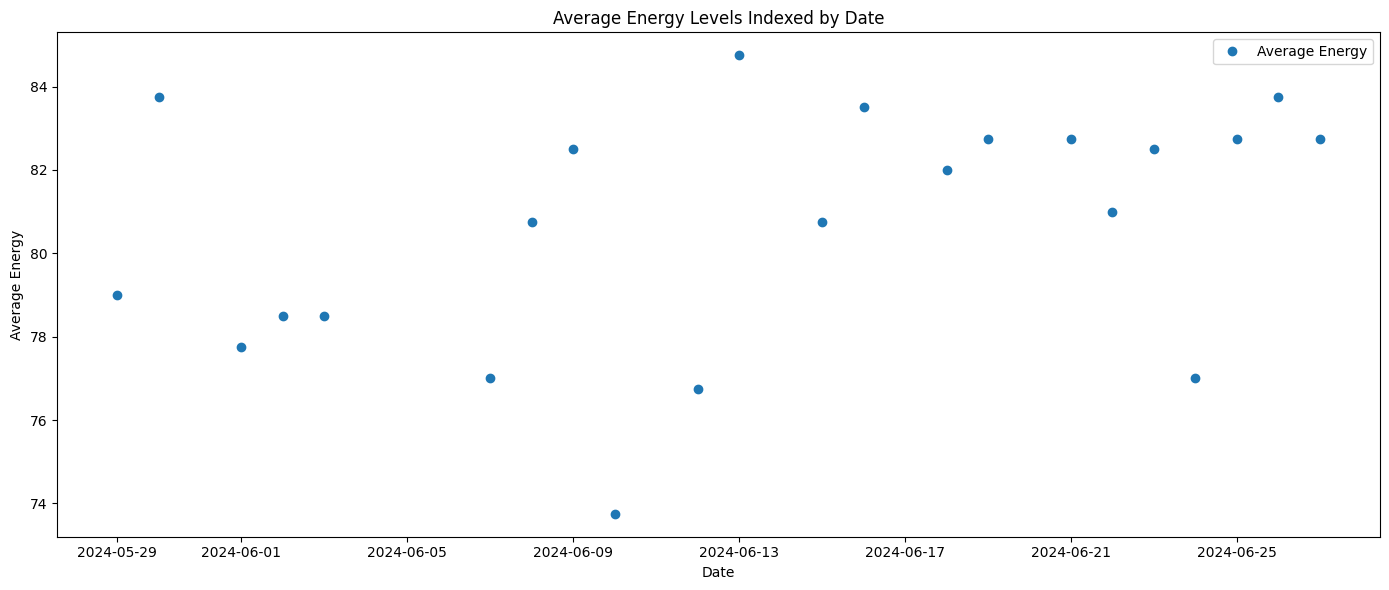

Pearson correlation between shifted vitamin_d and average energy levels: 0.024
P-value: 0.916


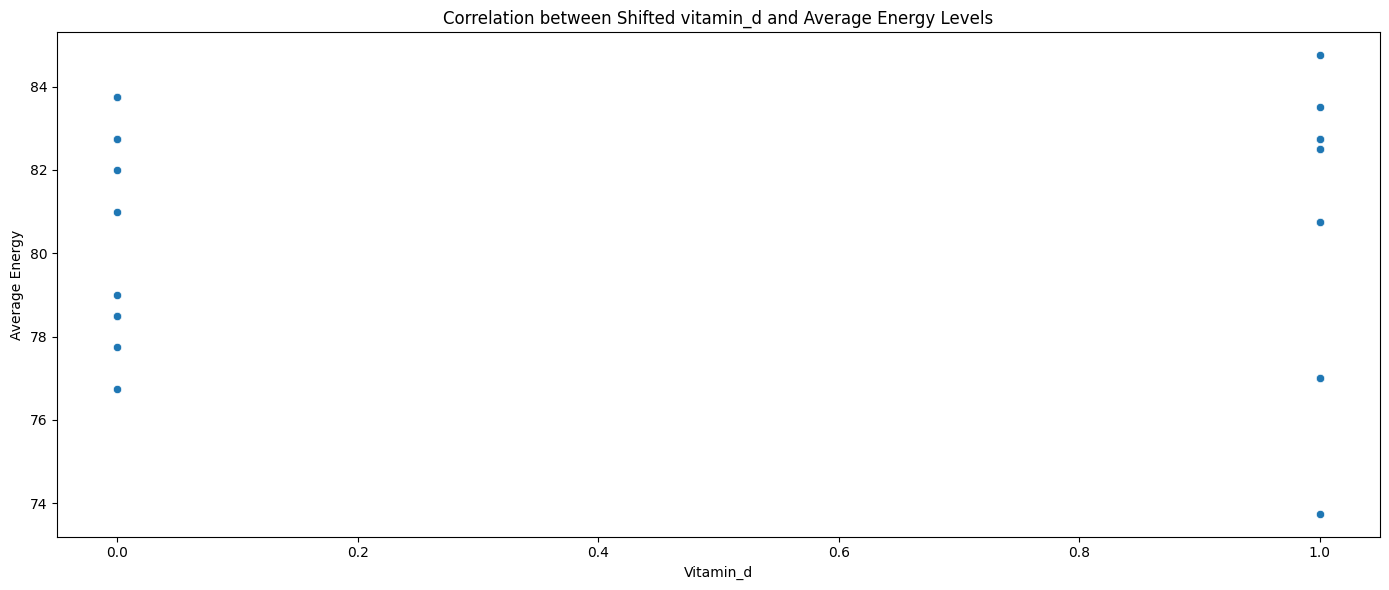

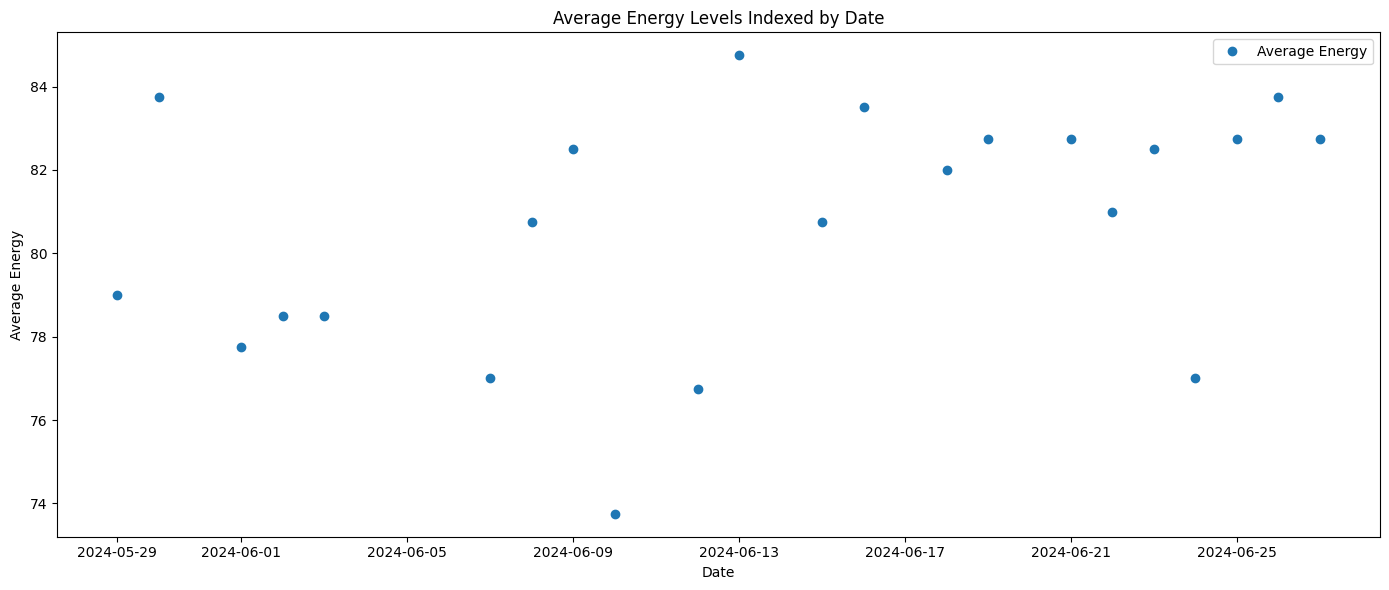

Pearson correlation between shifted methylphenidate and average energy levels: 0.250
P-value: 0.262


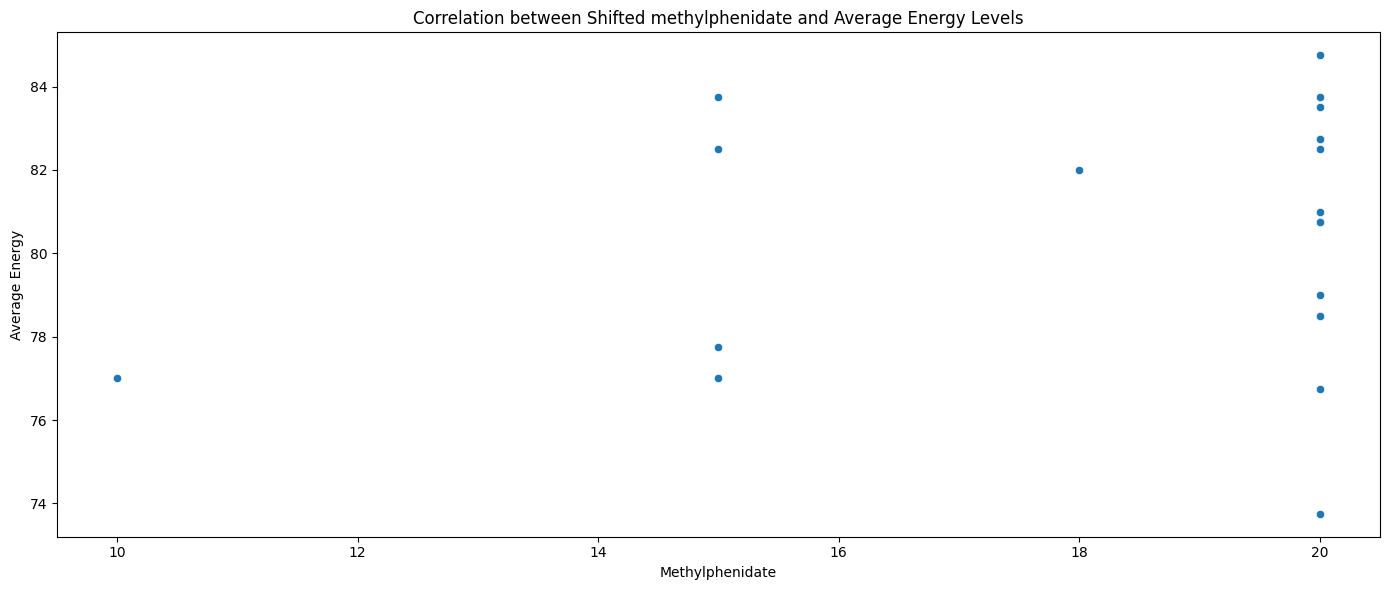

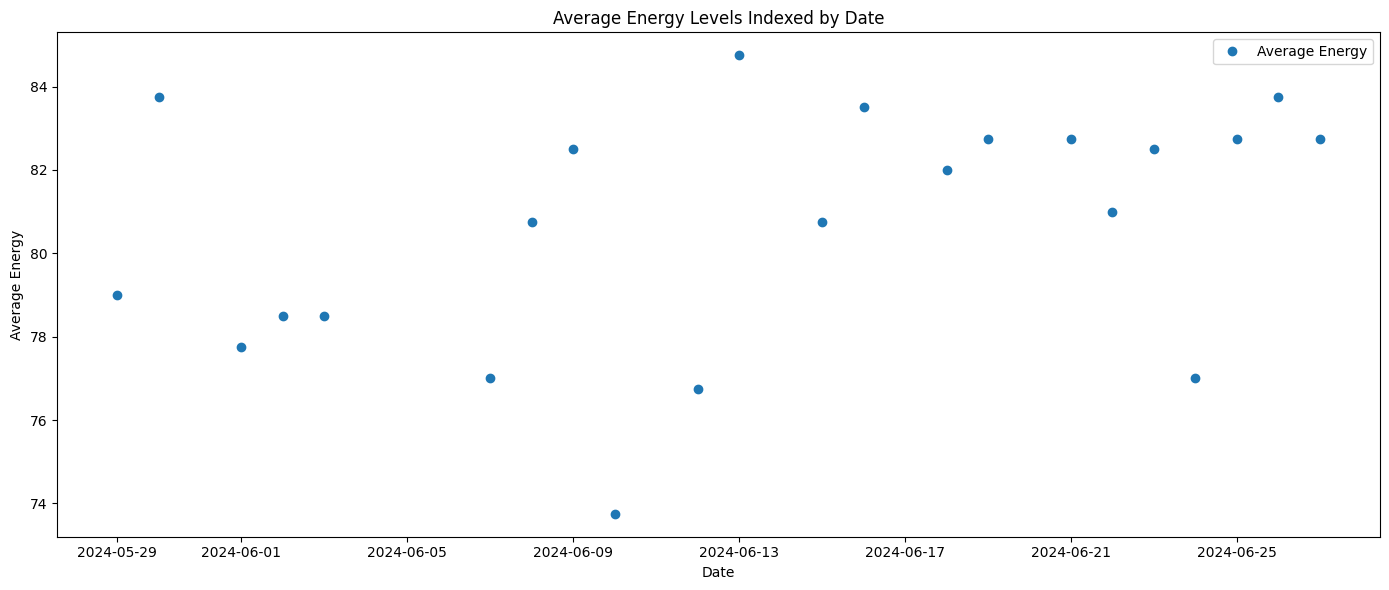

Pearson correlation between shifted caffeine and average energy levels: nan
P-value: nan


/tmp/ipykernel_2727101/822439646.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])


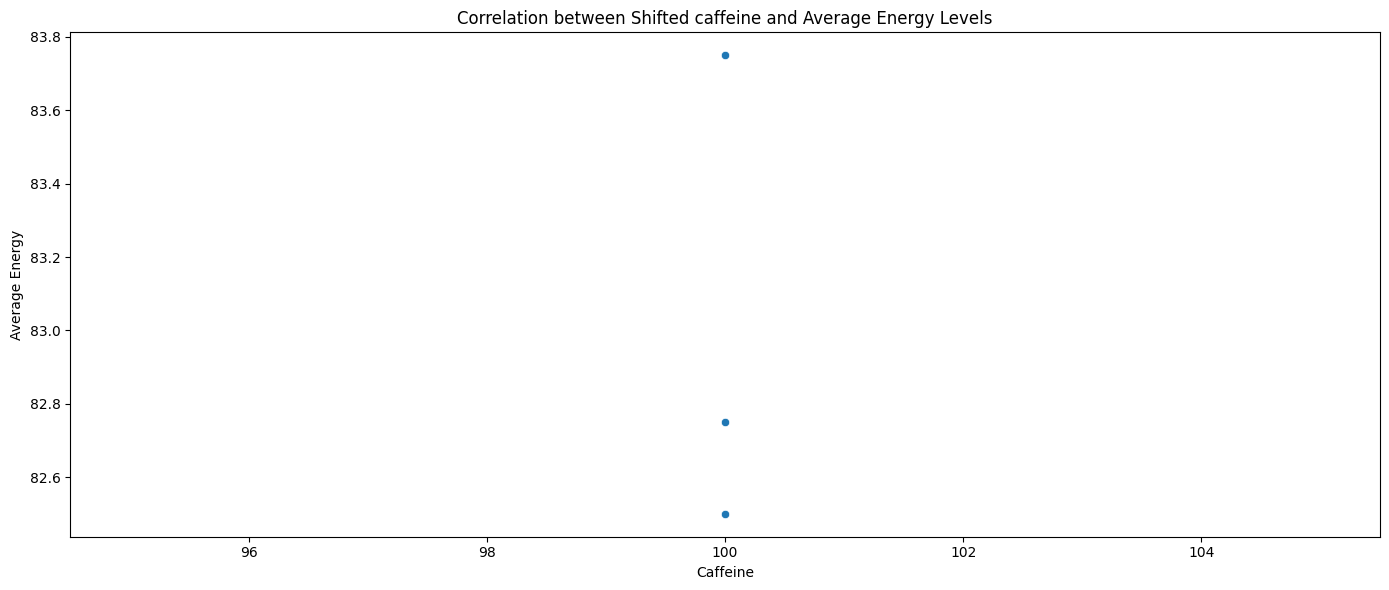

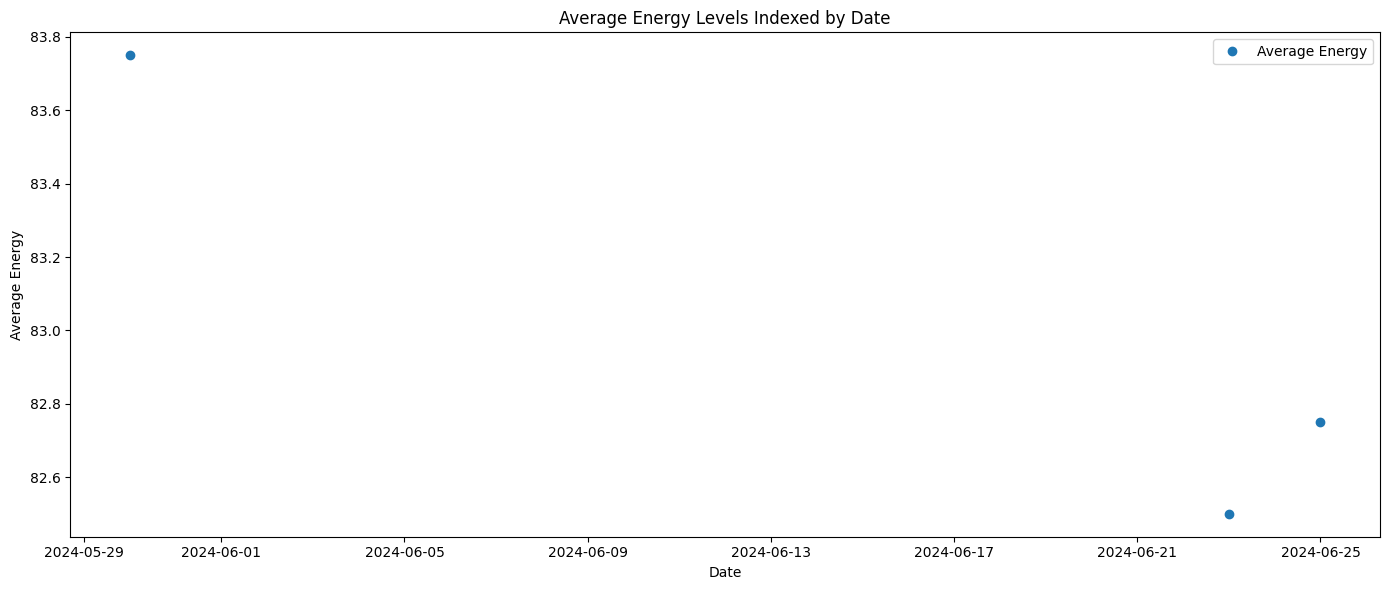

ValueError: data type <class 'numpy.object_'> not inexact

In [29]:
for column in ['potassium', 'omega3', 'grey', 'vitamin_d', 'methylphenidate', 'caffeine', 'creatine']:
    analyze_energy_levels_correlation(data, '2024-05-29', '2024-06-28', column)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


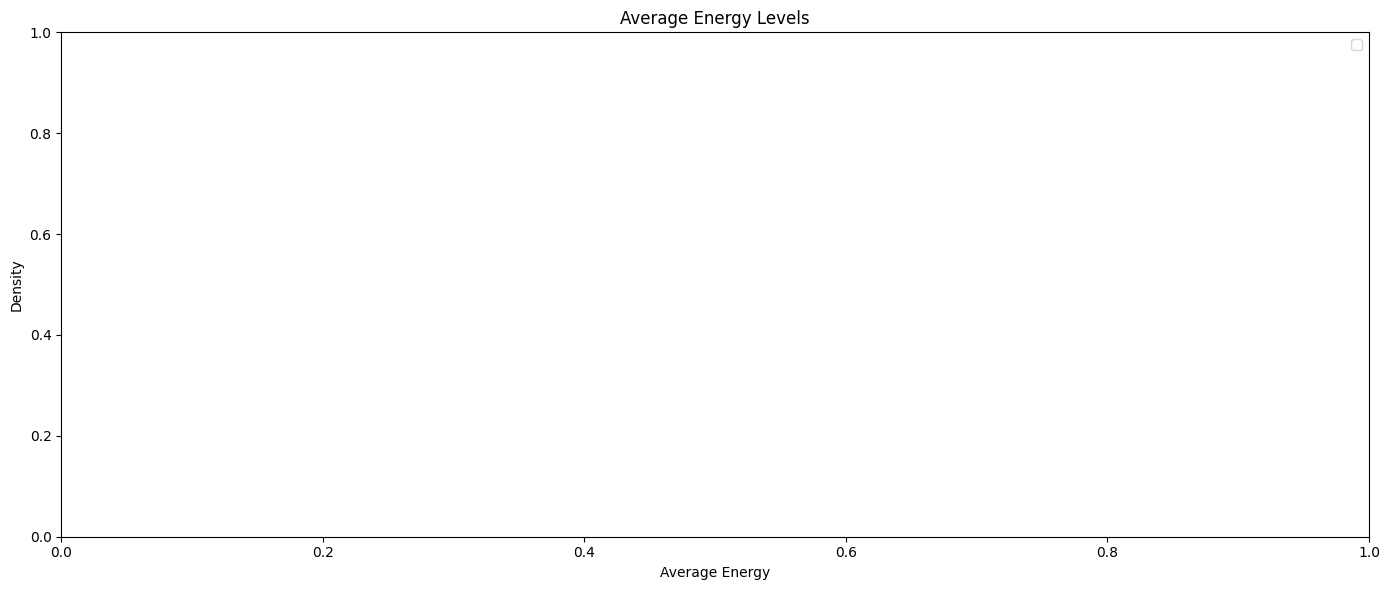

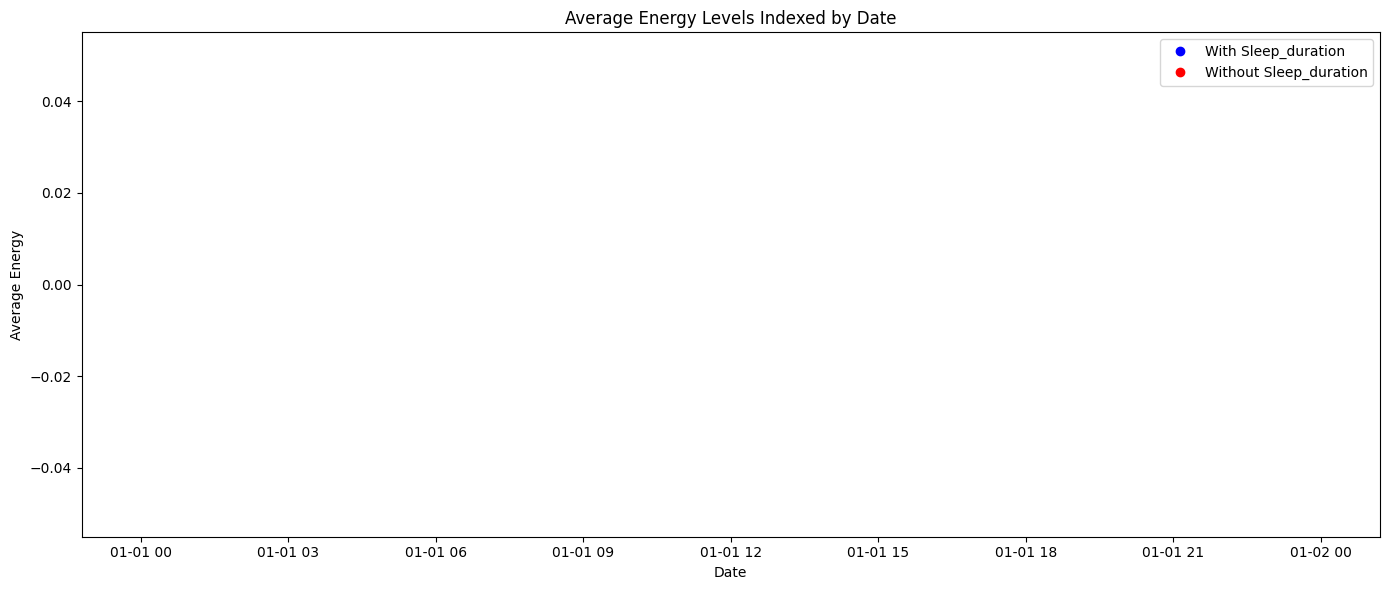

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_energy, mu2_energy, sigma1_energy, sigma2_energy]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Summary for Average Energy Levels Model:
                mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1_energy     0.081   9.855 -18.071   18.608      0.120    0.115    6722.0   
mu2_energy     0.205  10.048 -18.962   18.764      0.121    0.122    6943.0   
sigma1_energy  8.020   6.108   0.001   18.926      0.089    0.063    3166.0   
sigma2_energy  8.008   6.036   0.002   19.066      0.077    0.055    4202.0   
diff_energy    0.124  13.947 -26.040   25.988      0.172    0.159    6545.0   

               ess_tail  r_hat  
mu1_energy       5176.0    1.0  
mu2_energy       5149.0    1.0  
sigma1_energy    2053.0    1.0  
sigma2_energy    2746.0    1.0  
diff_energy      5629.0    1.0  


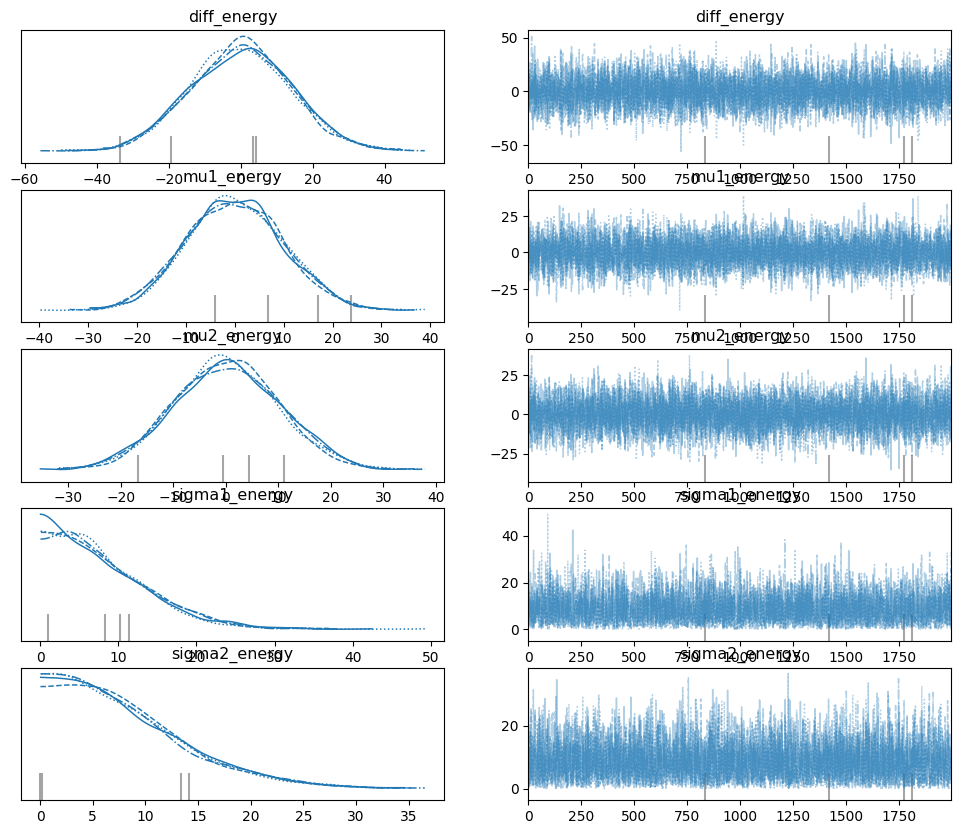

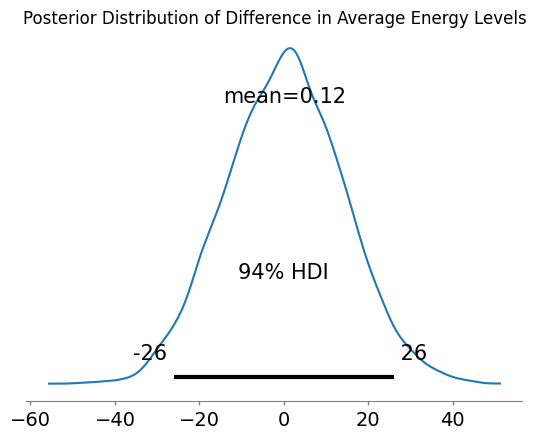

In [68]:
analyze_energy_levels(data, '2024-05-29', '2024-06-28', 'sleep_duration')

In [222]:
sun_hours = pd.read_csv("estimated_daily_sun_hours.csv")
sun_hours['Date'] = pd.to_datetime(sun_hours['Date'])
sun_hours.index=sun_hours['Date']
sun_hours.rename(columns={"Total Estimated Sun Hours": "sun_hours"}, inplace=True)

In [223]:

sun_hours_during_work = pd.read_csv("estimated_daily_sun_hours_during_work.csv")
sun_hours_during_work['Date'] = pd.to_datetime(sun_hours_during_work['Date'])
sun_hours_during_work.index=sun_hours_during_work['Date']
sun_hours_during_work.rename(columns={"Total Estimated Sun Hours": "sun_work_hours"}, inplace=True)

In [224]:
sun_hours_during_work

Date  sun_work_hours
Date                                 
2024-05-01 2024-05-01            0.00
2024-05-02 2024-05-02            0.45
2024-05-03 2024-05-03            0.00
2024-05-04 2024-05-04            3.04
2024-05-05 2024-05-05            2.93
...               ...             ...
2024-07-25 2024-07-25            5.87
2024-07-26 2024-07-26            0.80
2024-07-27 2024-07-27            2.92
2024-07-28 2024-07-28            3.11
2024-07-29 2024-07-29            4.02

[90 rows x 2 columns]

In [225]:

work_days_1 = filtered_data.join(sun_hours)[filtered_data.rest_day==0]
work_days = work_days_1.join(sun_hours_during_work['sun_work_hours'])

session_names = ['session_1_2', 'session_1_3', 'session_2_1', 'session_2_2', 'session_2_3']
work_days['work']  = work_days['session_1_1']

for session_name in session_names:
    work_days['work'] += work_days[session_name]
work_days['work'] = work_days['work'] / 6
work_days = work_days.dropna(subset=['work'])

In [226]:
df = pd.DataFrame()

In [227]:
def plot_scatter_with_correlation(df, x_col, y_col, title=None, figsize=(10, 6)):
    """
    Create a scatter plot with a correlation line for two columns in a dataframe.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    x_col (str): The name of the column to use for the x-axis.
    y_col (str): The name of the column to use for the y-axis.
    title (str, optional): The title of the plot. If None, a default title is used.
    figsize (tuple, optional): The size of the figure. Default is (10, 6).
    
    Returns:
    matplotlib.figure.Figure: The created figure object.
    """
    # Calculate the correlation coefficient
    correlation = df[x_col].corr(df[y_col])

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x_col], df[y_col], alpha=0.5)

    # Customize the plot
    if title is None:
        title = f'Scatter Plot: {x_col} vs {y_col}'
    ax.set_title(f'{title}\nCorrelation: {correlation:.2f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    # Add a text box with the correlation coefficient
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Display the plot
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig

In [228]:
work_days.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'potassium', 'iodine', 'omega3', 'vitamin_d',
       'vitamin_b', 'magnesium', 'probiotic', 'notes', 'creatine',
       'masturbate', 'masturbate', 'porn', 'earplugs', 'window', 'melatonin',
       'Übelkeit', 'last_food', 'l_theanine', 'methylphenidate',
       'muntermacher', 'caffeine', 'Unnamed: 28', 'session_1_cold_shower',
       'session_2_cold_shower', 'session_3', 'rest_day', 'session_1_1',
       'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2',
       'session_2_3', 'session_3_1', 'session_3_2', 'session_3_3',
       'avg_energy_session_1', 'avg_energy_session_2', 'avg_energy', 'Date',
       'sun_hours', 'sun_work_hours', 'work'],
      dtype='object')

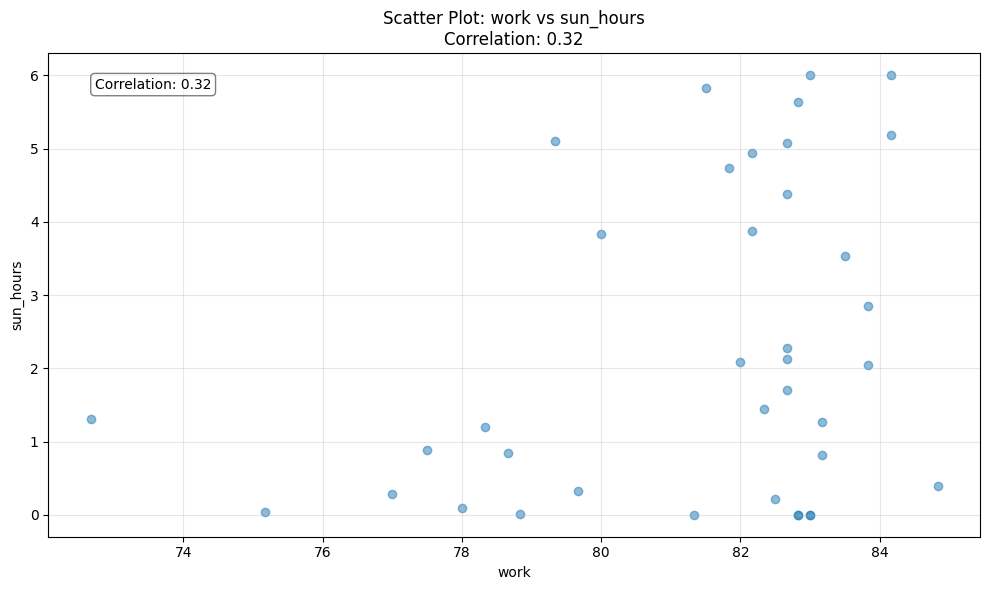

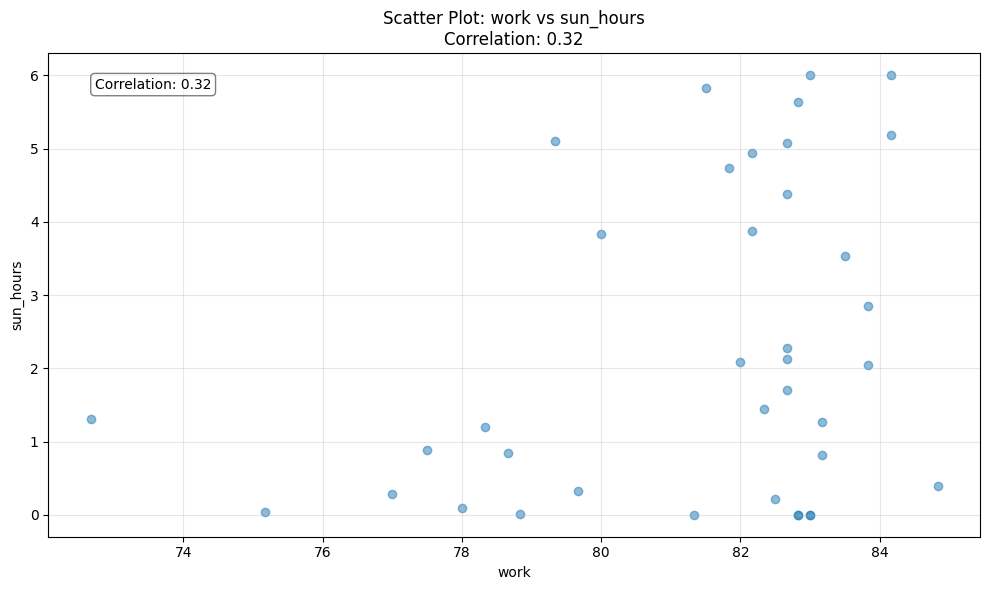

In [229]:
plot_scatter_with_correlation(work_days, 'work', 'sun_hours')

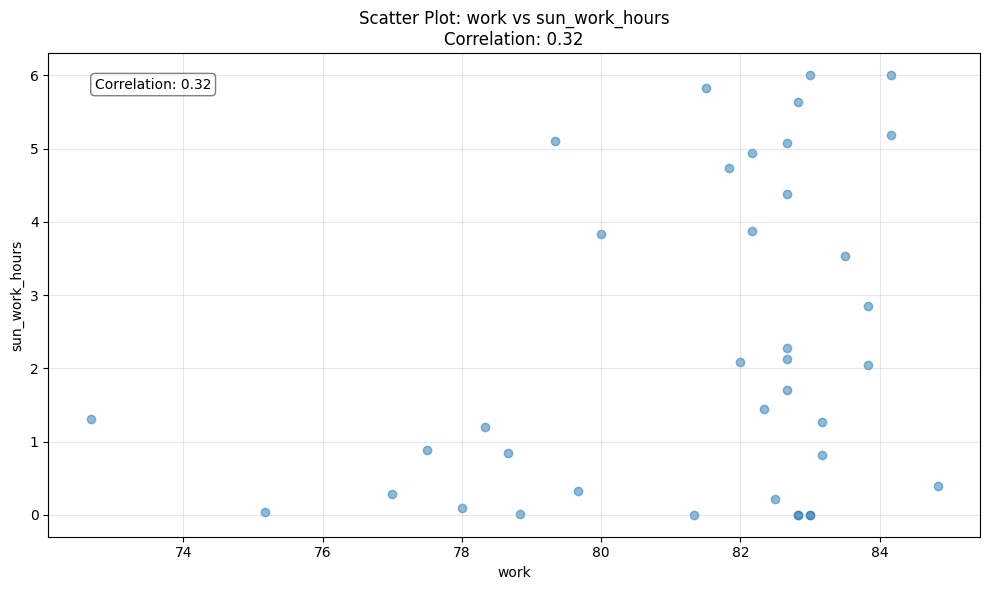

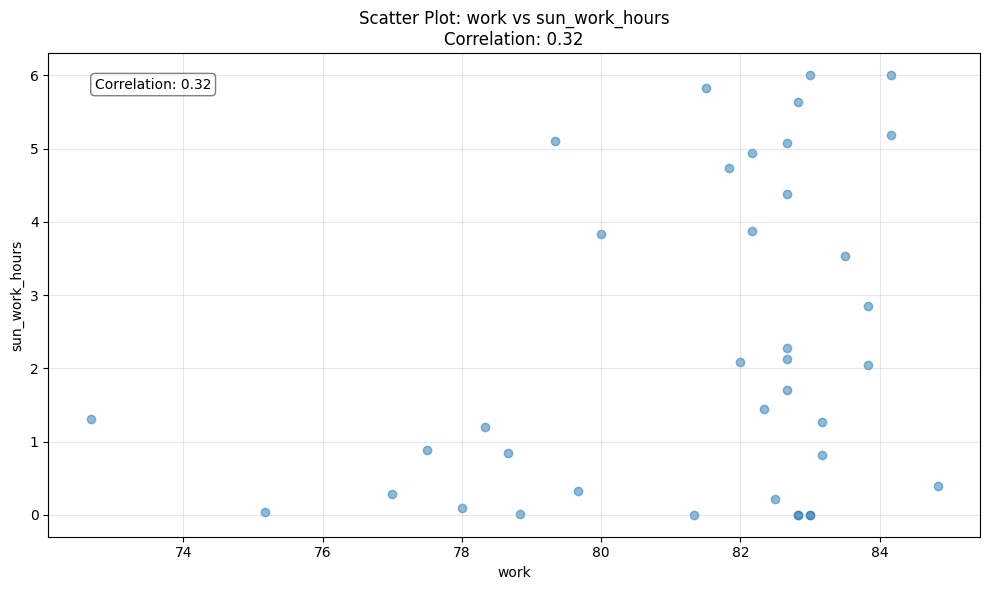

In [230]:
plot_scatter_with_correlation(work_days, 'work', 'sun_work_hours')

In [159]:
from pandas._typing import timedelta

In [160]:
work_days['work']

Date
2024-05-29    78.000000
2024-05-30    84.833333
2024-06-01    78.833333
2024-06-02    77.500000
2024-06-03    79.666667
2024-06-08    78.666667
2024-06-09    82.500000
2024-06-10    72.666667
2024-06-12    75.166667
2024-06-15    81.333333
2024-06-16    82.666667
2024-06-18    82.166667
2024-06-19    82.666667
2024-06-21    82.833333
2024-06-22    80.000000
2024-06-23    82.833333
2024-06-24    77.000000
2024-06-25    82.666667
2024-06-26    83.833333
2024-06-27    82.000000
2024-06-29    83.500000
2024-06-30    81.833333
2024-07-01    83.000000
2024-07-04    78.333333
2024-07-05    83.166667
2024-07-06    83.166667
2024-07-07    82.333333
2024-07-08    79.333333
2024-07-09    84.166667
2024-07-11    82.666667
2024-07-14    82.666667
2024-07-15    82.833333
2024-07-16    84.166667
2024-07-17    83.833333
2024-07-18    82.166667
2024-07-19    81.500000
2024-07-20    83.000000
2024-07-21    83.000000
Name: work, dtype: float64

In [231]:
work_days['time_since_start'] = (work_days.index - pd.to_datetime(start_date))

In [232]:
work_days['seconds_since_start']= work_days['time_since_start'].apply(lambda x: x.total_seconds() / 3600)

In [233]:
work_days['time_since_start']

Date
2024-05-29    1 days
2024-05-30    2 days
2024-06-01    4 days
2024-06-02    5 days
2024-06-03    6 days
2024-06-08   11 days
2024-06-09   12 days
2024-06-10   13 days
2024-06-12   15 days
2024-06-15   18 days
2024-06-16   19 days
2024-06-18   21 days
2024-06-19   22 days
2024-06-21   24 days
2024-06-22   25 days
2024-06-23   26 days
2024-06-24   27 days
2024-06-25   28 days
2024-06-26   29 days
2024-06-27   30 days
2024-06-29   32 days
2024-06-30   33 days
2024-07-01   34 days
2024-07-04   37 days
2024-07-05   38 days
2024-07-06   39 days
2024-07-07   40 days
2024-07-08   41 days
2024-07-09   42 days
2024-07-11   44 days
2024-07-14   47 days
2024-07-15   48 days
2024-07-16   49 days
2024-07-17   50 days
2024-07-18   51 days
2024-07-19   52 days
2024-07-20   53 days
2024-07-21   54 days
Name: time_since_start, dtype: timedelta64[ns]

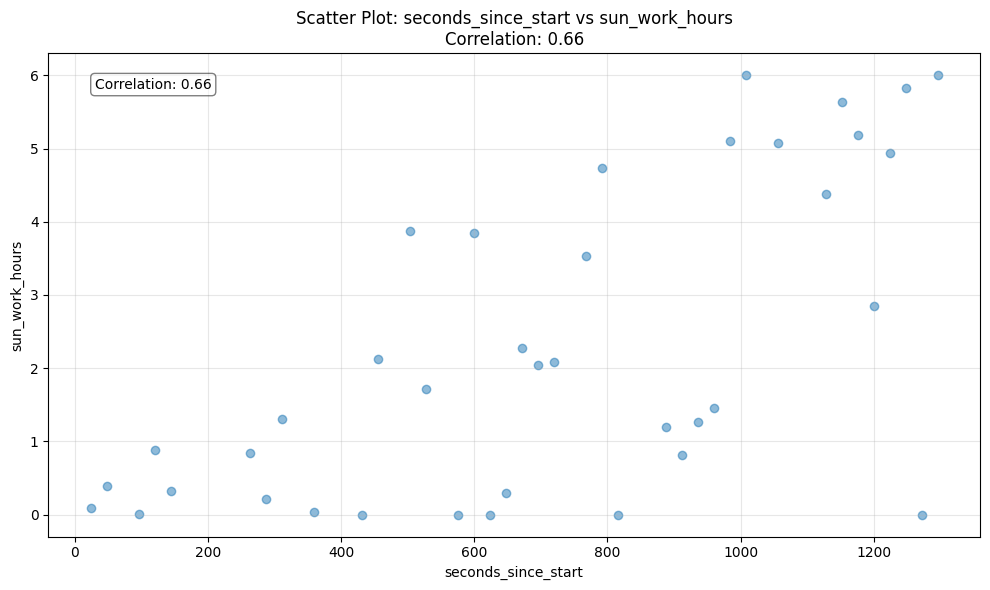

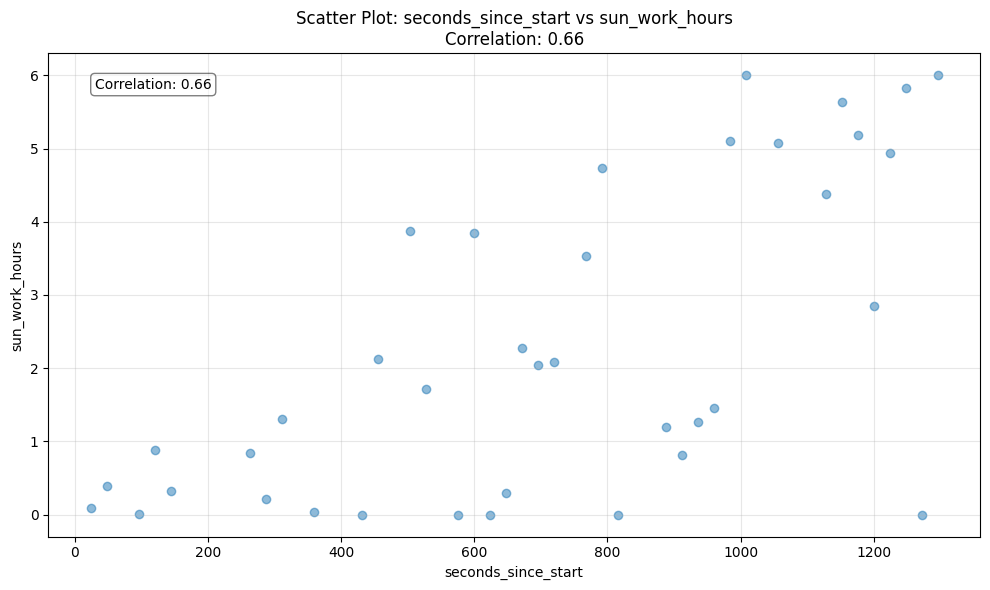

In [234]:
plot_scatter_with_correlation(work_days,'seconds_since_start', 'sun_work_hours')

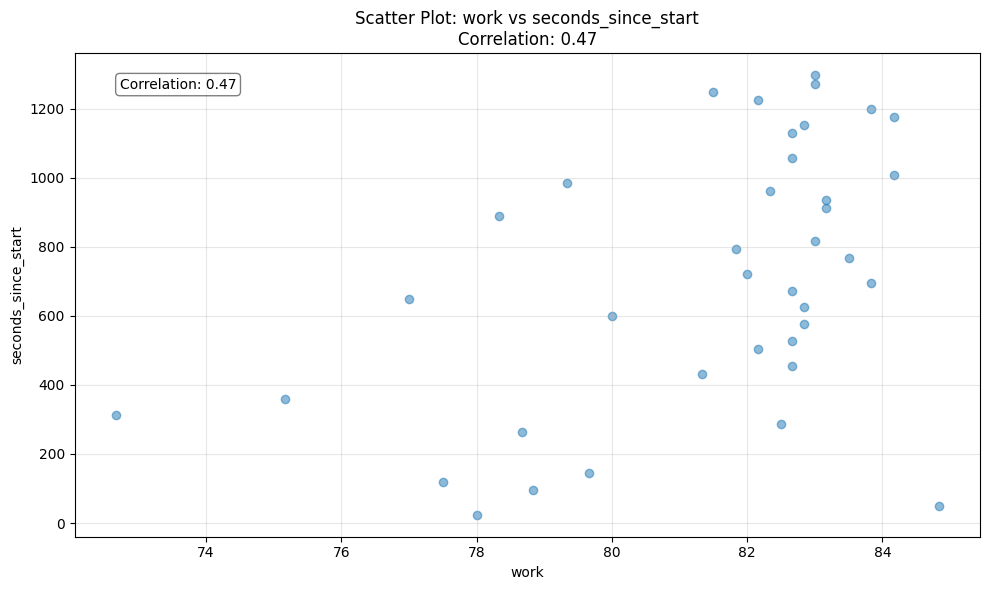

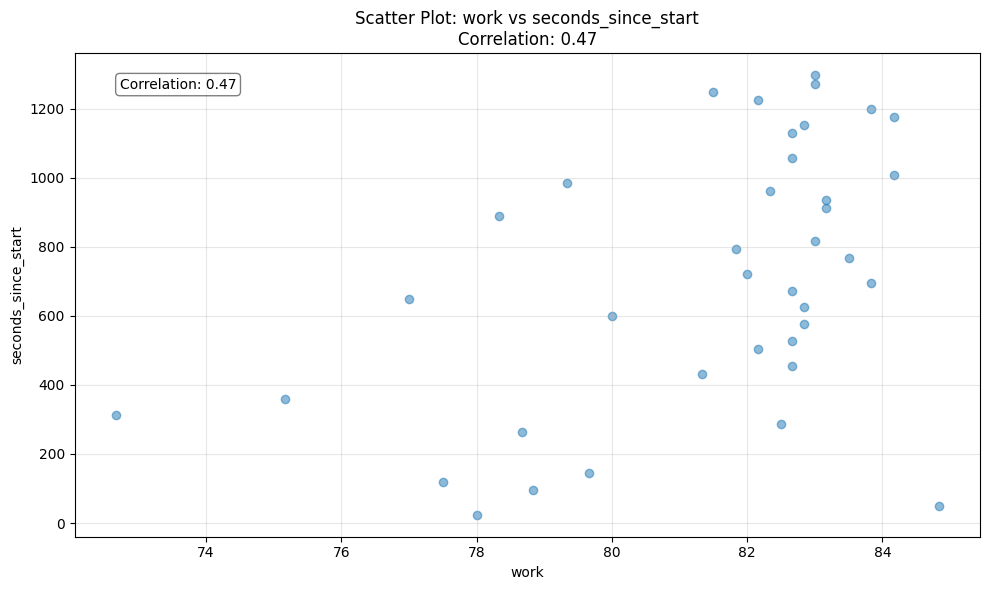

In [165]:
plot_scatter_with_correlation(work_days, 'work', 'seconds_since_start')

In [170]:
work_days['seconds_since_start']

Date
2024-05-29      24.0
2024-05-30      48.0
2024-06-01      96.0
2024-06-02     120.0
2024-06-03     144.0
2024-06-08     264.0
2024-06-09     288.0
2024-06-10     312.0
2024-06-12     360.0
2024-06-15     432.0
2024-06-16     456.0
2024-06-18     504.0
2024-06-19     528.0
2024-06-21     576.0
2024-06-22     600.0
2024-06-23     624.0
2024-06-24     648.0
2024-06-25     672.0
2024-06-26     696.0
2024-06-27     720.0
2024-06-29     768.0
2024-06-30     792.0
2024-07-01     816.0
2024-07-04     888.0
2024-07-05     912.0
2024-07-06     936.0
2024-07-07     960.0
2024-07-08     984.0
2024-07-09    1008.0
2024-07-11    1056.0
2024-07-14    1128.0
2024-07-15    1152.0
2024-07-16    1176.0
2024-07-17    1200.0
2024-07-18    1224.0
2024-07-19    1248.0
2024-07-20    1272.0
2024-07-21    1296.0
Name: seconds_since_start, dtype: float64

In [248]:
from sklearn.linear_model import LinearRegression

model_work = LinearRegression().fit(work_days[['seconds_since_start']], work_days[['work']])
model_sun = LinearRegression().fit(work_days[['seconds_since_start']], work_days[['sun_work_hours']])
model_sun_work = LinearRegression().fit(work_days[['sun_work_hours']], work_days[['work']])
model_sun_time = LinearRegression().fit(work_days[['sun_work_hours']], work_days[['seconds_since_start']])

# Create new columns with residuals
work_days[['work_residuals']] = work_days[['work']] - model_work.predict(work_days[['seconds_since_start']])
work_days[['sun_hours_residuals']] = work_days[['sun_work_hours']] - model_sun.predict(work_days[['seconds_since_start']])
work_days[['work_sun_residual']] = work_days[['work']] - model_sun_work.predict(work_days[['sun_work_hours']])
work_days[['time_sun_residual']] = work_days[['seconds_since_start']] - model_sun_time.predict(work_days[['sun_work_hours']])



# E = aT + N 
# E - aT = Estimate(N)

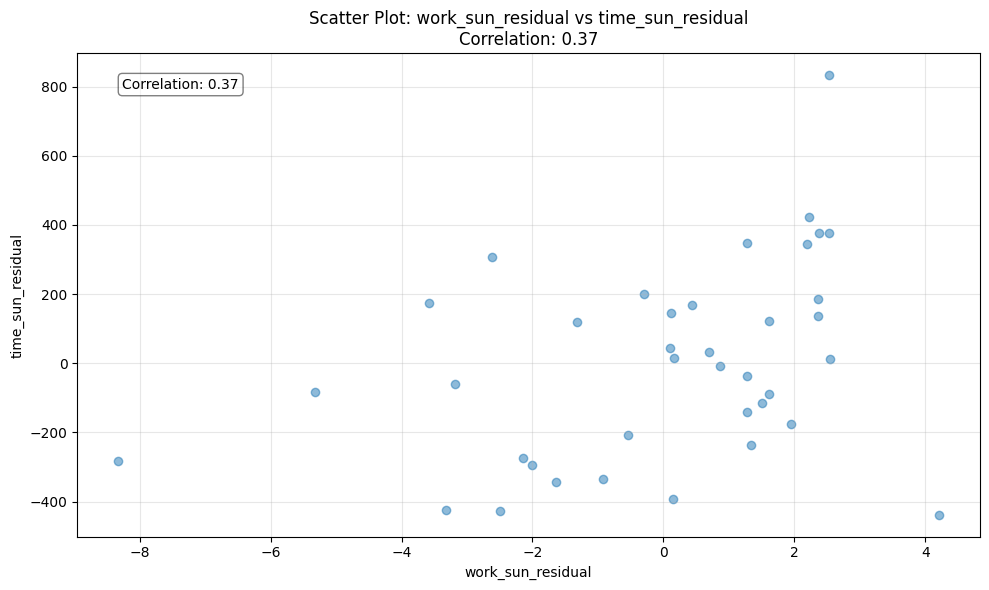

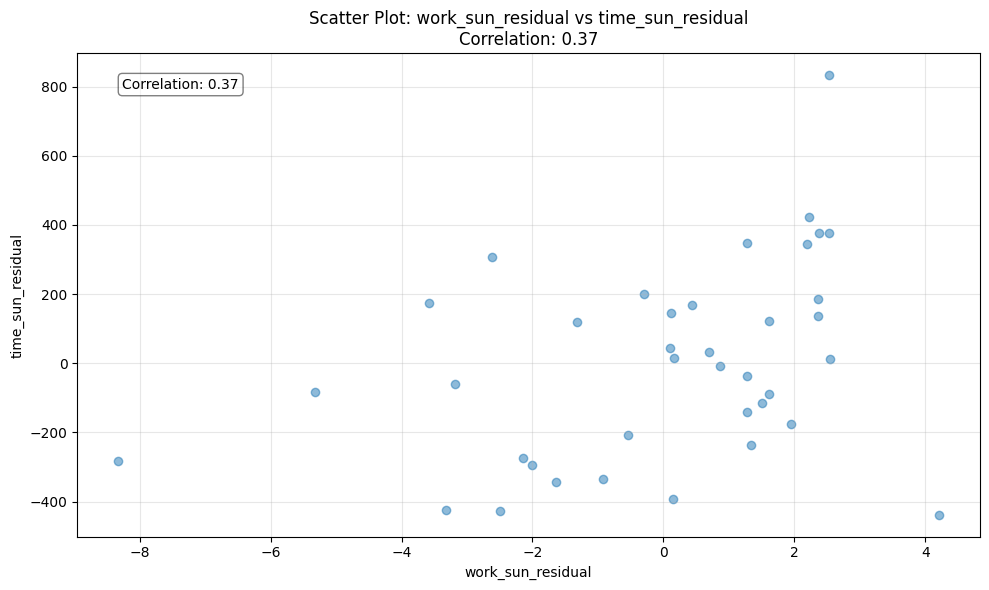

In [249]:
plot_scatter_with_correlation(work_days, 'work_sun_residual', 'time_sun_residual')

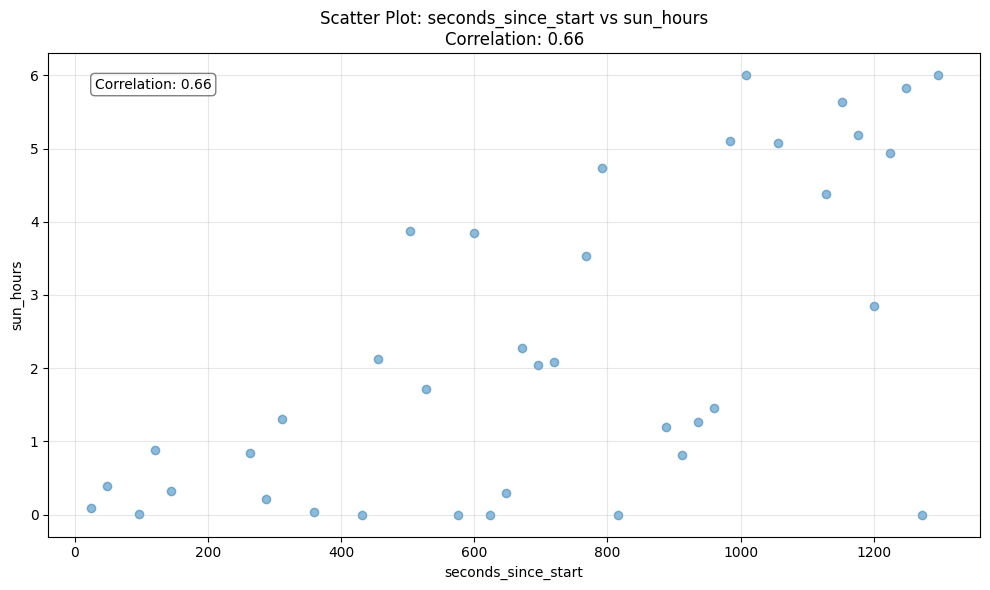

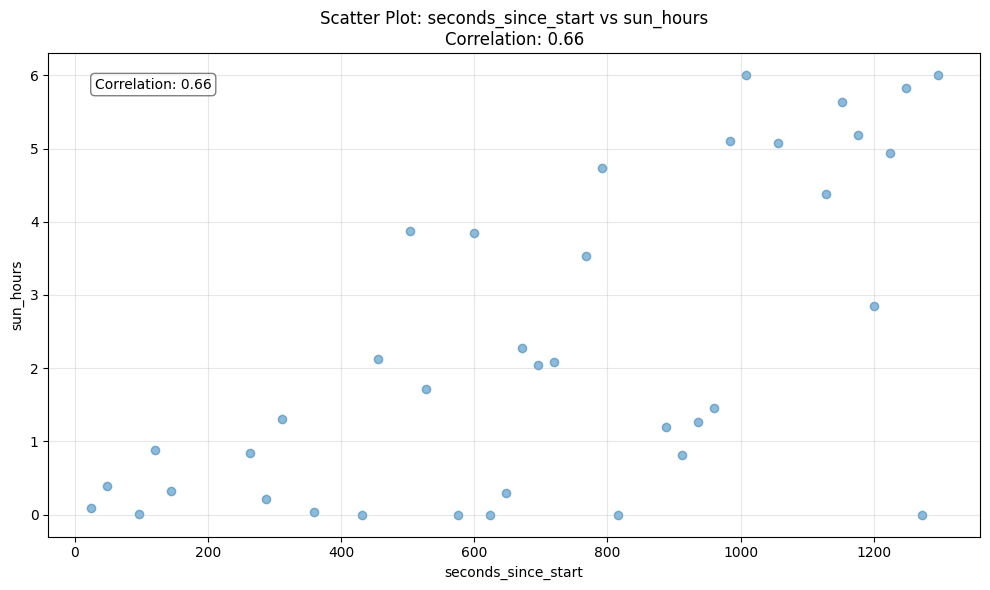

In [247]:
plot_scatter_with_correlation(work_days, 'seconds_since_start','sun_hours')

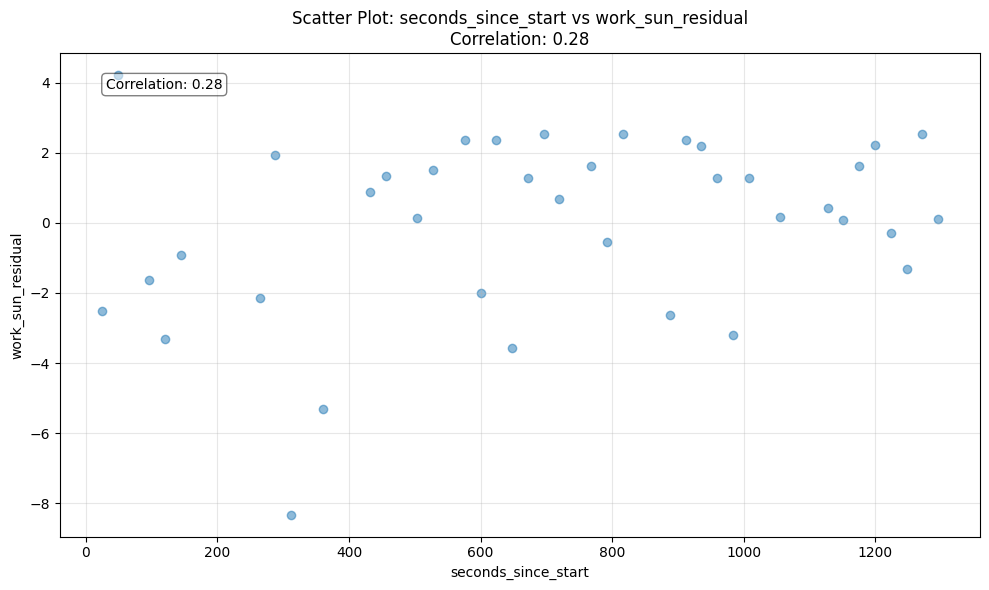

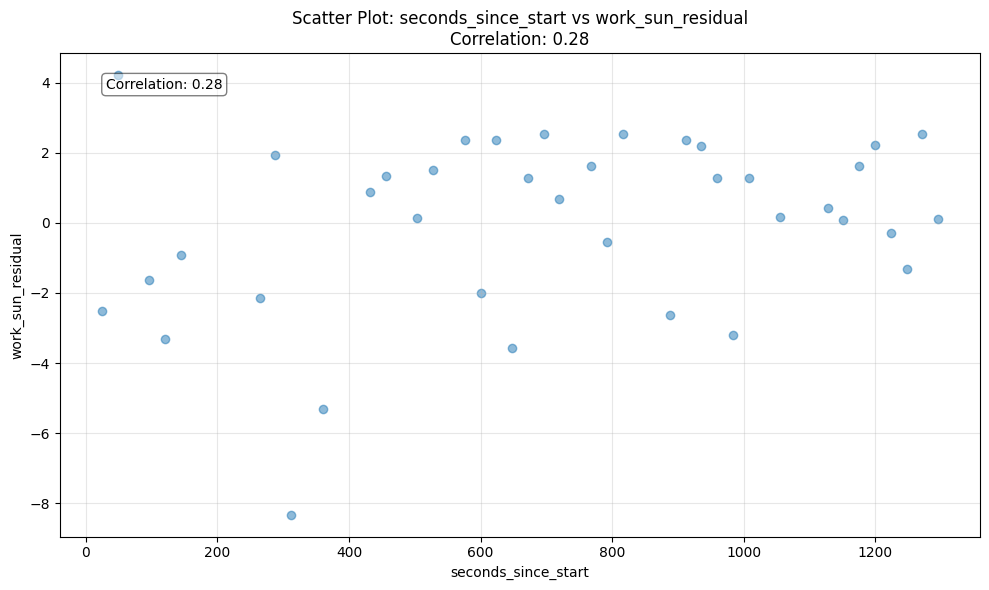

In [246]:
# Sanity check if sun screens off time:
plot_scatter_with_correlation(work_days, 'seconds_since_start', 'work_sun_residual')

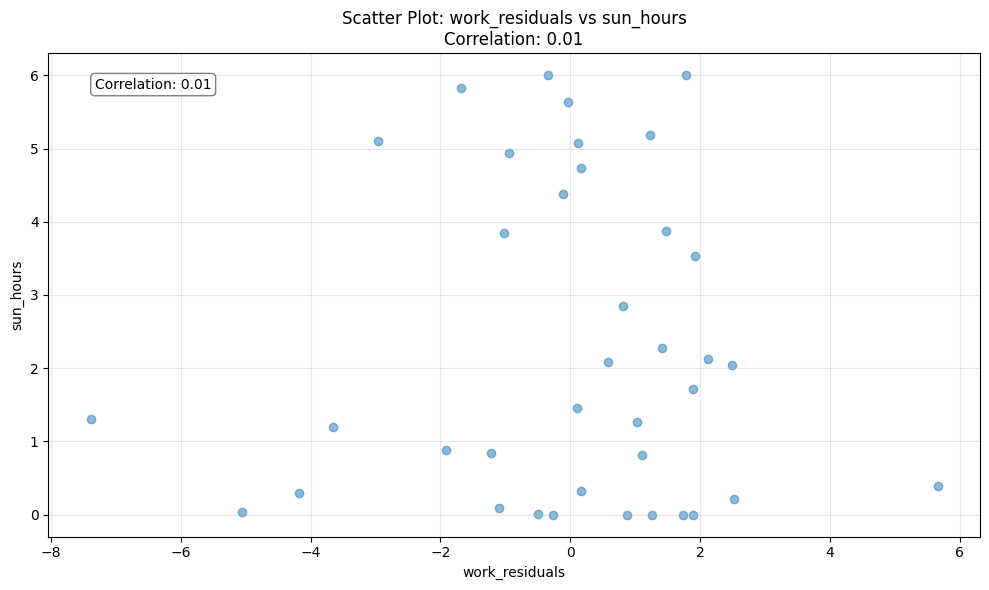

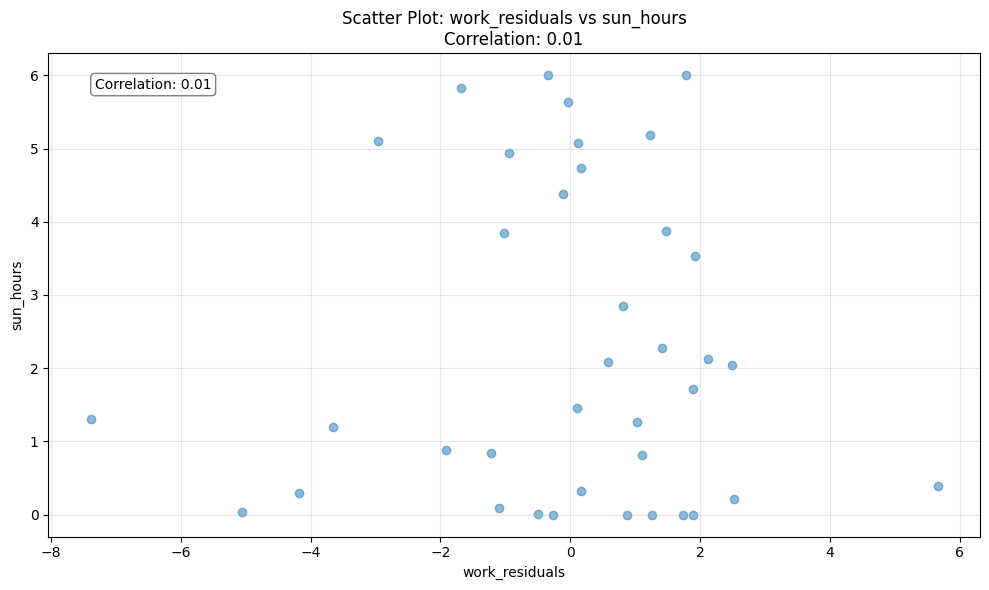

In [240]:
plot_scatter_with_correlation(work_days, 'work_residuals', 'sun_hours')

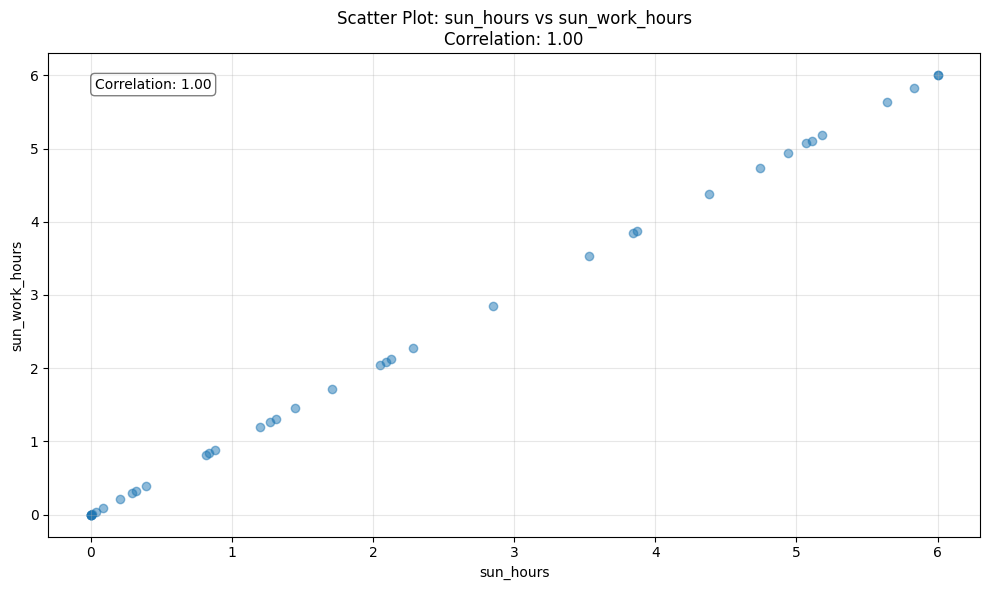

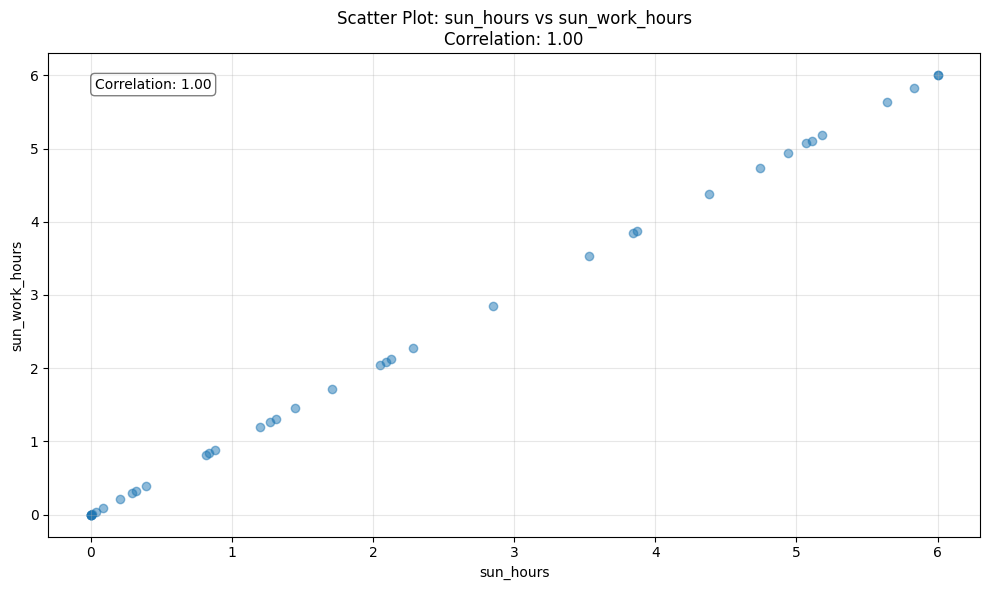

In [180]:
plot_scatter_with_correlation(work_days, 'sun_hours', 'sun_work_hours')